In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import matplotlib.pyplot as plt
import os
import anndata
import harmonypy as hm
import seaborn as sns
import scrublet as scr
import bbknn as bk
%matplotlib inline
import glob
from statannotations.Annotator import Annotator
from itertools import combinations
from matplotlib import rcParams

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
sc.settings.set_figure_params(dpi=200,fontsize=10)

In [3]:
df = pd.read_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/merged_ROIs.csv", index_col = 0)

In [4]:
df

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  \
ROI_A1-1_1                    0       0.000000        0.0000       NaN   
ROI_A1-1_12                   0       0.000000        0.0625  1.000000   
ROI_A1-1_5                    0       0.000000        0.0000       NaN   
ROI_A1-2_0                    0       0.481481        0.0000  3.034483   
ROI_A1-2_4                    0       0.166667        0.0000  1.333333   
...                         ...            ...           ...       ...   
ROI_D2-1_98                   0       0.200000        0.0000  1.714286   
ROI_D2-2_3                    0       0.000000        0.0000  1.000000   
ROI_D2-3_1                    0       0.000000        0.0000       NaN   
ROI_D2-3_24                   0       0.000000        0.0000  1.000000   
ROI_D2-3_34                   0       0.000000        0.0000  1.000000   

             SULF1_log2_mean  NEBL    SEMA3G  SEMA3G_log2_mean      RGCC  \
ROI_A1-1_1               NaN   1.0  2.200000          1.137504  1.400000   
ROI_A1-1_12         0.000000   1.2  2.384615          1.253757  1.000000   
ROI_A1-1_5               NaN   1.0  2.000000          1.000000       NaN   
ROI_A1-2_0          1.601451   NaN  1.000000          0.000000       NaN   
ROI_A1-2_4          0.415038   NaN  1.000000          0.000000  1.000000   
...                      ...   ...       ...               ...       ...   
ROI_D2-1_98         0.777608   1.0  1.500000          0.584963  2.000000   
ROI_D2-2_3          0.000000   1.0  1.000000          0.000000  1.600000   
ROI_D2-3_1               NaN   1.0       NaN               NaN  1.000000   
ROI_D2-3_24         0.000000   1.0  1.000000          0.000000       NaN   
ROI_D2-3_34         0.000000   1.0  1.000000          0.000000  1.571428   

             size   ROI  group  group2  
ROI_A1-1_1     10  A1-1  Small   Small  
ROI_A1-1_12    16  A1-1  Small  Medium  
ROI_A1-1_5      7  A1-1  Small   Small  
ROI_A1-2_0     81  A1-2  Large   Large  
ROI_A1-2_4      6  A1-2  Small   Small  
...           ...   ...    ...     ...  
ROI_D2-1_98    15  D2-1  Small  Medium  
ROI_D2-2_3     14  D2-2  Small  Medium  
ROI_D2-3_1      7  D2-3  Small   Small  
ROI_D2-3_24     7  D2-3  Small   Small  
ROI_D2-3_34    12  D2-3  Small  Medium  

[90 rows x 13 columns]

In [200]:
df["SULF1_raw"] = (df["SULF1_percent"]*df["size"]*df["SULF1"]).fillna(0)
df["NEBL_raw"] = (df["NEBL_percent"]*df["size"]*df["NEBL"]).fillna(0)

In [201]:
df

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  \
ROI_A1-1_1                    0       0.000000        0.0000       NaN   
ROI_A1-1_12                   0       0.000000        0.0625  1.000000   
ROI_A1-1_5                    0       0.000000        0.0000       NaN   
ROI_A1-2_0                    0       0.481481        0.0000  3.034483   
ROI_A1-2_4                    0       0.166667        0.0000  1.333333   
...                         ...            ...           ...       ...   
ROI_D2-1_98                   0       0.200000        0.0000  1.714286   
ROI_D2-2_3                    0       0.000000        0.0000  1.000000   
ROI_D2-3_1                    0       0.000000        0.0000       NaN   
ROI_D2-3_24                   0       0.000000        0.0000  1.000000   
ROI_D2-3_34                   0       0.000000        0.0000  1.000000   

             SULF1_log2_mean  NEBL    SEMA3G  SEMA3G_log2_mean      RGCC  \
ROI_A1-1_1               NaN   1.0  2.200000          1.137504  1.400000   
ROI_A1-1_12         0.000000   1.2  2.384615          1.253757  1.000000   
ROI_A1-1_5               NaN   1.0  2.000000          1.000000       NaN   
ROI_A1-2_0          1.601451   NaN  1.000000          0.000000       NaN   
ROI_A1-2_4          0.415038   NaN  1.000000          0.000000  1.000000   
...                      ...   ...       ...               ...       ...   
ROI_D2-1_98         0.777608   1.0  1.500000          0.584963  2.000000   
ROI_D2-2_3          0.000000   1.0  1.000000          0.000000  1.600000   
ROI_D2-3_1               NaN   1.0       NaN               NaN  1.000000   
ROI_D2-3_24         0.000000   1.0  1.000000          0.000000       NaN   
ROI_D2-3_34         0.000000   1.0  1.000000          0.000000  1.571428   

             size   ROI  group  group2   SULF1_raw  NEBL_raw  
ROI_A1-1_1     10  A1-1  Small   Small    0.000000       0.0  
ROI_A1-1_12    16  A1-1  Small  Medium    0.000000       1.2  
ROI_A1-1_5      7  A1-1  Small   Small    0.000000       0.0  
ROI_A1-2_0     81  A1-2  Large   Large  118.344825       0.0  
ROI_A1-2_4      6  A1-2  Small   Small    1.333333       0.0  
...           ...   ...    ...     ...         ...       ...  
ROI_D2-1_98    15  D2-1  Small  Medium    5.142857       0.0  
ROI_D2-2_3     14  D2-2  Small  Medium    0.000000       0.0  
ROI_D2-3_1      7  D2-3  Small   Small    0.000000       0.0  
ROI_D2-3_24     7  D2-3  Small   Small    0.000000       0.0  
ROI_D2-3_34    12  D2-3  Small  Medium    0.000000       0.0  

[90 rows x 15 columns]

In [206]:
df["SULF1_raw_scaled"] = df["SULF1_raw"]/df["SULF1_raw"].max()
df["NEBL_raw_scaled"] = df["NEBL_raw"]/df["NEBL_raw"].max()

In [207]:
df

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  \
ROI_A1-1_1                    0       0.000000        0.0000       NaN   
ROI_A1-1_12                   0       0.000000        0.0625  1.000000   
ROI_A1-1_5                    0       0.000000        0.0000       NaN   
ROI_A1-2_0                    0       0.481481        0.0000  3.034483   
ROI_A1-2_4                    0       0.166667        0.0000  1.333333   
...                         ...            ...           ...       ...   
ROI_D2-1_98                   0       0.200000        0.0000  1.714286   
ROI_D2-2_3                    0       0.000000        0.0000  1.000000   
ROI_D2-3_1                    0       0.000000        0.0000       NaN   
ROI_D2-3_24                   0       0.000000        0.0000  1.000000   
ROI_D2-3_34                   0       0.000000        0.0000  1.000000   

             SULF1_log2_mean  NEBL    SEMA3G  SEMA3G_log2_mean      RGCC  \
ROI_A1-1_1               NaN   1.0  2.200000          1.137504  1.400000   
ROI_A1-1_12         0.000000   1.2  2.384615          1.253757  1.000000   
ROI_A1-1_5               NaN   1.0  2.000000          1.000000       NaN   
ROI_A1-2_0          1.601451   NaN  1.000000          0.000000       NaN   
ROI_A1-2_4          0.415038   NaN  1.000000          0.000000  1.000000   
...                      ...   ...       ...               ...       ...   
ROI_D2-1_98         0.777608   1.0  1.500000          0.584963  2.000000   
ROI_D2-2_3          0.000000   1.0  1.000000          0.000000  1.600000   
ROI_D2-3_1               NaN   1.0       NaN               NaN  1.000000   
ROI_D2-3_24         0.000000   1.0  1.000000          0.000000       NaN   
ROI_D2-3_34         0.000000   1.0  1.000000          0.000000  1.571428   

             size   ROI  group  group2   SULF1_raw  NEBL_raw  \
ROI_A1-1_1     10  A1-1  Small   Small    0.000000       0.0   
ROI_A1-1_12    16  A1-1  Small  Medium    0.000000       1.2   
ROI_A1-1_5      7  A1-1  Small   Small    0.000000       0.0   
ROI_A1-2_0     81  A1-2  Large   Large  118.344825       0.0   
ROI_A1-2_4      6  A1-2  Small   Small    1.333333       0.0   
...           ...   ...    ...     ...         ...       ...   
ROI_D2-1_98    15  D2-1  Small  Medium    5.142857       0.0   
ROI_D2-2_3     14  D2-2  Small  Medium    0.000000       0.0   
ROI_D2-3_1      7  D2-3  Small   Small    0.000000       0.0   
ROI_D2-3_24     7  D2-3  Small   Small    0.000000       0.0   
ROI_D2-3_34    12  D2-3  Small  Medium    0.000000       0.0   

             SULF1_raw_scaled  NEBL_raw_scaled  
ROI_A1-1_1           0.000000             0.00  
ROI_A1-1_12          0.000000             0.28  
ROI_A1-1_5           0.000000             0.00  
ROI_A1-2_0           0.640595             0.00  
ROI_A1-2_4           0.007217             0.00  
...                       ...              ...  
ROI_D2-1_98          0.027838             0.00  
ROI_D2-2_3           0.000000             0.00  
ROI_D2-3_1           0.000000             0.00  
ROI_D2-3_24          0.000000             0.00  
ROI_D2-3_34          0.000000             0.00  

[90 rows x 17 columns]

In [208]:
df5 = df.melt(id_vars=['size'], value_vars=['SULF1_raw_scaled', 'NEBL_raw_scaled'])
df5

size          variable     value
0      10  SULF1_raw_scaled  0.000000
1      16  SULF1_raw_scaled  0.000000
2       7  SULF1_raw_scaled  0.000000
3      81  SULF1_raw_scaled  0.640595
4       6  SULF1_raw_scaled  0.007217
..    ...               ...       ...
175    15   NEBL_raw_scaled  0.000000
176    14   NEBL_raw_scaled  0.000000
177     7   NEBL_raw_scaled  0.000000
178     7   NEBL_raw_scaled  0.000000
179    12   NEBL_raw_scaled  0.000000

[180 rows x 3 columns]

In [212]:
df.NEBL_raw.max()

4.285714488571428

In [213]:
df.SULF1_raw.max()

184.7419339598387

<AxesSubplot:xlabel='size', ylabel='value'>

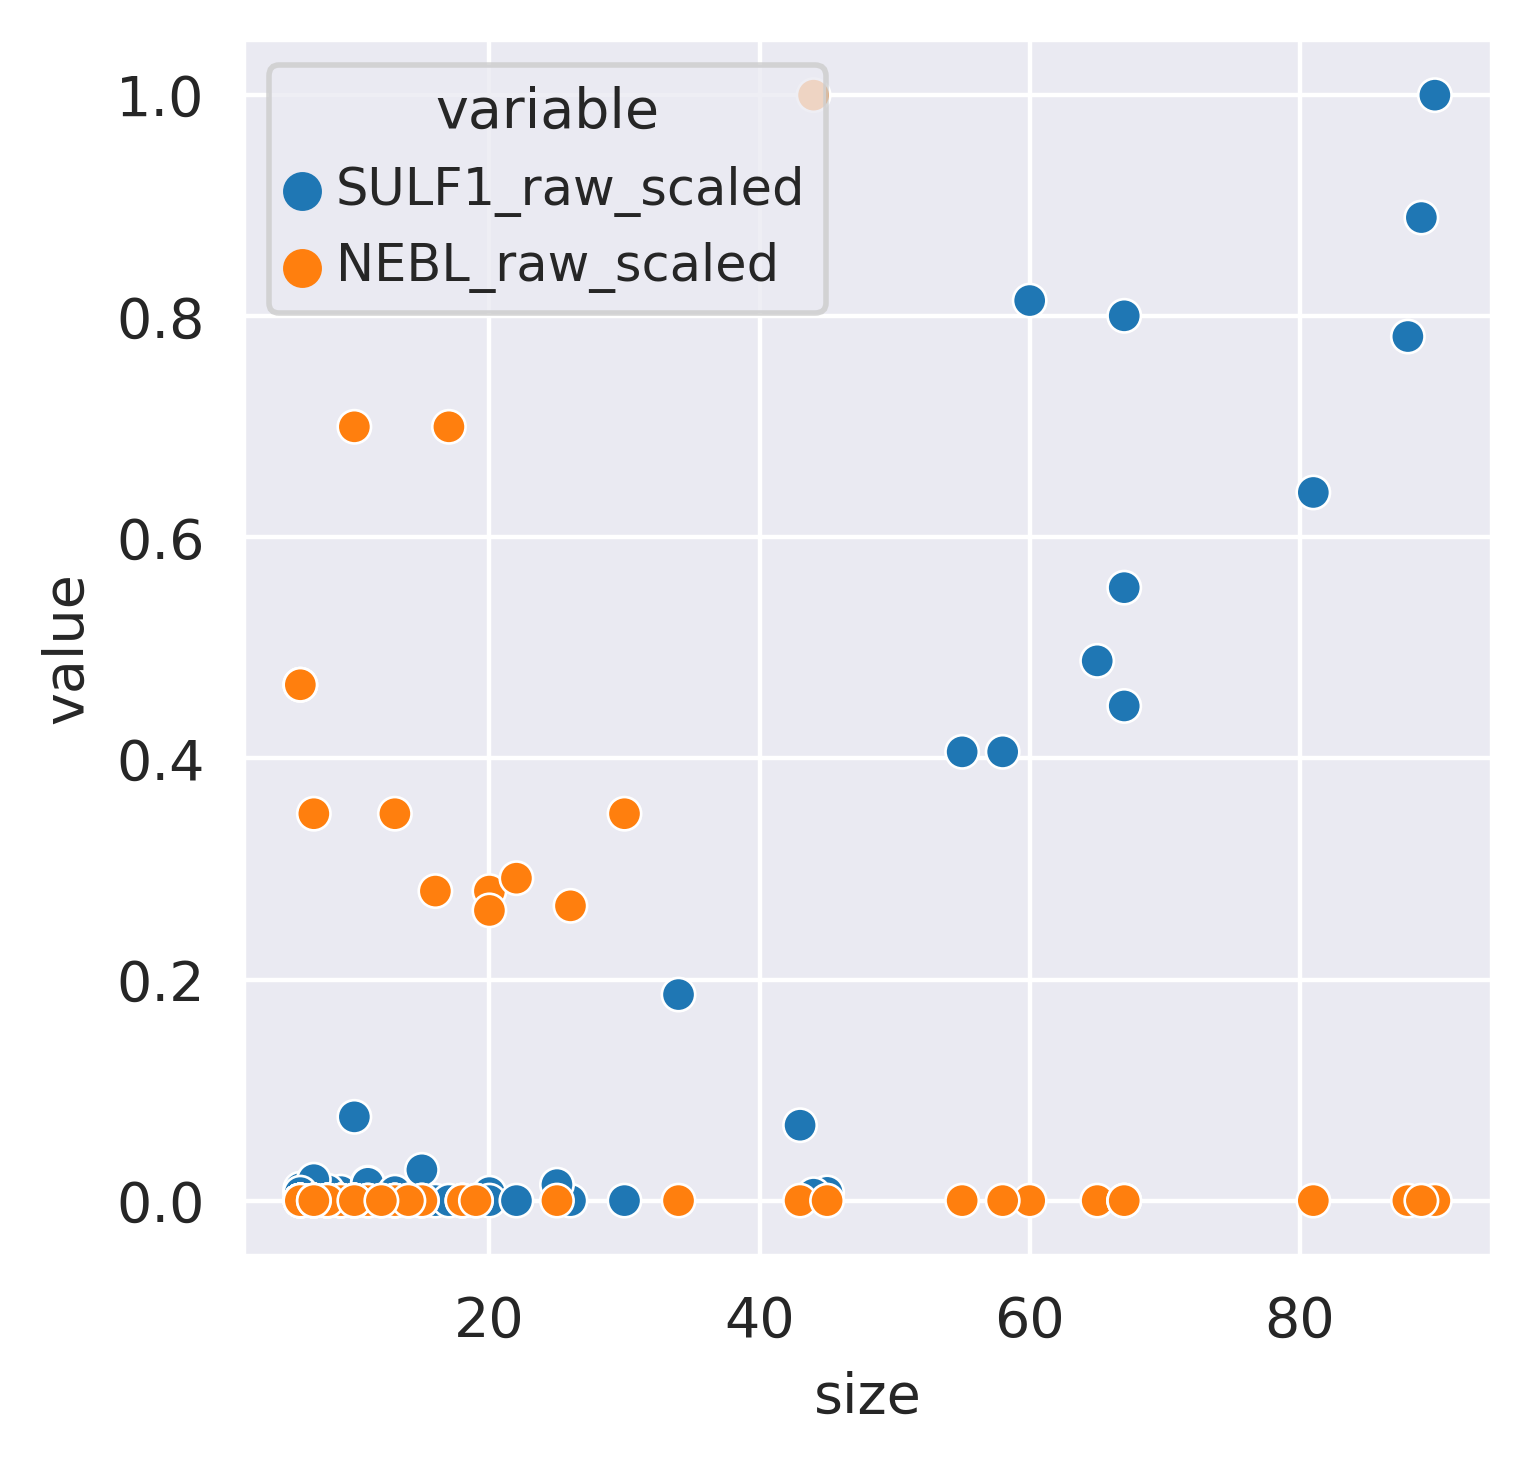

In [296]:
sns.scatterplot(
    data=df5,
    x="size", y="value", hue = 'variable', legend = True
)

In [226]:
plt.ylim(0,1), xlim = (0,1)

sns.displot(
    data=df5,
    x="size", y="value", hue = 'variable', kind = 'kde'
)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1336144137.py, line 1)

<AxesSubplot:xlabel='size', ylabel='SULF1_raw'>

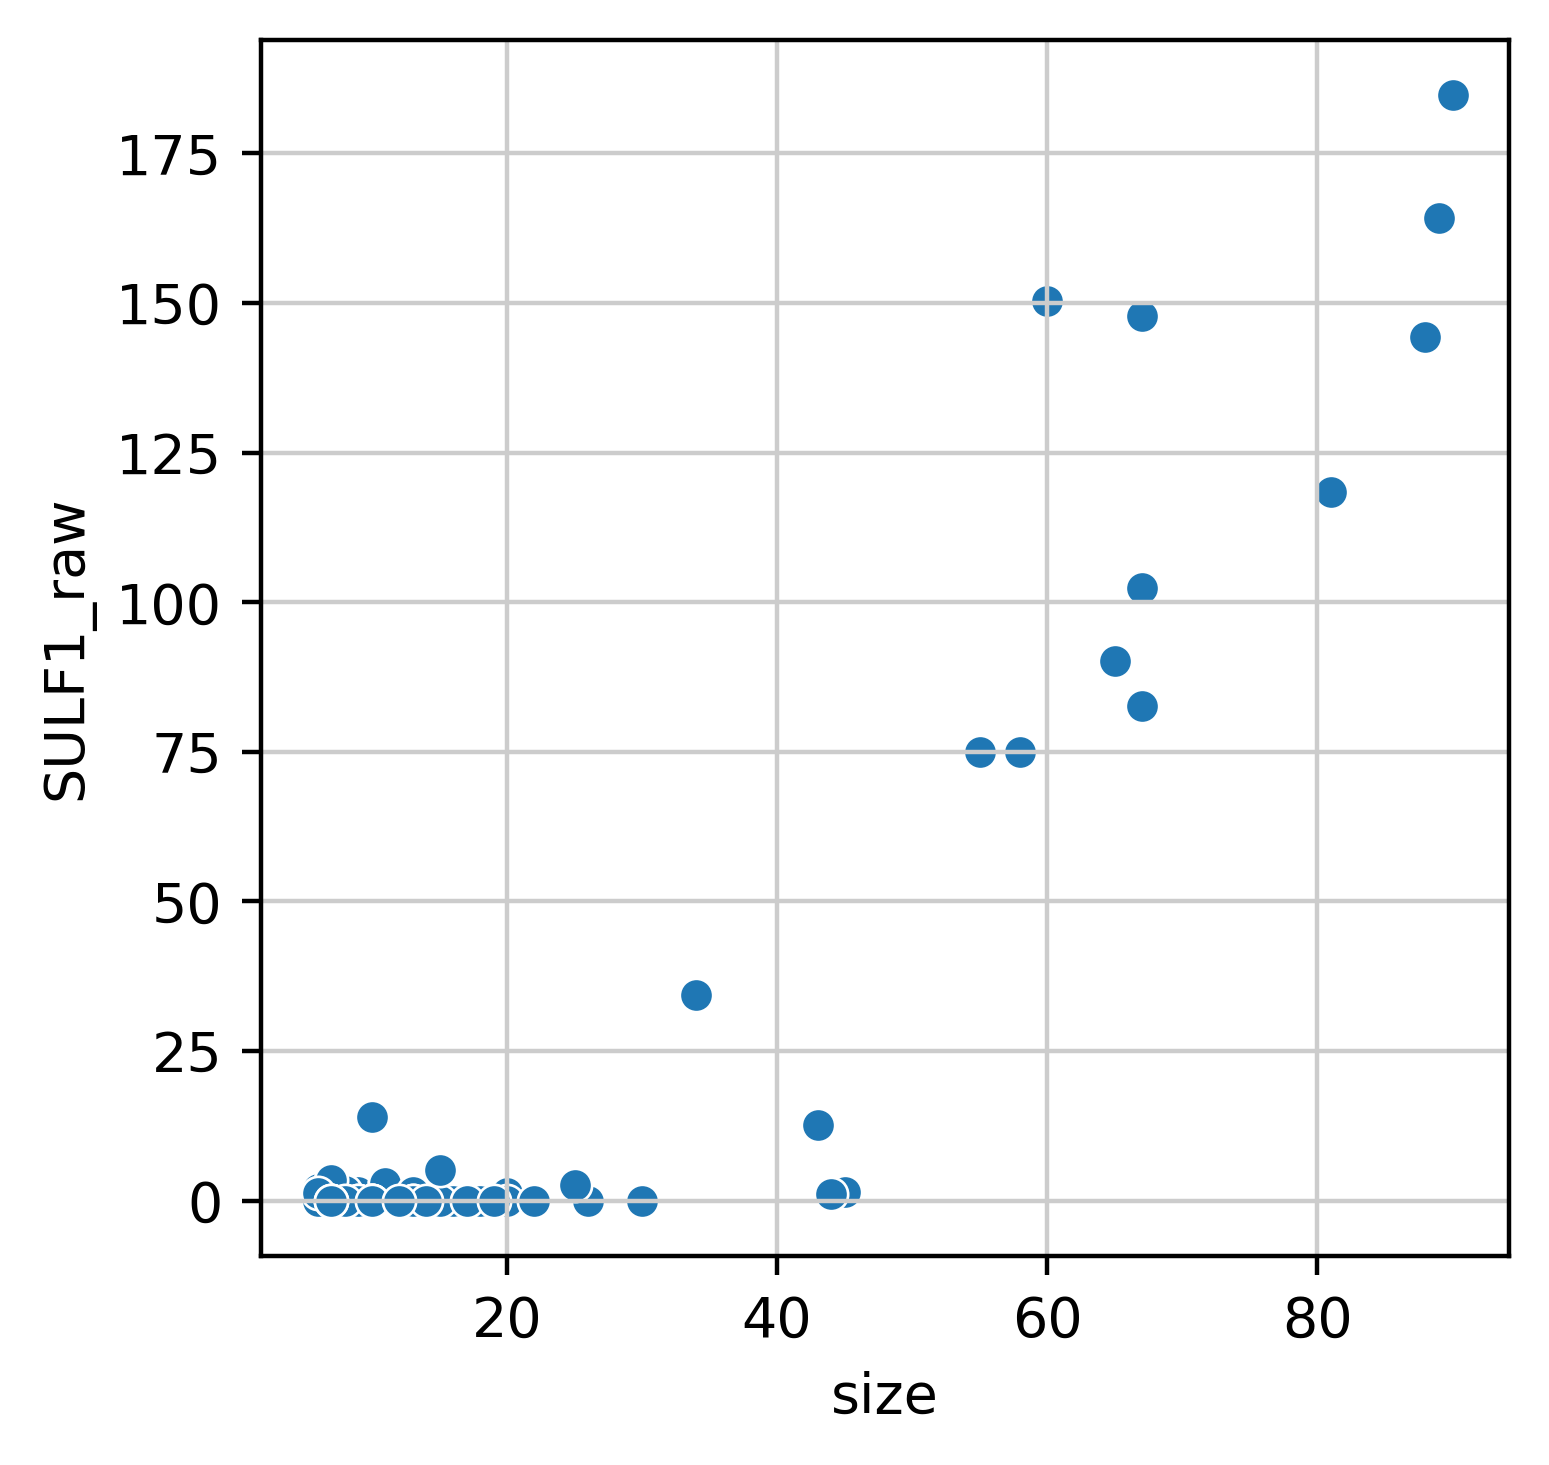

In [194]:
sns.scatterplot(
    data=df,
    x="size", y="SULF1_raw",
)


<AxesSubplot:xlabel='size', ylabel='SULF1_raw'>

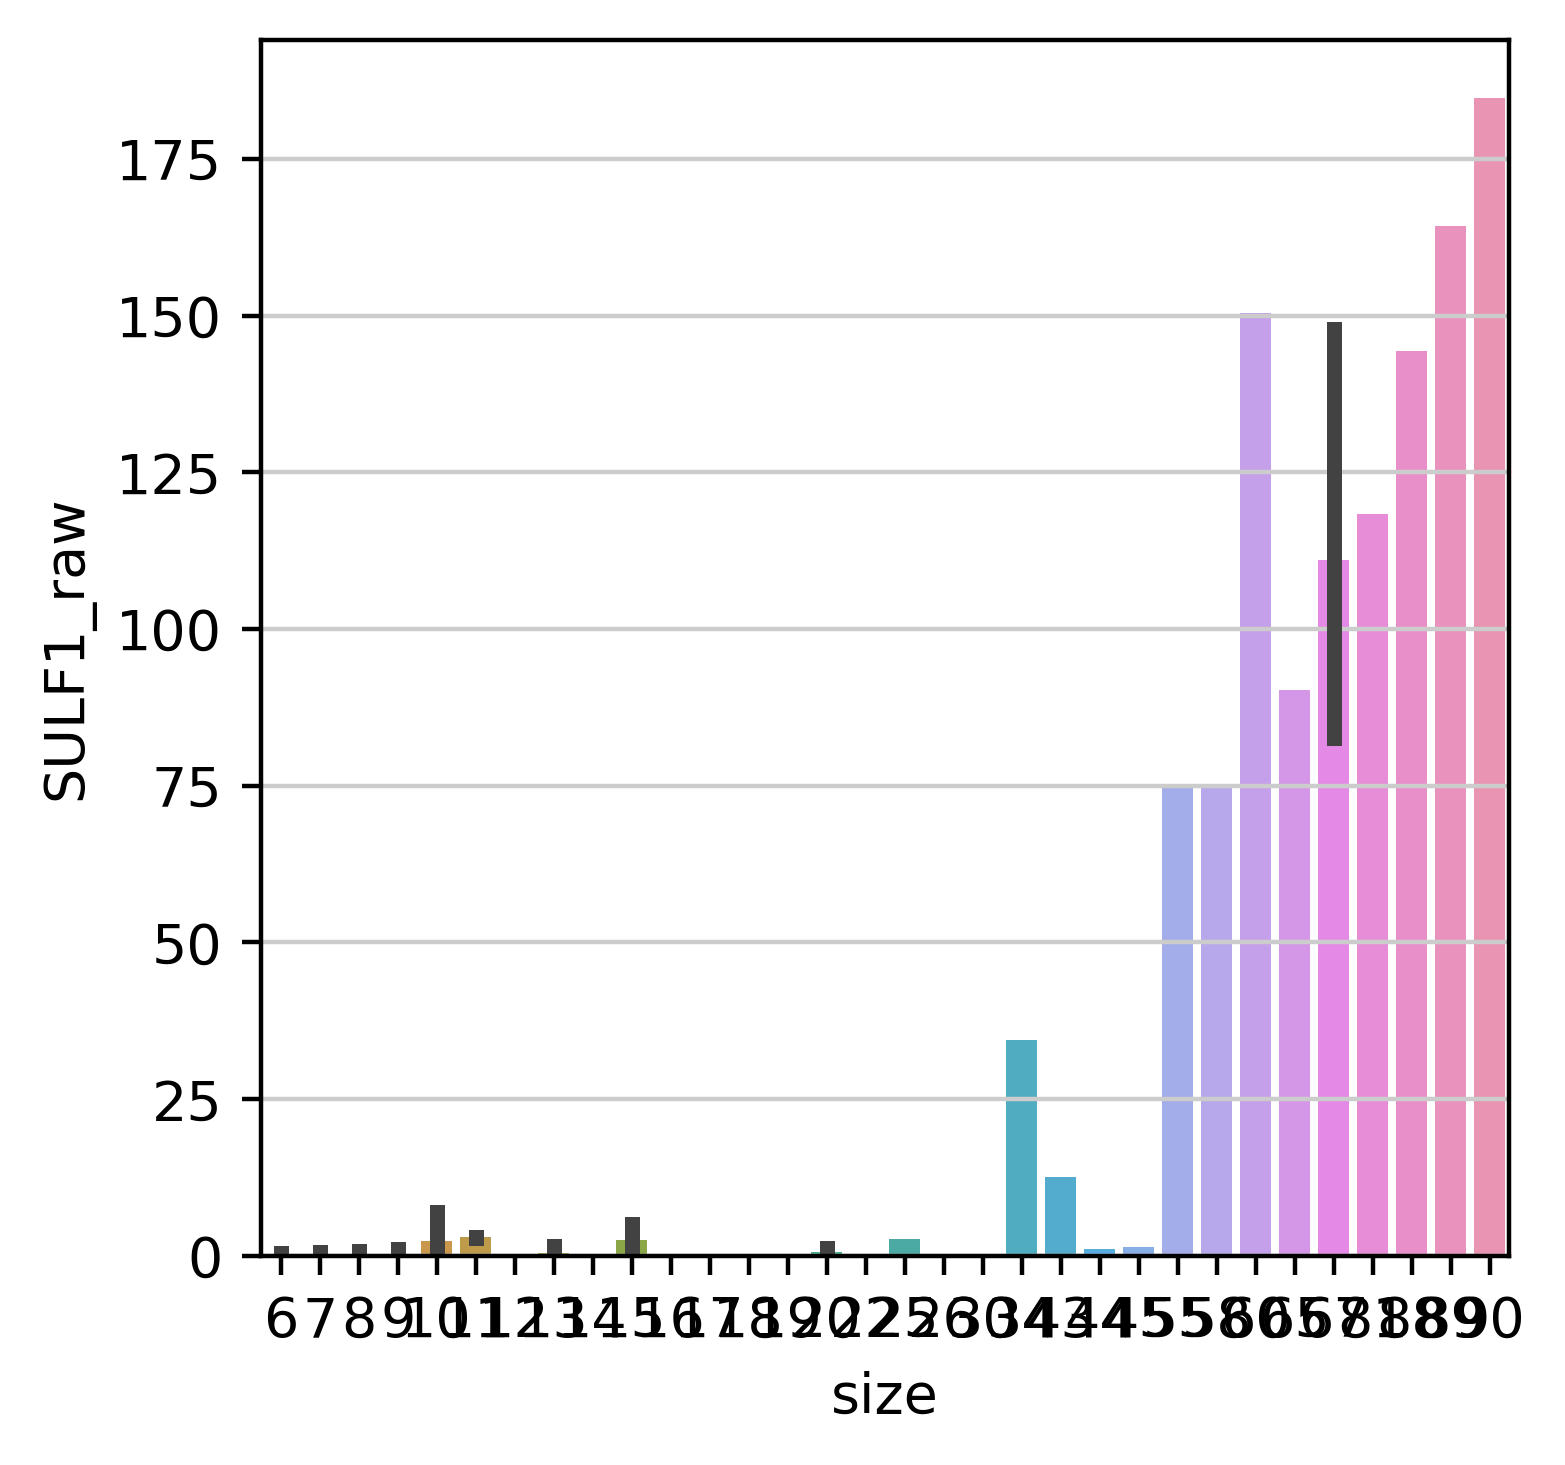

In [190]:
sns.barplot(
    data=df,
    x="size", y="SULF1_raw",
)


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anacon

<AxesSubplot:xlabel='size', ylabel='SULF1'>

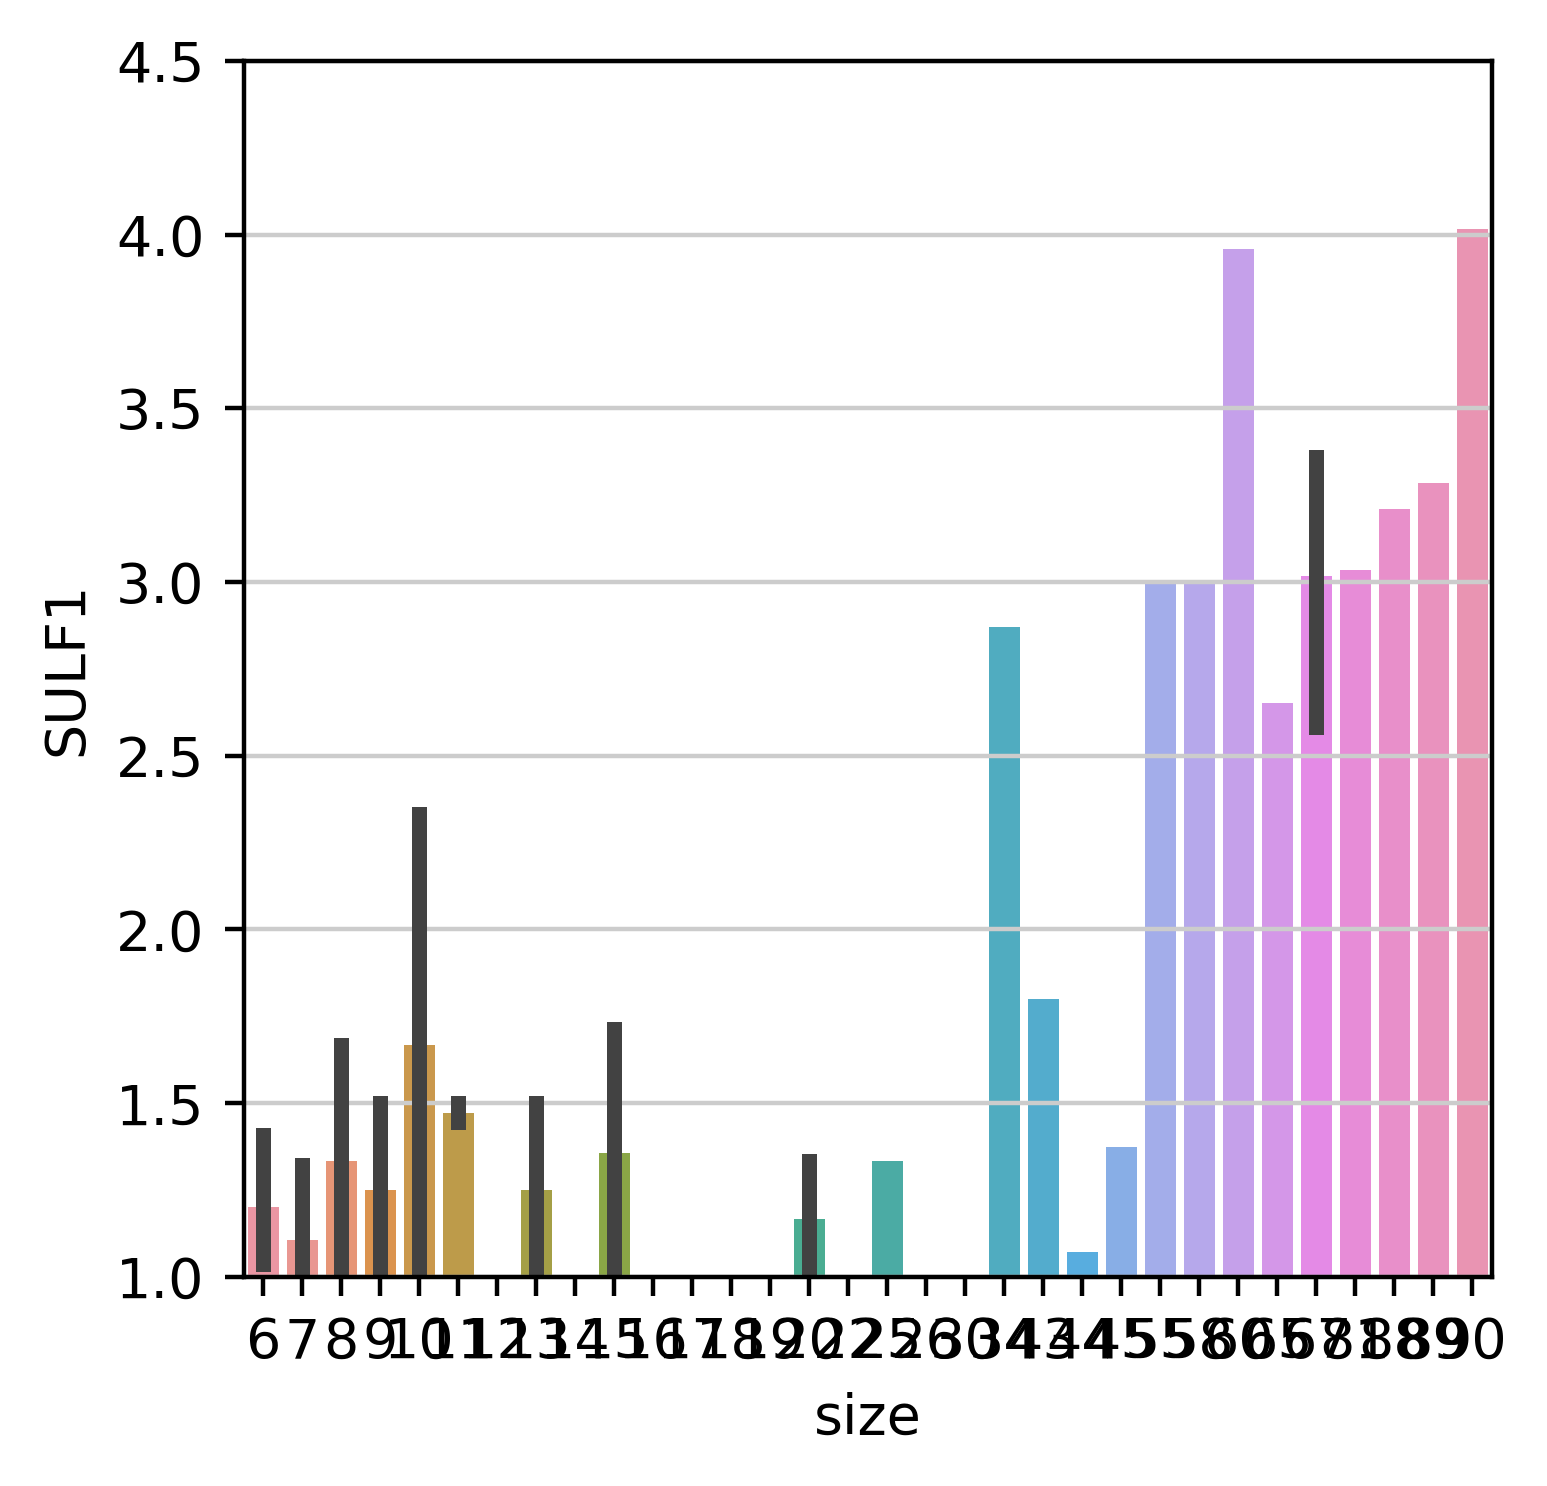

In [193]:
plt.ylim(1,4.5)

sns.barplot(
    data=df,
    x="size", y="SULF1",
)


In [41]:
df

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  \
ROI_A1-1_1                    0       0.000000        0.0000       NaN   
ROI_A1-1_12                   0       0.000000        0.0625  1.000000   
ROI_A1-1_5                    0       0.000000        0.0000       NaN   
ROI_A1-2_0                    0       0.481481        0.0000  3.034483   
ROI_A1-2_4                    0       0.166667        0.0000  1.333333   
...                         ...            ...           ...       ...   
ROI_D2-1_98                   0       0.200000        0.0000  1.714286   
ROI_D2-2_3                    0       0.000000        0.0000  1.000000   
ROI_D2-3_1                    0       0.000000        0.0000       NaN   
ROI_D2-3_24                   0       0.000000        0.0000  1.000000   
ROI_D2-3_34                   0       0.000000        0.0000  1.000000   

             SULF1_log2_mean  NEBL    SEMA3G  SEMA3G_log2_mean      RGCC  \
ROI_A1-1_1               NaN   1.0  2.200000          1.137504  1.400000   
ROI_A1-1_12         0.000000   1.2  2.384615          1.253757  1.000000   
ROI_A1-1_5               NaN   1.0  2.000000          1.000000       NaN   
ROI_A1-2_0          1.601451   NaN  1.000000          0.000000       NaN   
ROI_A1-2_4          0.415038   NaN  1.000000          0.000000  1.000000   
...                      ...   ...       ...               ...       ...   
ROI_D2-1_98         0.777608   1.0  1.500000          0.584963  2.000000   
ROI_D2-2_3          0.000000   1.0  1.000000          0.000000  1.600000   
ROI_D2-3_1               NaN   1.0       NaN               NaN  1.000000   
ROI_D2-3_24         0.000000   1.0  1.000000          0.000000       NaN   
ROI_D2-3_34         0.000000   1.0  1.000000          0.000000  1.571428   

             size   ROI  group  group2  
ROI_A1-1_1     10  A1-1  Small   Small  
ROI_A1-1_12    16  A1-1  Small  Medium  
ROI_A1-1_5      7  A1-1  Small   Small  
ROI_A1-2_0     81  A1-2  Large   Large  
ROI_A1-2_4      6  A1-2  Small   Small  
...           ...   ...    ...     ...  
ROI_D2-1_98    15  D2-1  Small  Medium  
ROI_D2-2_3     14  D2-2  Small  Medium  
ROI_D2-3_1      7  D2-3  Small   Small  
ROI_D2-3_24     7  D2-3  Small   Small  
ROI_D2-3_34    12  D2-3  Small  Medium  

[90 rows x 13 columns]

In [198]:
df2 = df.melt(id_vars=['size'], value_vars=['SULF1', 'NEBL',"SEMA3G"])
df2

size variable     value
0      10    SULF1       NaN
1      16    SULF1  1.000000
2       7    SULF1       NaN
3      81    SULF1  3.034483
4       6    SULF1  1.333333
..    ...      ...       ...
265    15   SEMA3G  1.500000
266    14   SEMA3G  1.000000
267     7   SEMA3G       NaN
268     7   SEMA3G  1.000000
269    12   SEMA3G  1.000000

[270 rows x 3 columns]

In [136]:
df4 = df2.groupby(['size', 'variable']).mean()

In [276]:
df4

index  size variable     value
0       0     6     NEBL  1.214286
1       1     6   SEMA3G  1.321667
2       2     6    SULF1  1.200000
3       3     7     NEBL  1.041667
4       4     7   SEMA3G  1.300000
..    ...   ...      ...       ...
91     91    89   SEMA3G  1.000000
92     92    89    SULF1  3.285714
93     93    90     NEBL       NaN
94     94    90   SEMA3G  1.000000
95     95    90    SULF1  4.016129

[96 rows x 4 columns]

<AxesSubplot:xlabel='size', ylabel='Count'>

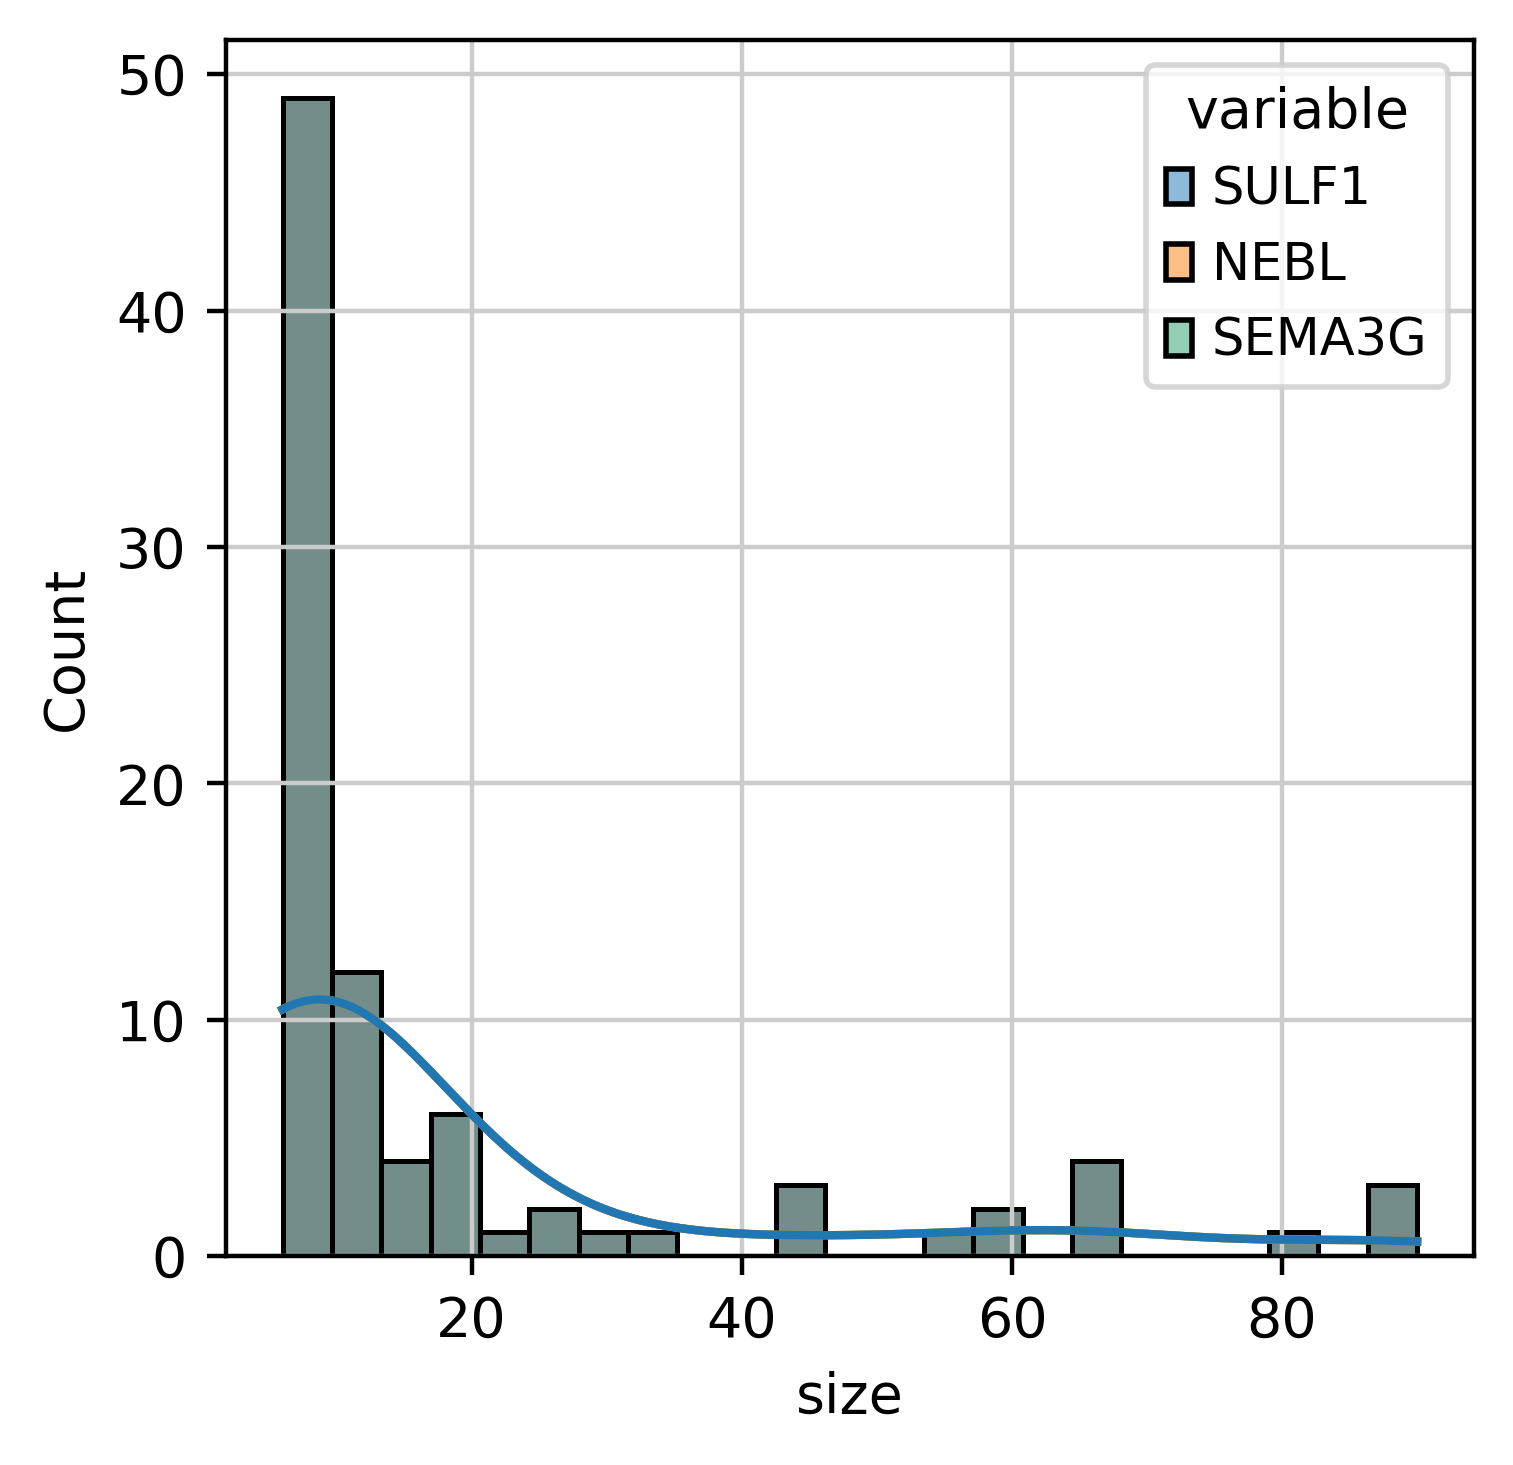

In [199]:
sns.histplot(data=df2, x = 'size', y = 'value', hue = 'variable', kde = True)

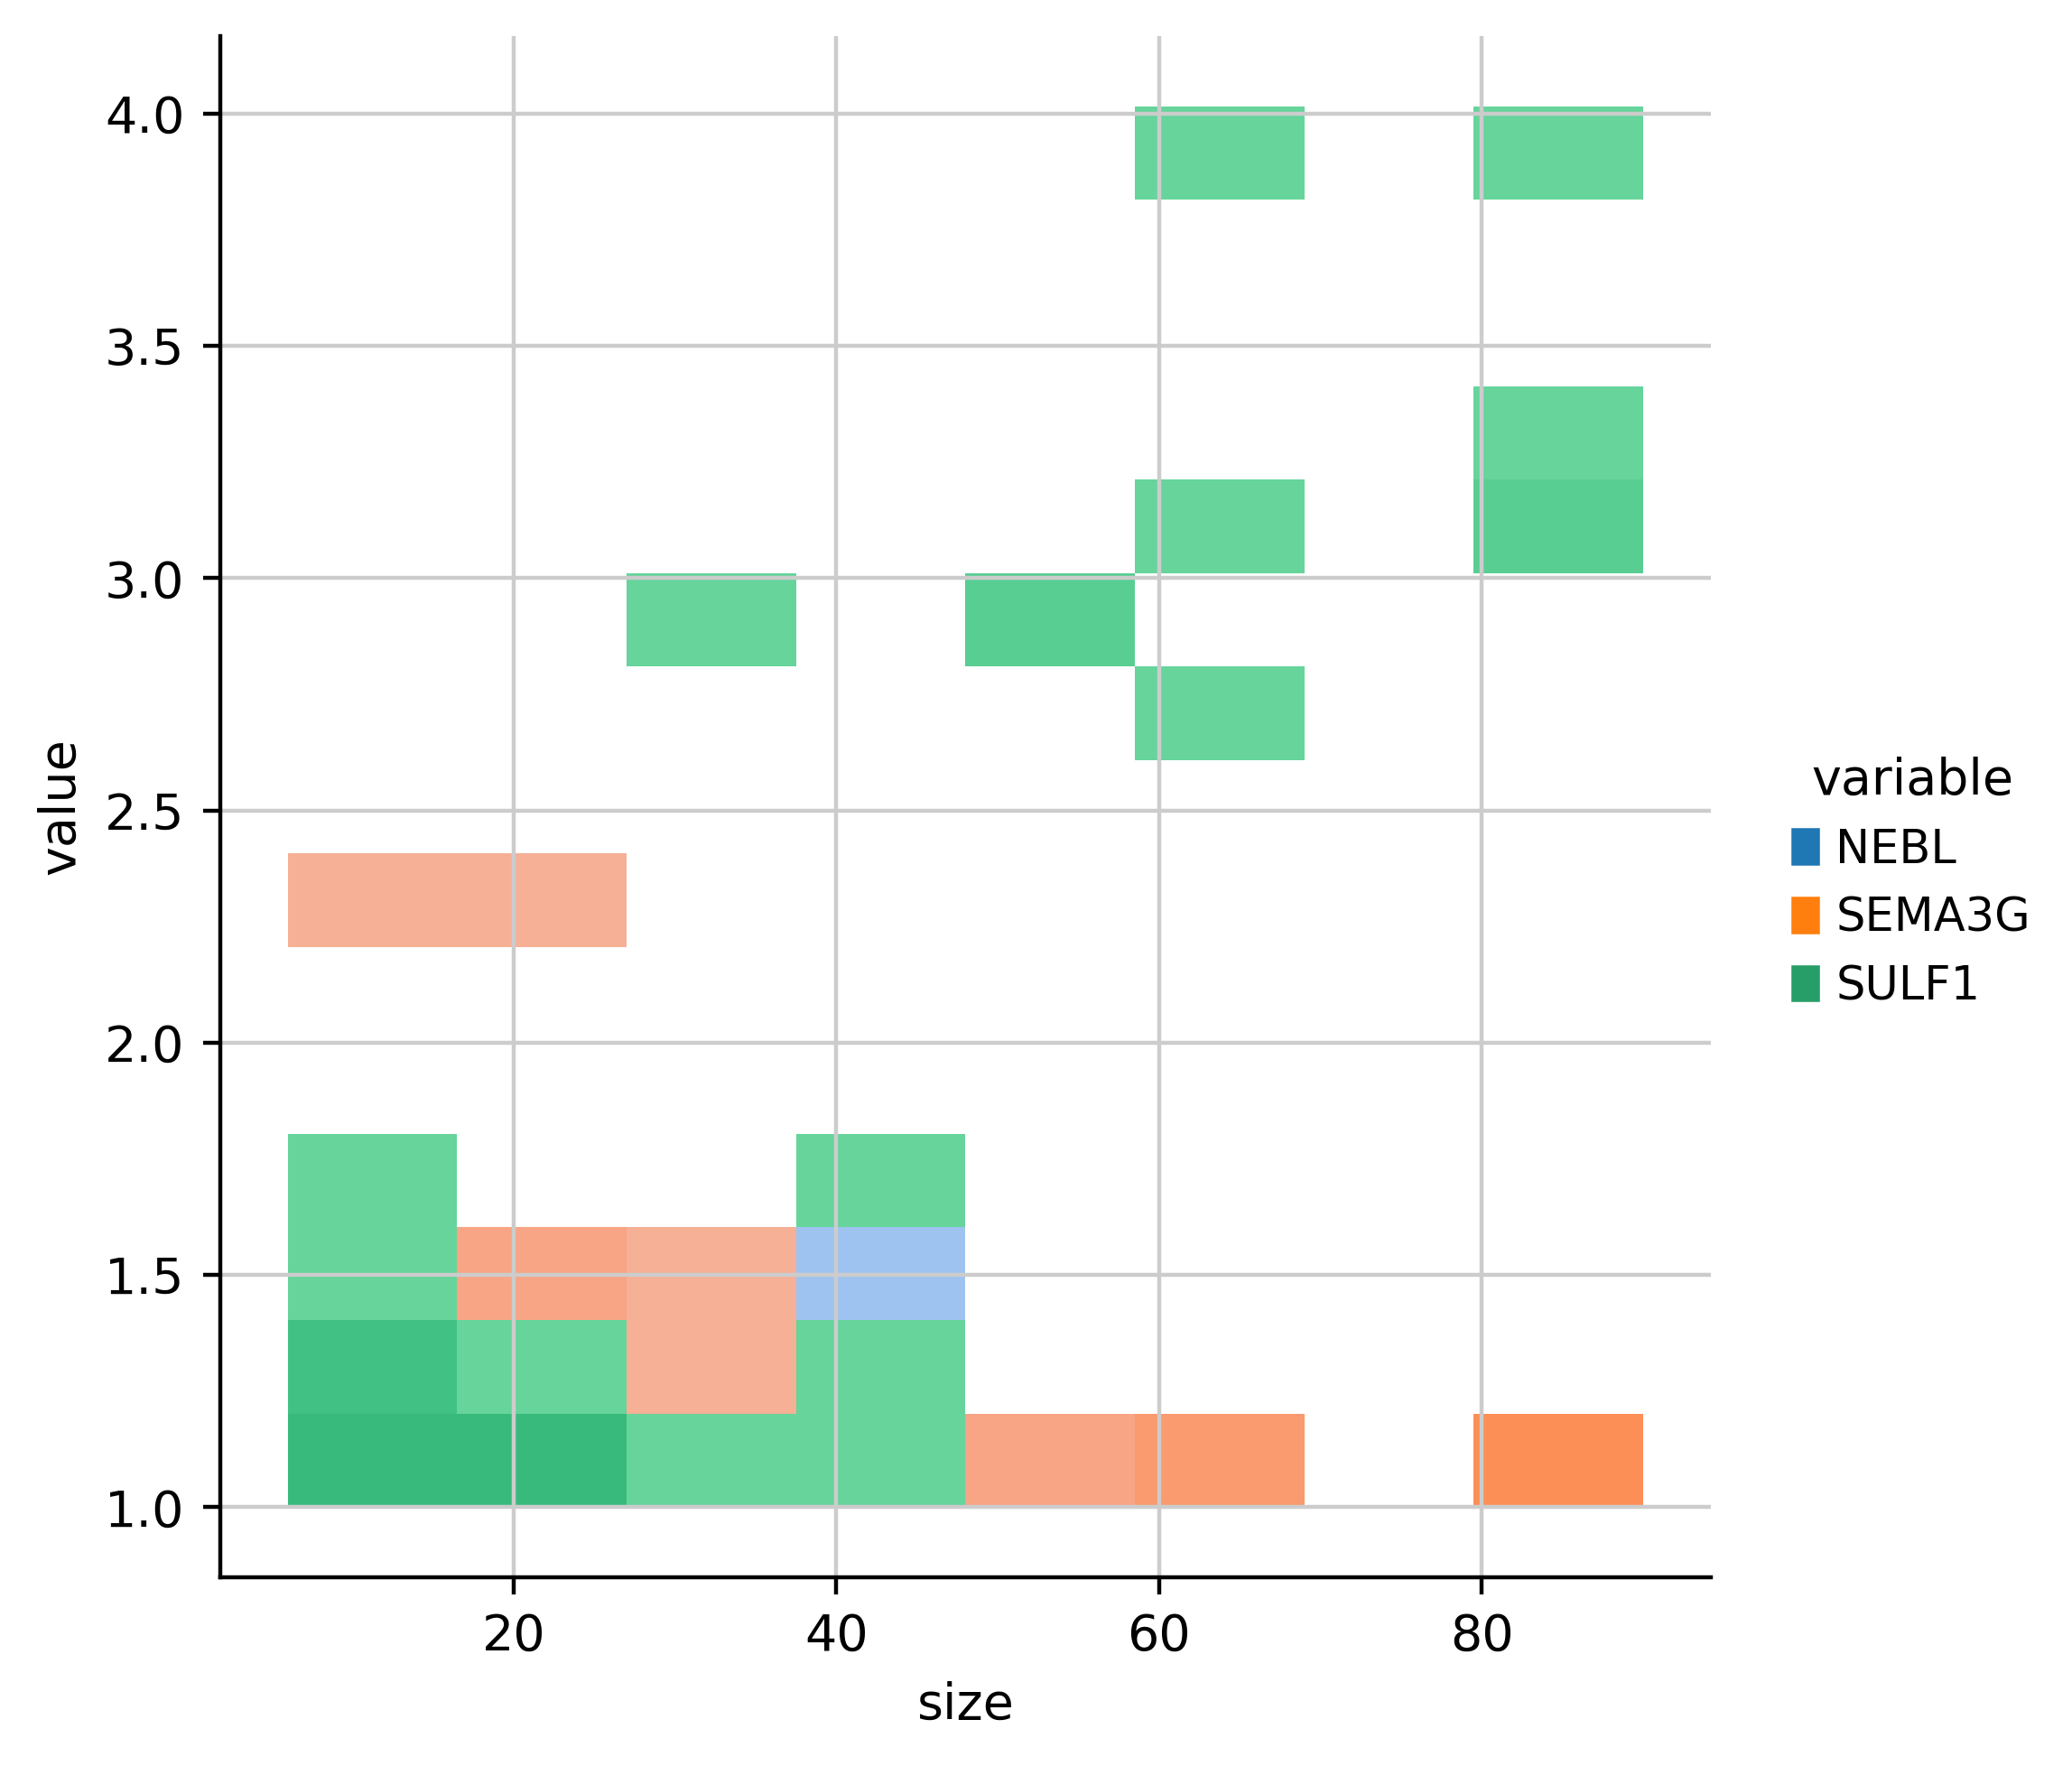

In [232]:
sns.displot(data=df4, x = 'size', y = 'value', hue = 'variable', kind = 'hist')

In [263]:
df4.reset_index()

size variable     value
0      6     NEBL  1.214286
1      6   SEMA3G  1.321667
2      6    SULF1  1.200000
3      7     NEBL  1.041667
4      7   SEMA3G  1.300000
..   ...      ...       ...
91    89   SEMA3G  1.000000
92    89    SULF1  3.285714
93    90     NEBL       NaN
94    90   SEMA3G  1.000000
95    90    SULF1  4.016129

[96 rows x 3 columns]

In [270]:
df4.reset_index(inplace = True)
df4

index  size variable     value
0       0     6     NEBL  1.214286
1       1     6   SEMA3G  1.321667
2       2     6    SULF1  1.200000
3       3     7     NEBL  1.041667
4       4     7   SEMA3G  1.300000
..    ...   ...      ...       ...
91     91    89   SEMA3G  1.000000
92     92    89    SULF1  3.285714
93     93    90     NEBL       NaN
94     94    90   SEMA3G  1.000000
95     95    90    SULF1  4.016129

[96 rows x 4 columns]

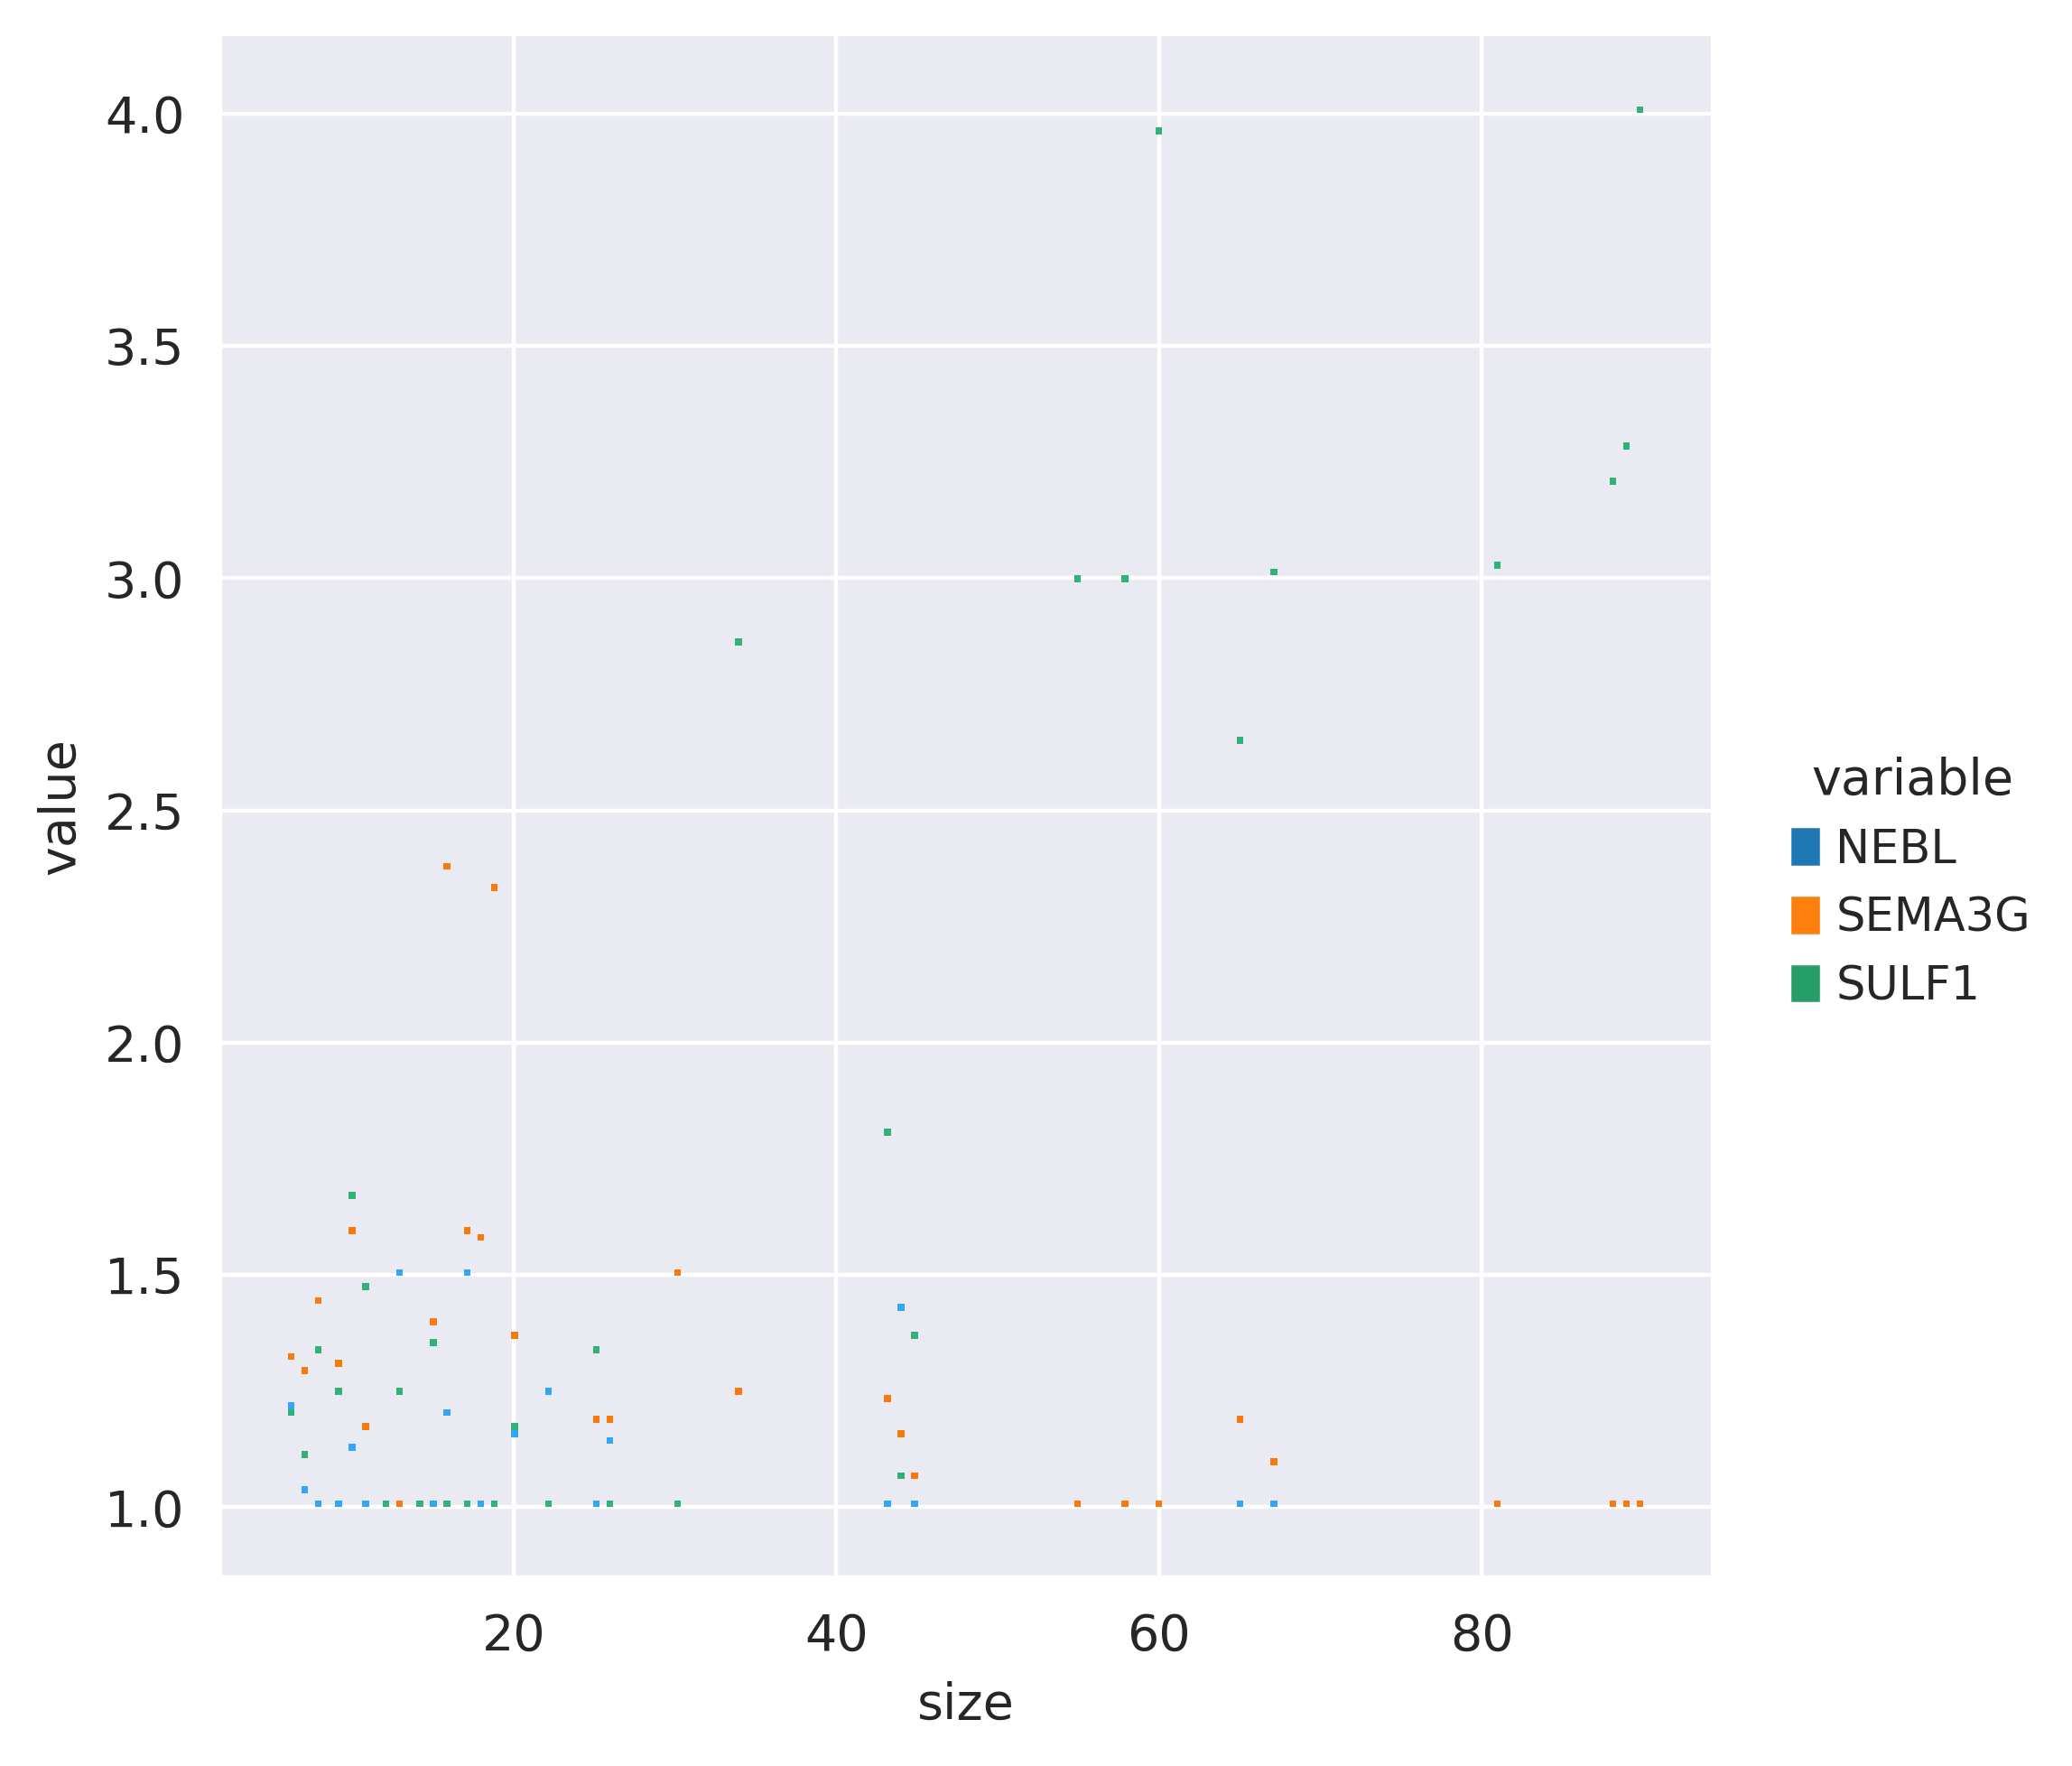

In [294]:
sns.displot(data = df4, x = 'size', y = 'value', hue = 'variable', bins = 200)

In [295]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 5))
sns.distplot(data=df4, x = 'size', y = 'value', hue = 'variable', hist=True, bins=np.arange(min(b)-0.5, max(b)+1, 1))
plt.xticks(np.arange(min(b), max(b) + 1, 1))
plt.xlabel('size', fontsize=12)
plt.title('value', fontsize=20)
plt.xlim(min(b), max(b) + 1)
plt.show()

NameError: name 'b' is not defined

<Figure size 3000x1000 with 0 Axes>

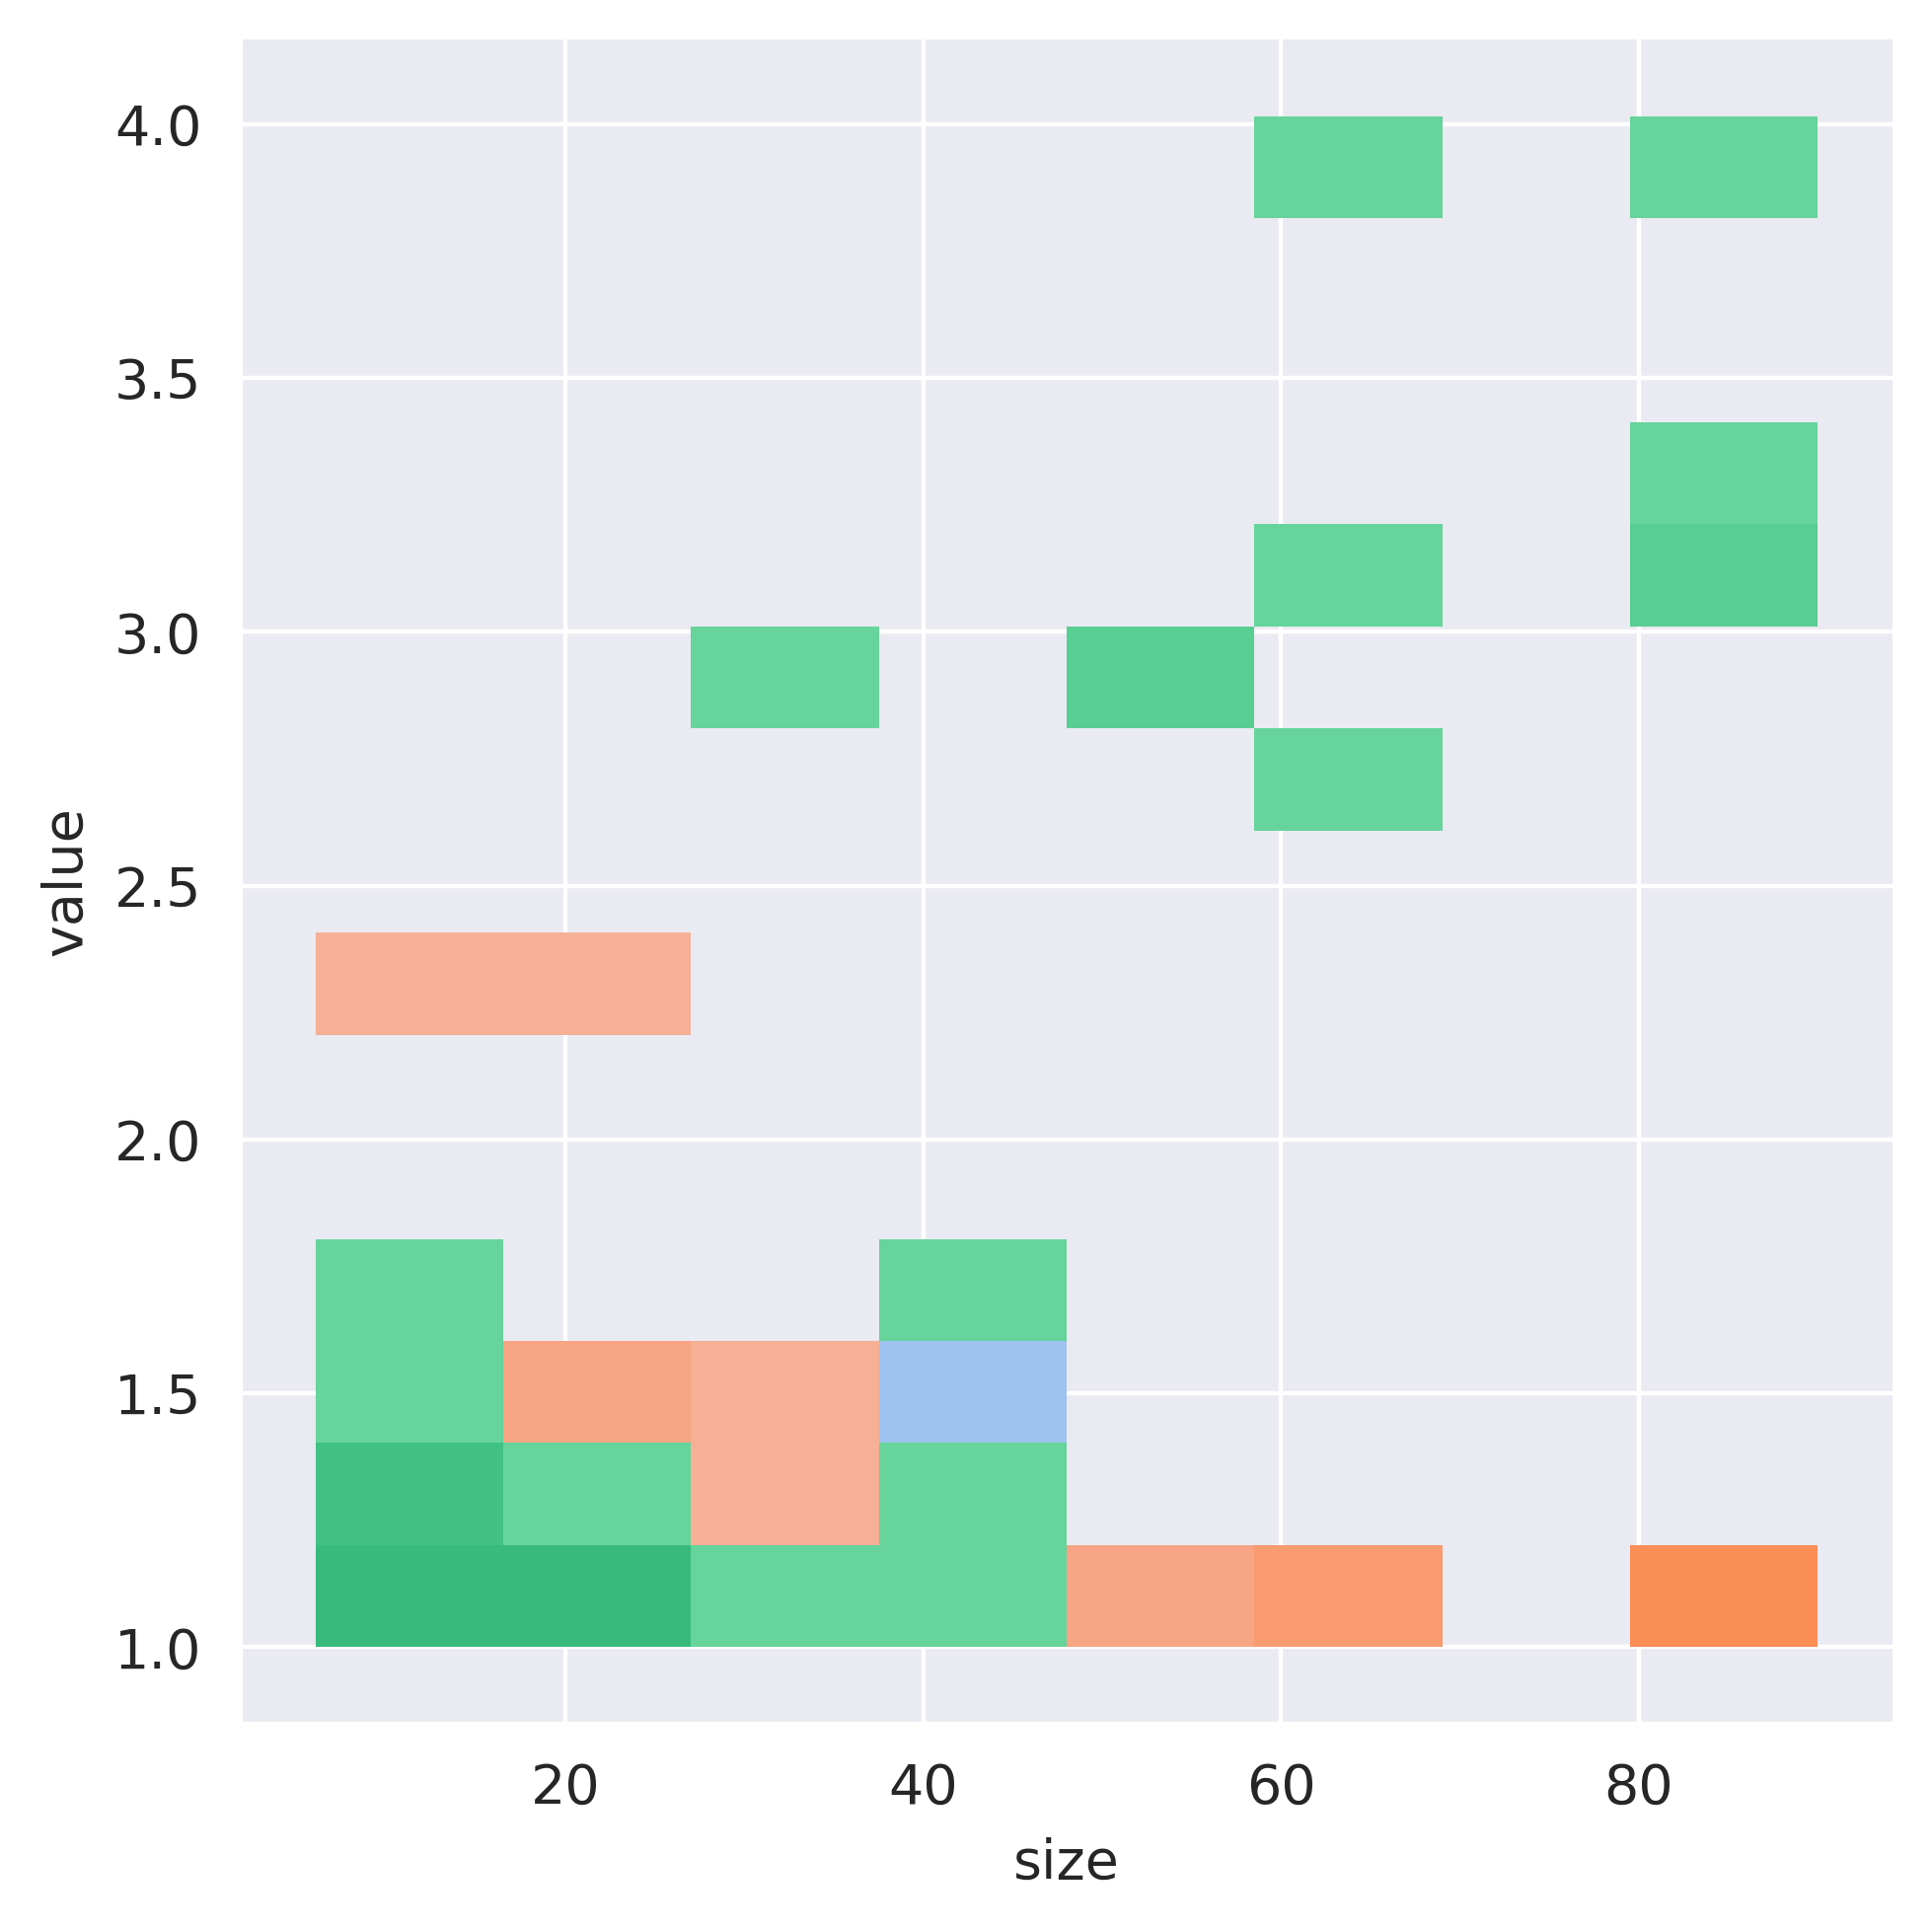

In [273]:
sns.displot(data=df4, x = 'size', y = 'value', hue = 'variable', legend = False, kind = 'hist')

In [ ]:
sns.distplot(target_1[['sepal length (cm)']], hist=False, rug=True)
sns.distplot(target_2[['sepal length (cm)']], hist=False, rug=True)

plt.show()


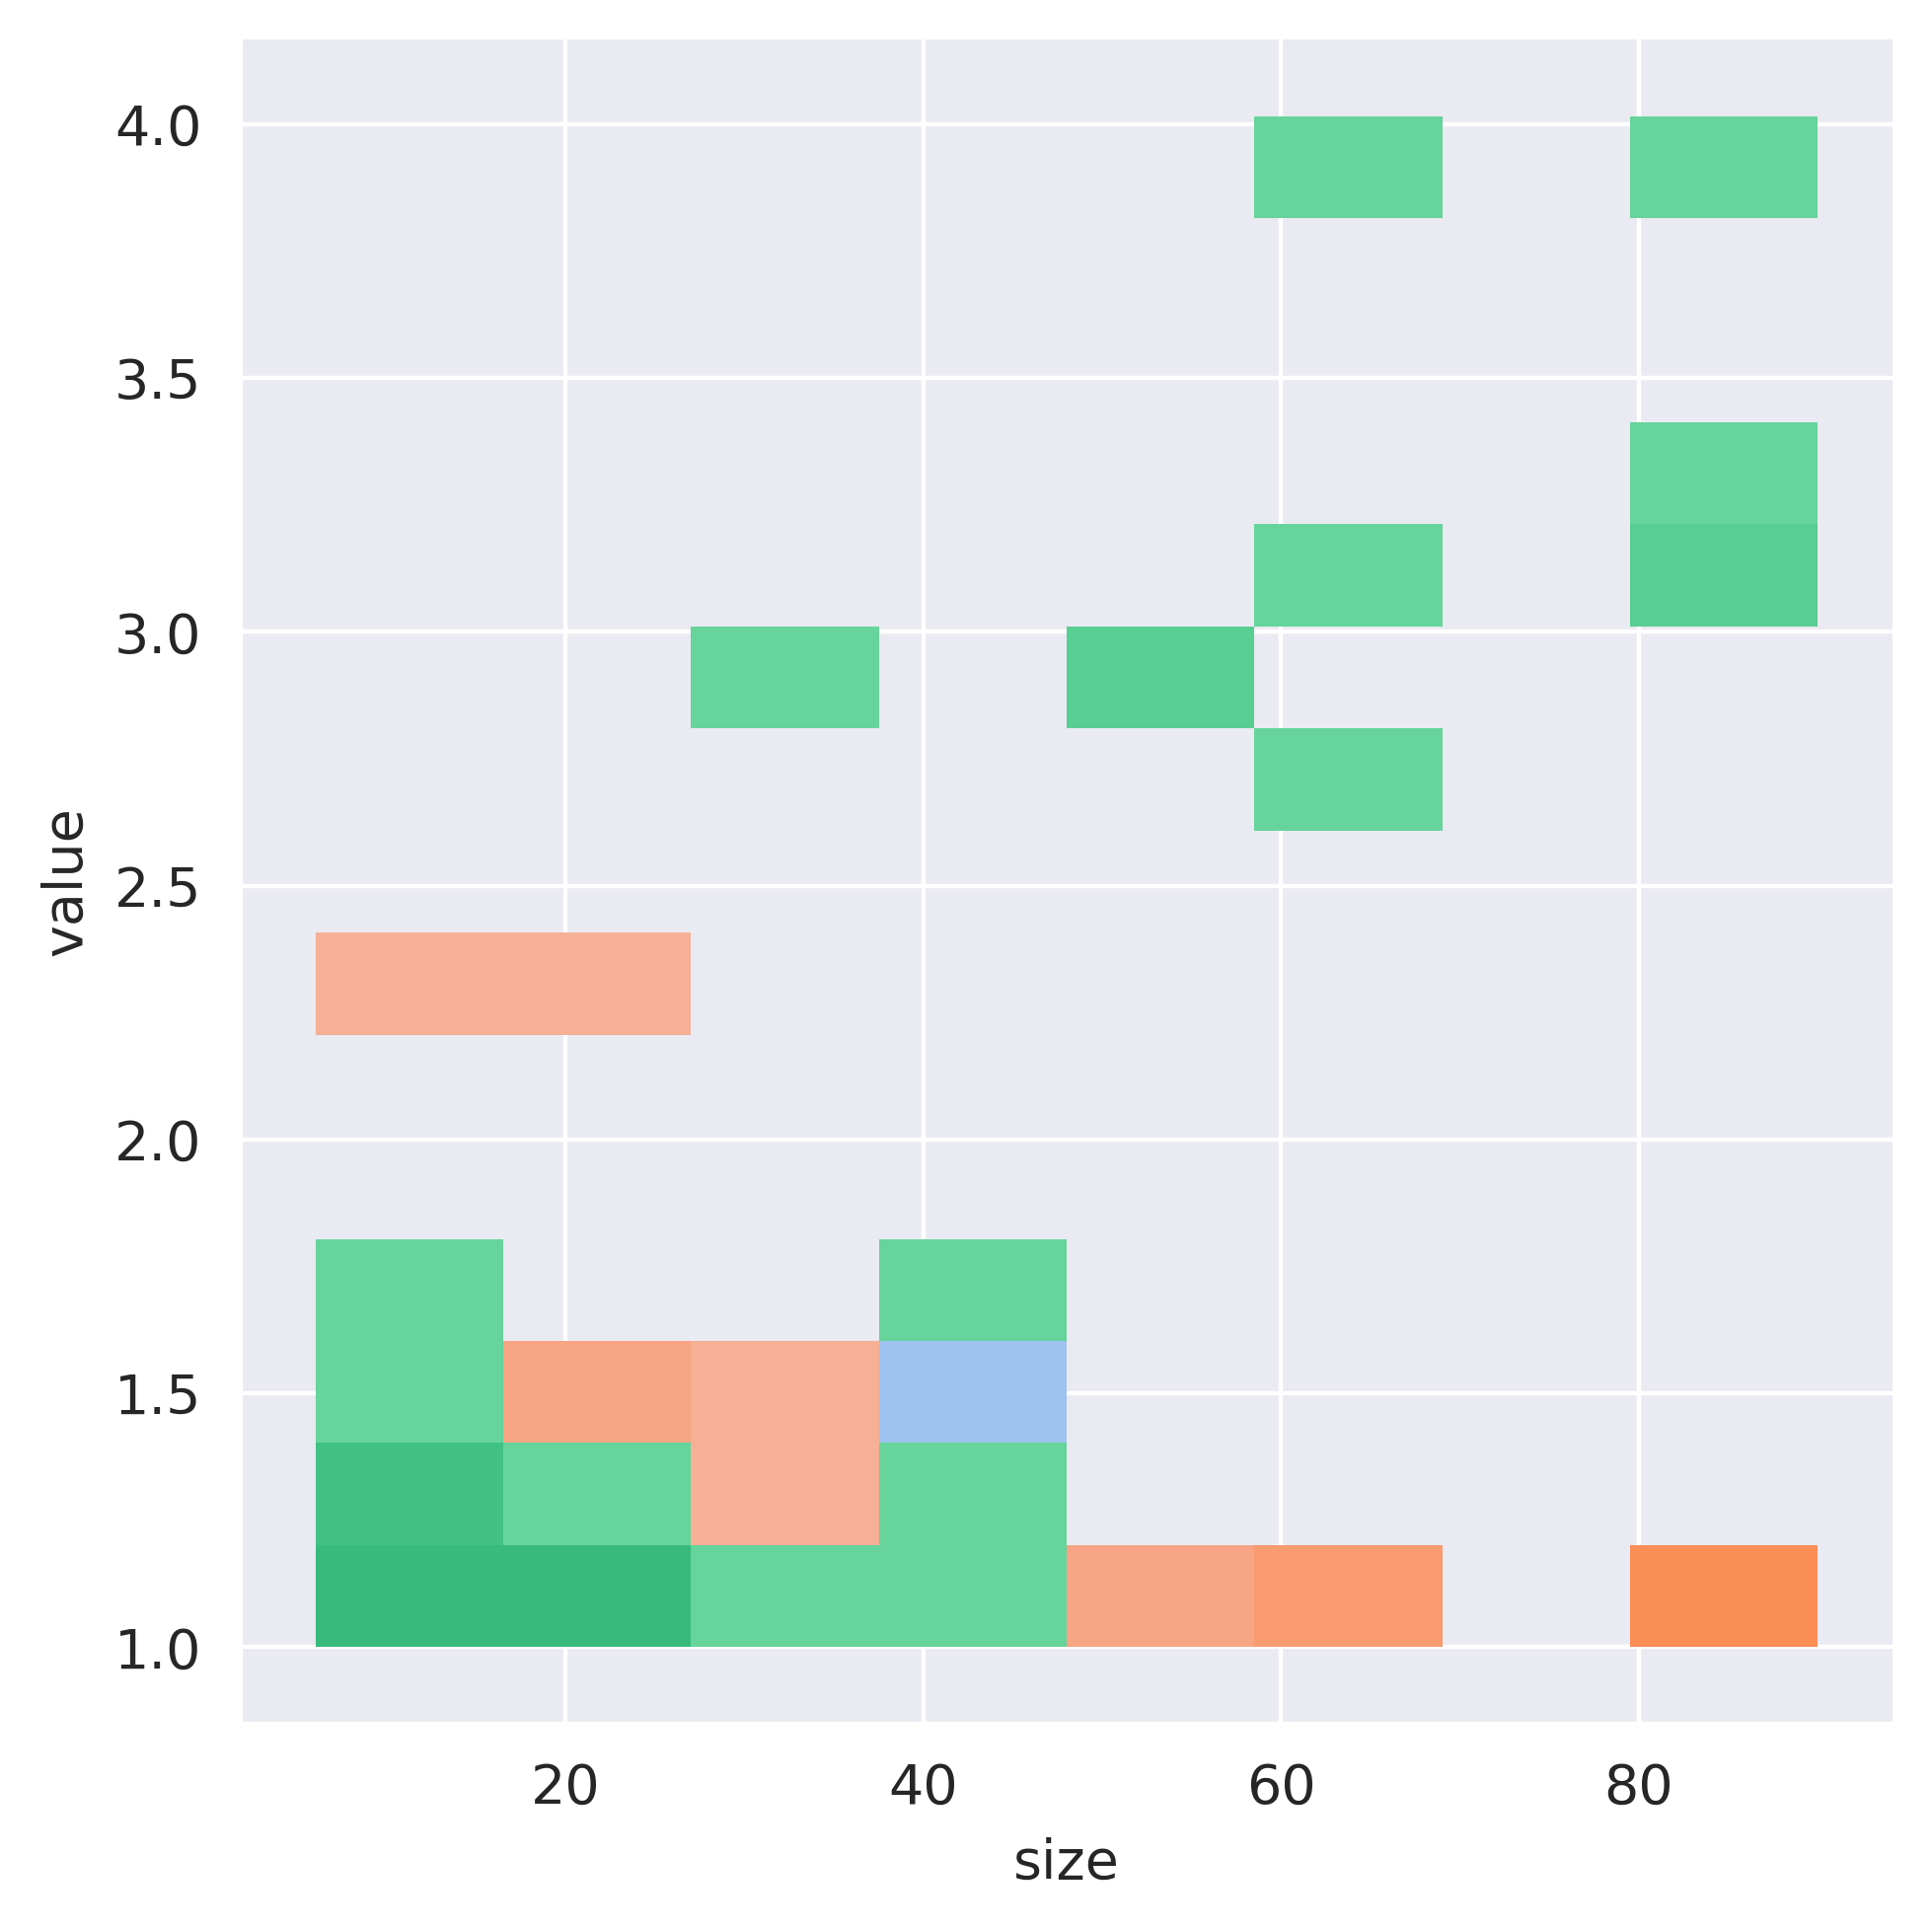

In [266]:
sns.displot(data=df4, x = 'size', y = 'value', hue = 'variable', legend = False)

<AxesSubplot:xlabel='size', ylabel='value'>

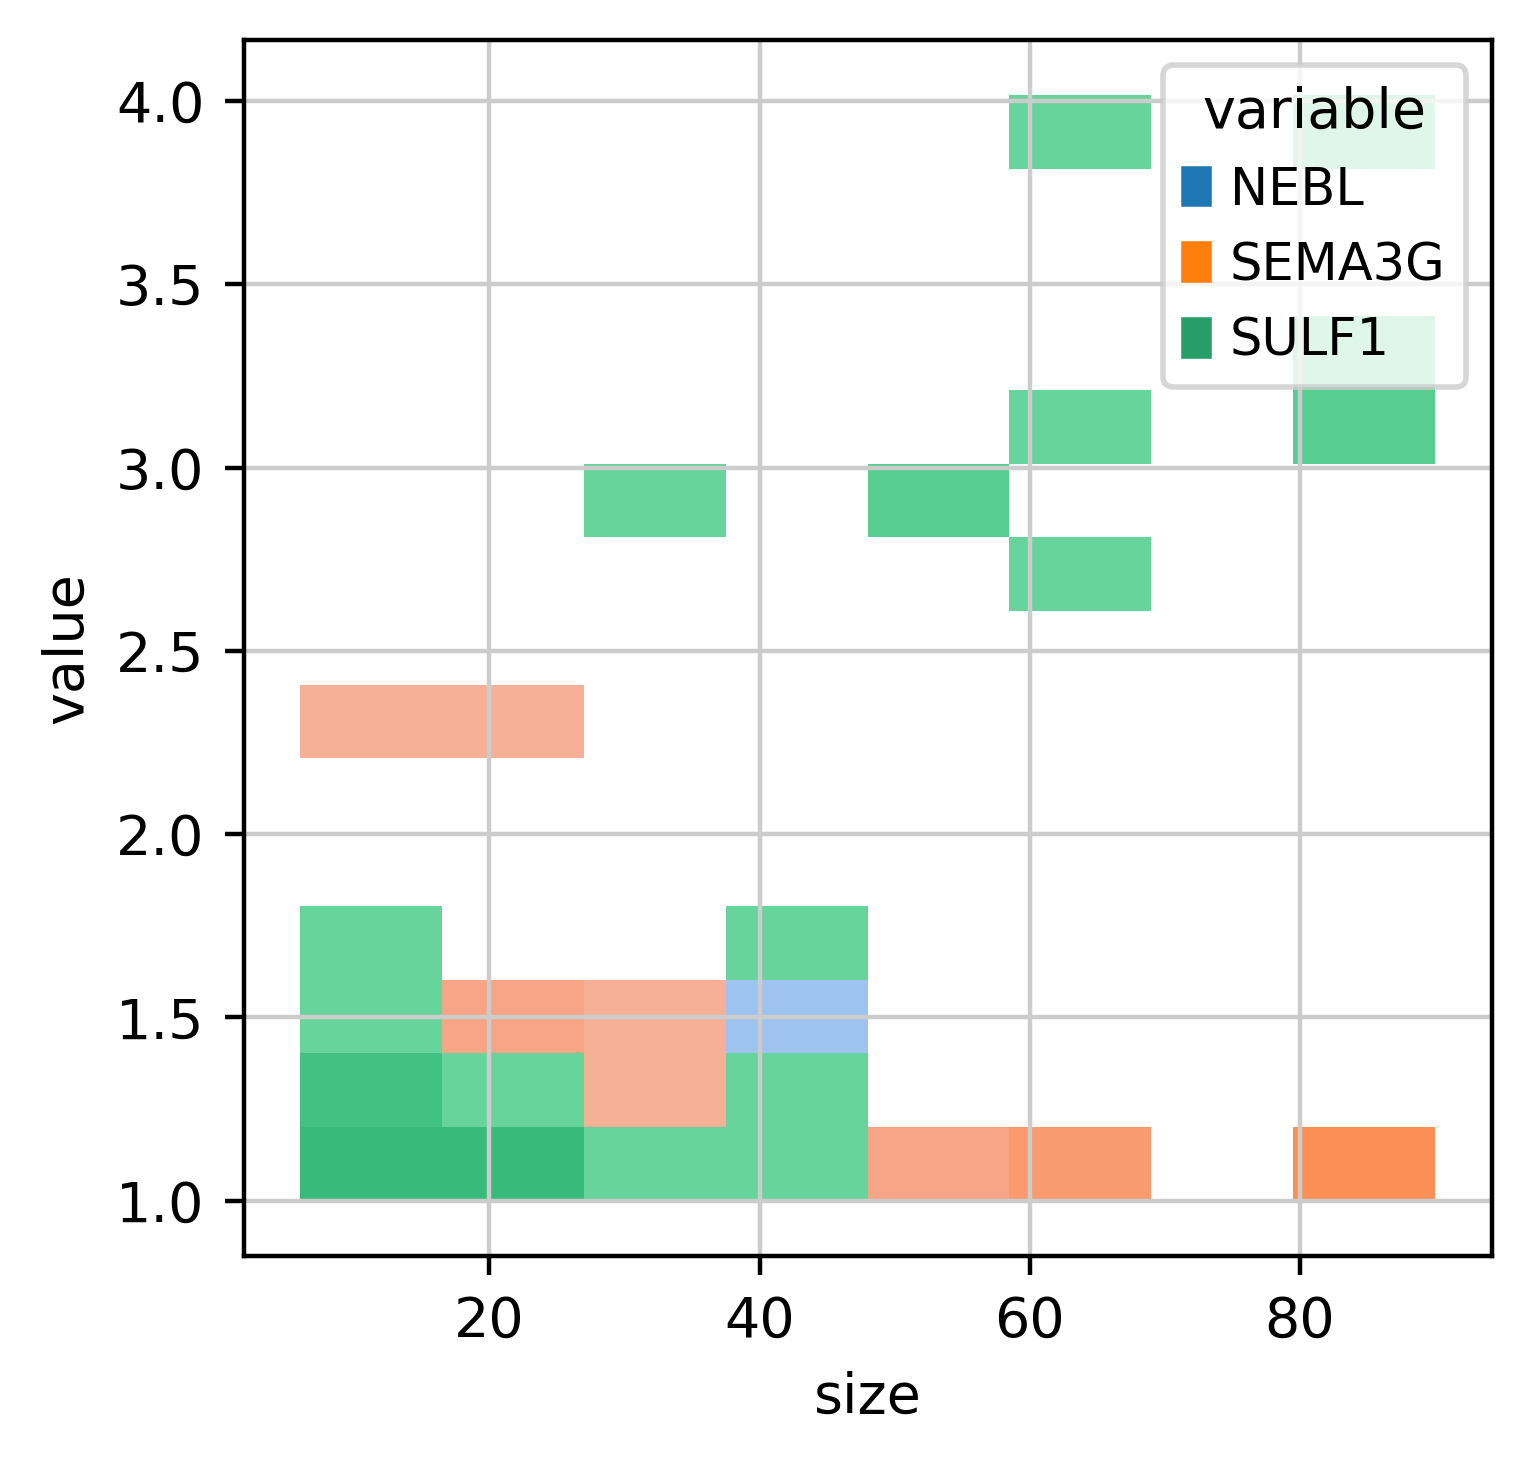

In [143]:
sns.histplot(data=df4, x = 'size', y = 'value', hue = 'variable')

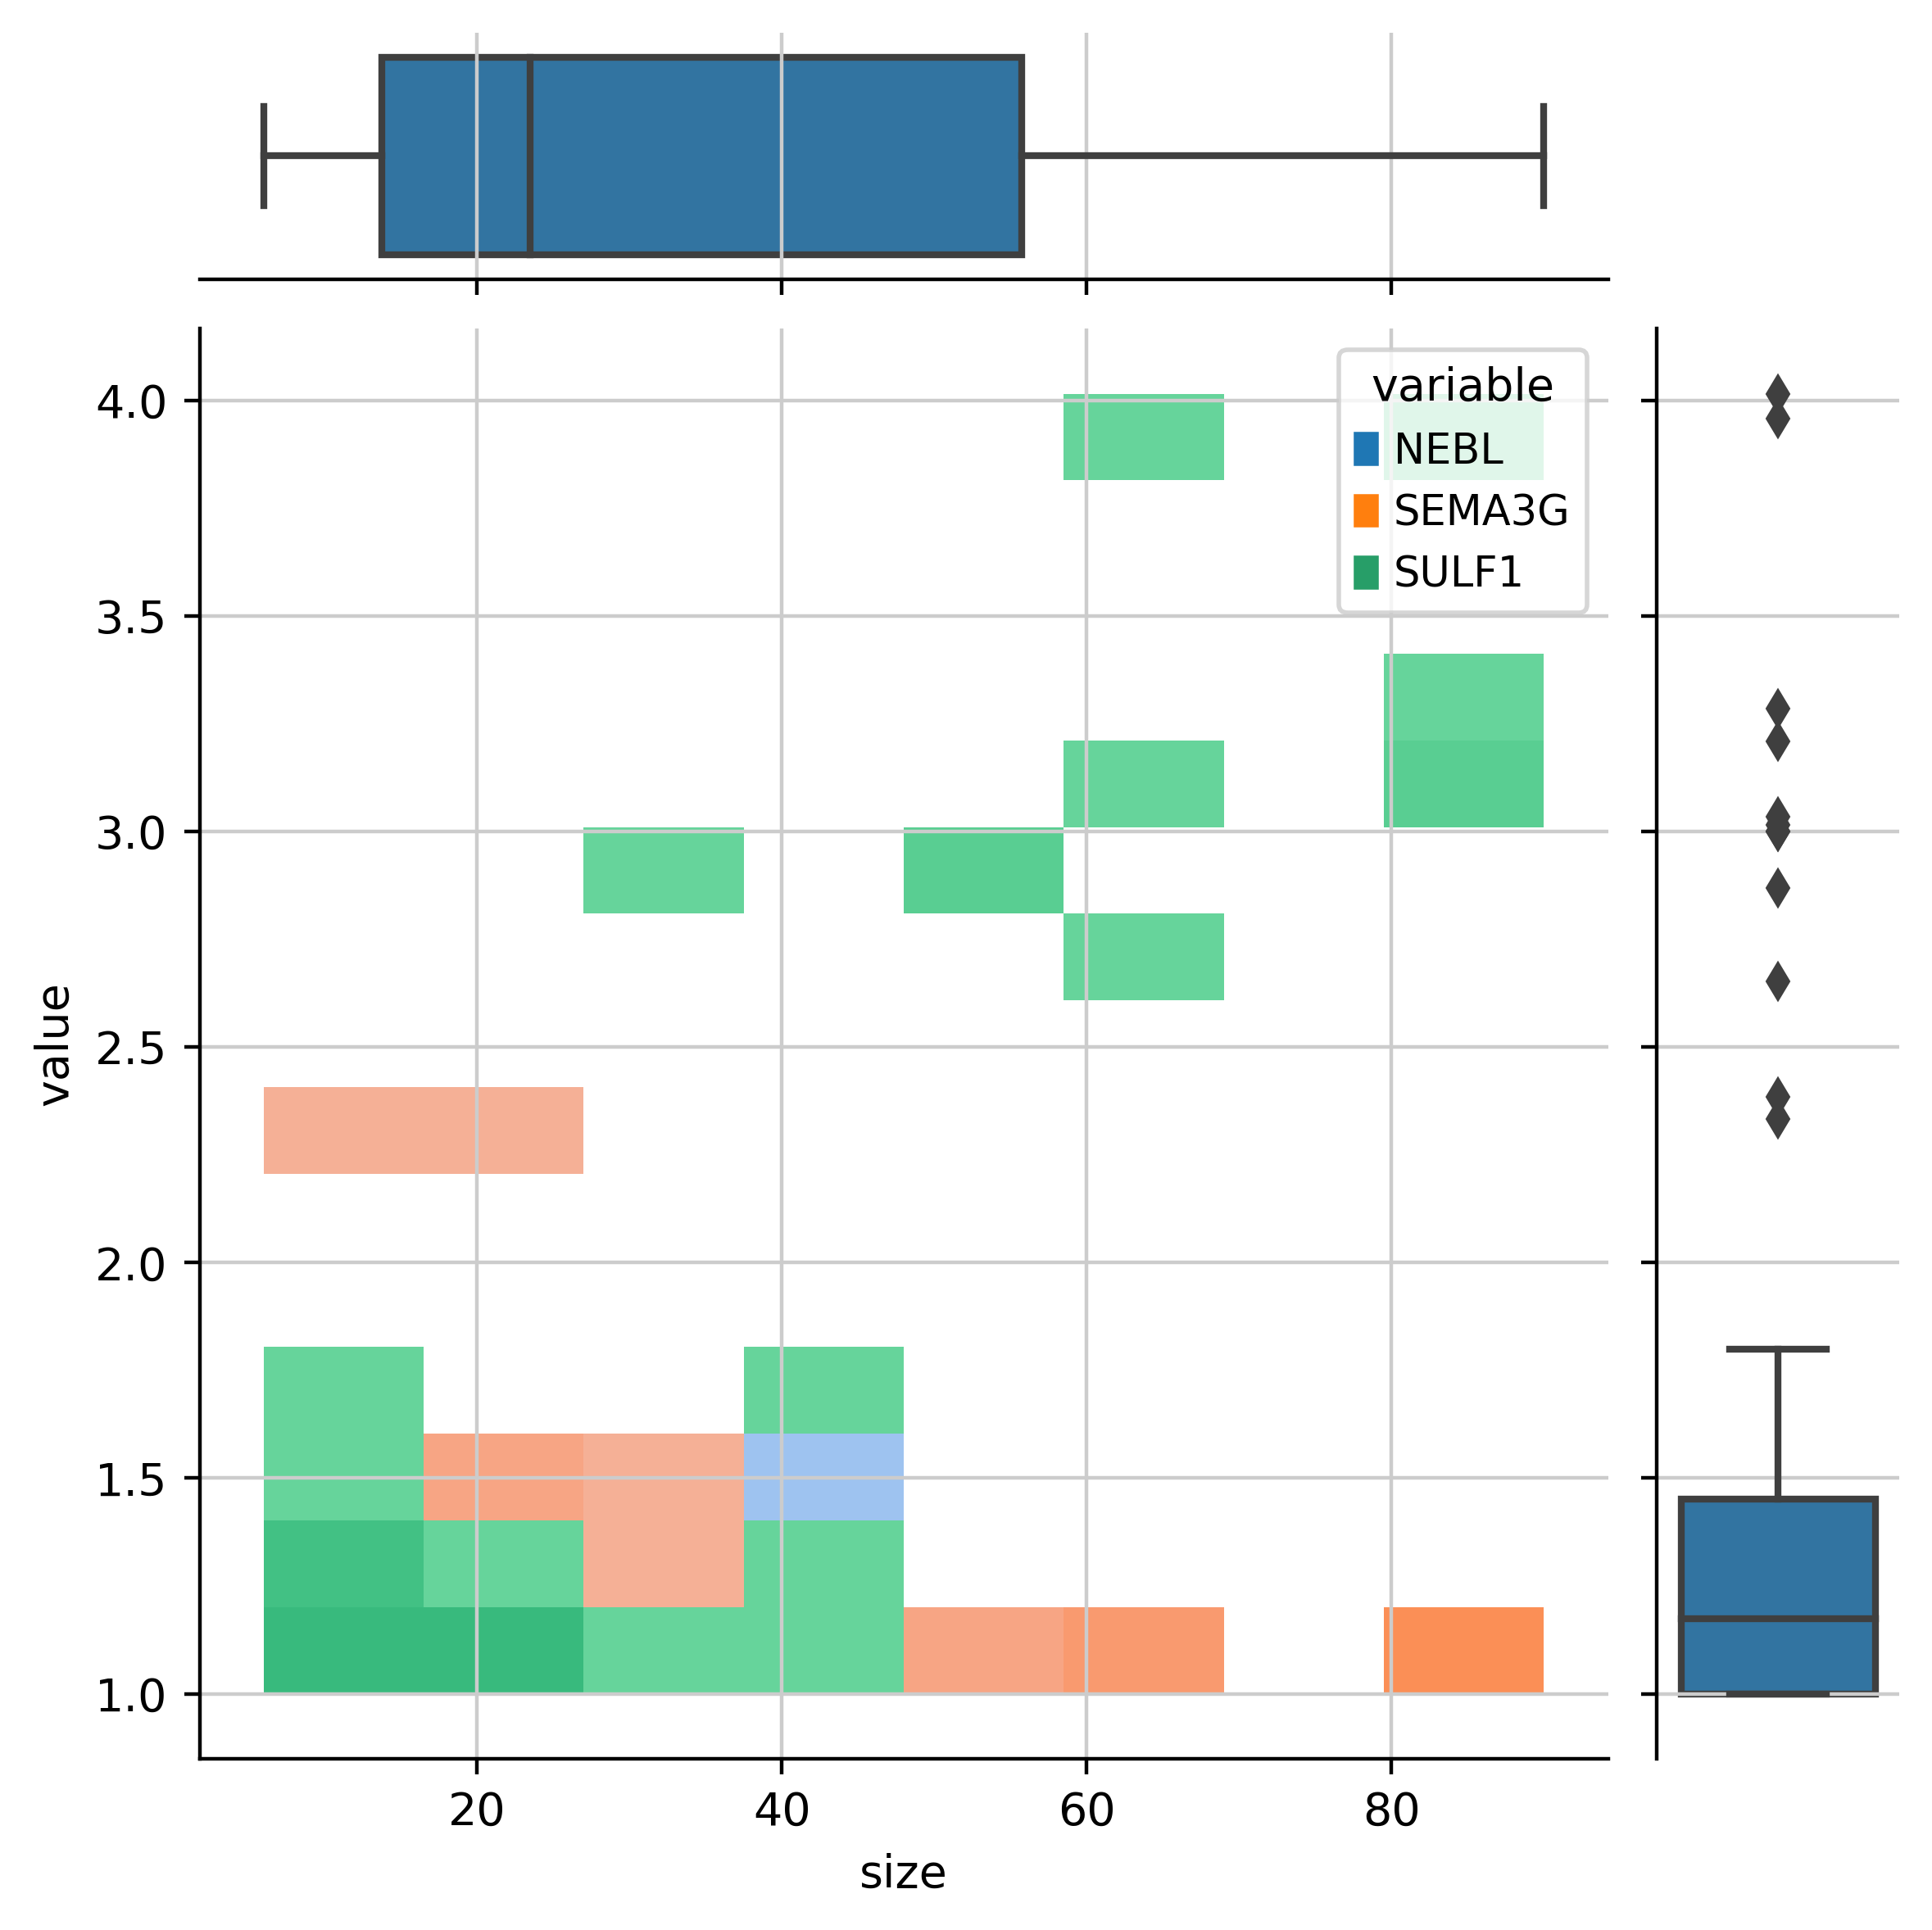

In [128]:
g = sns.JointGrid(data=df4, x="size", y="value", hue = 'variable')
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

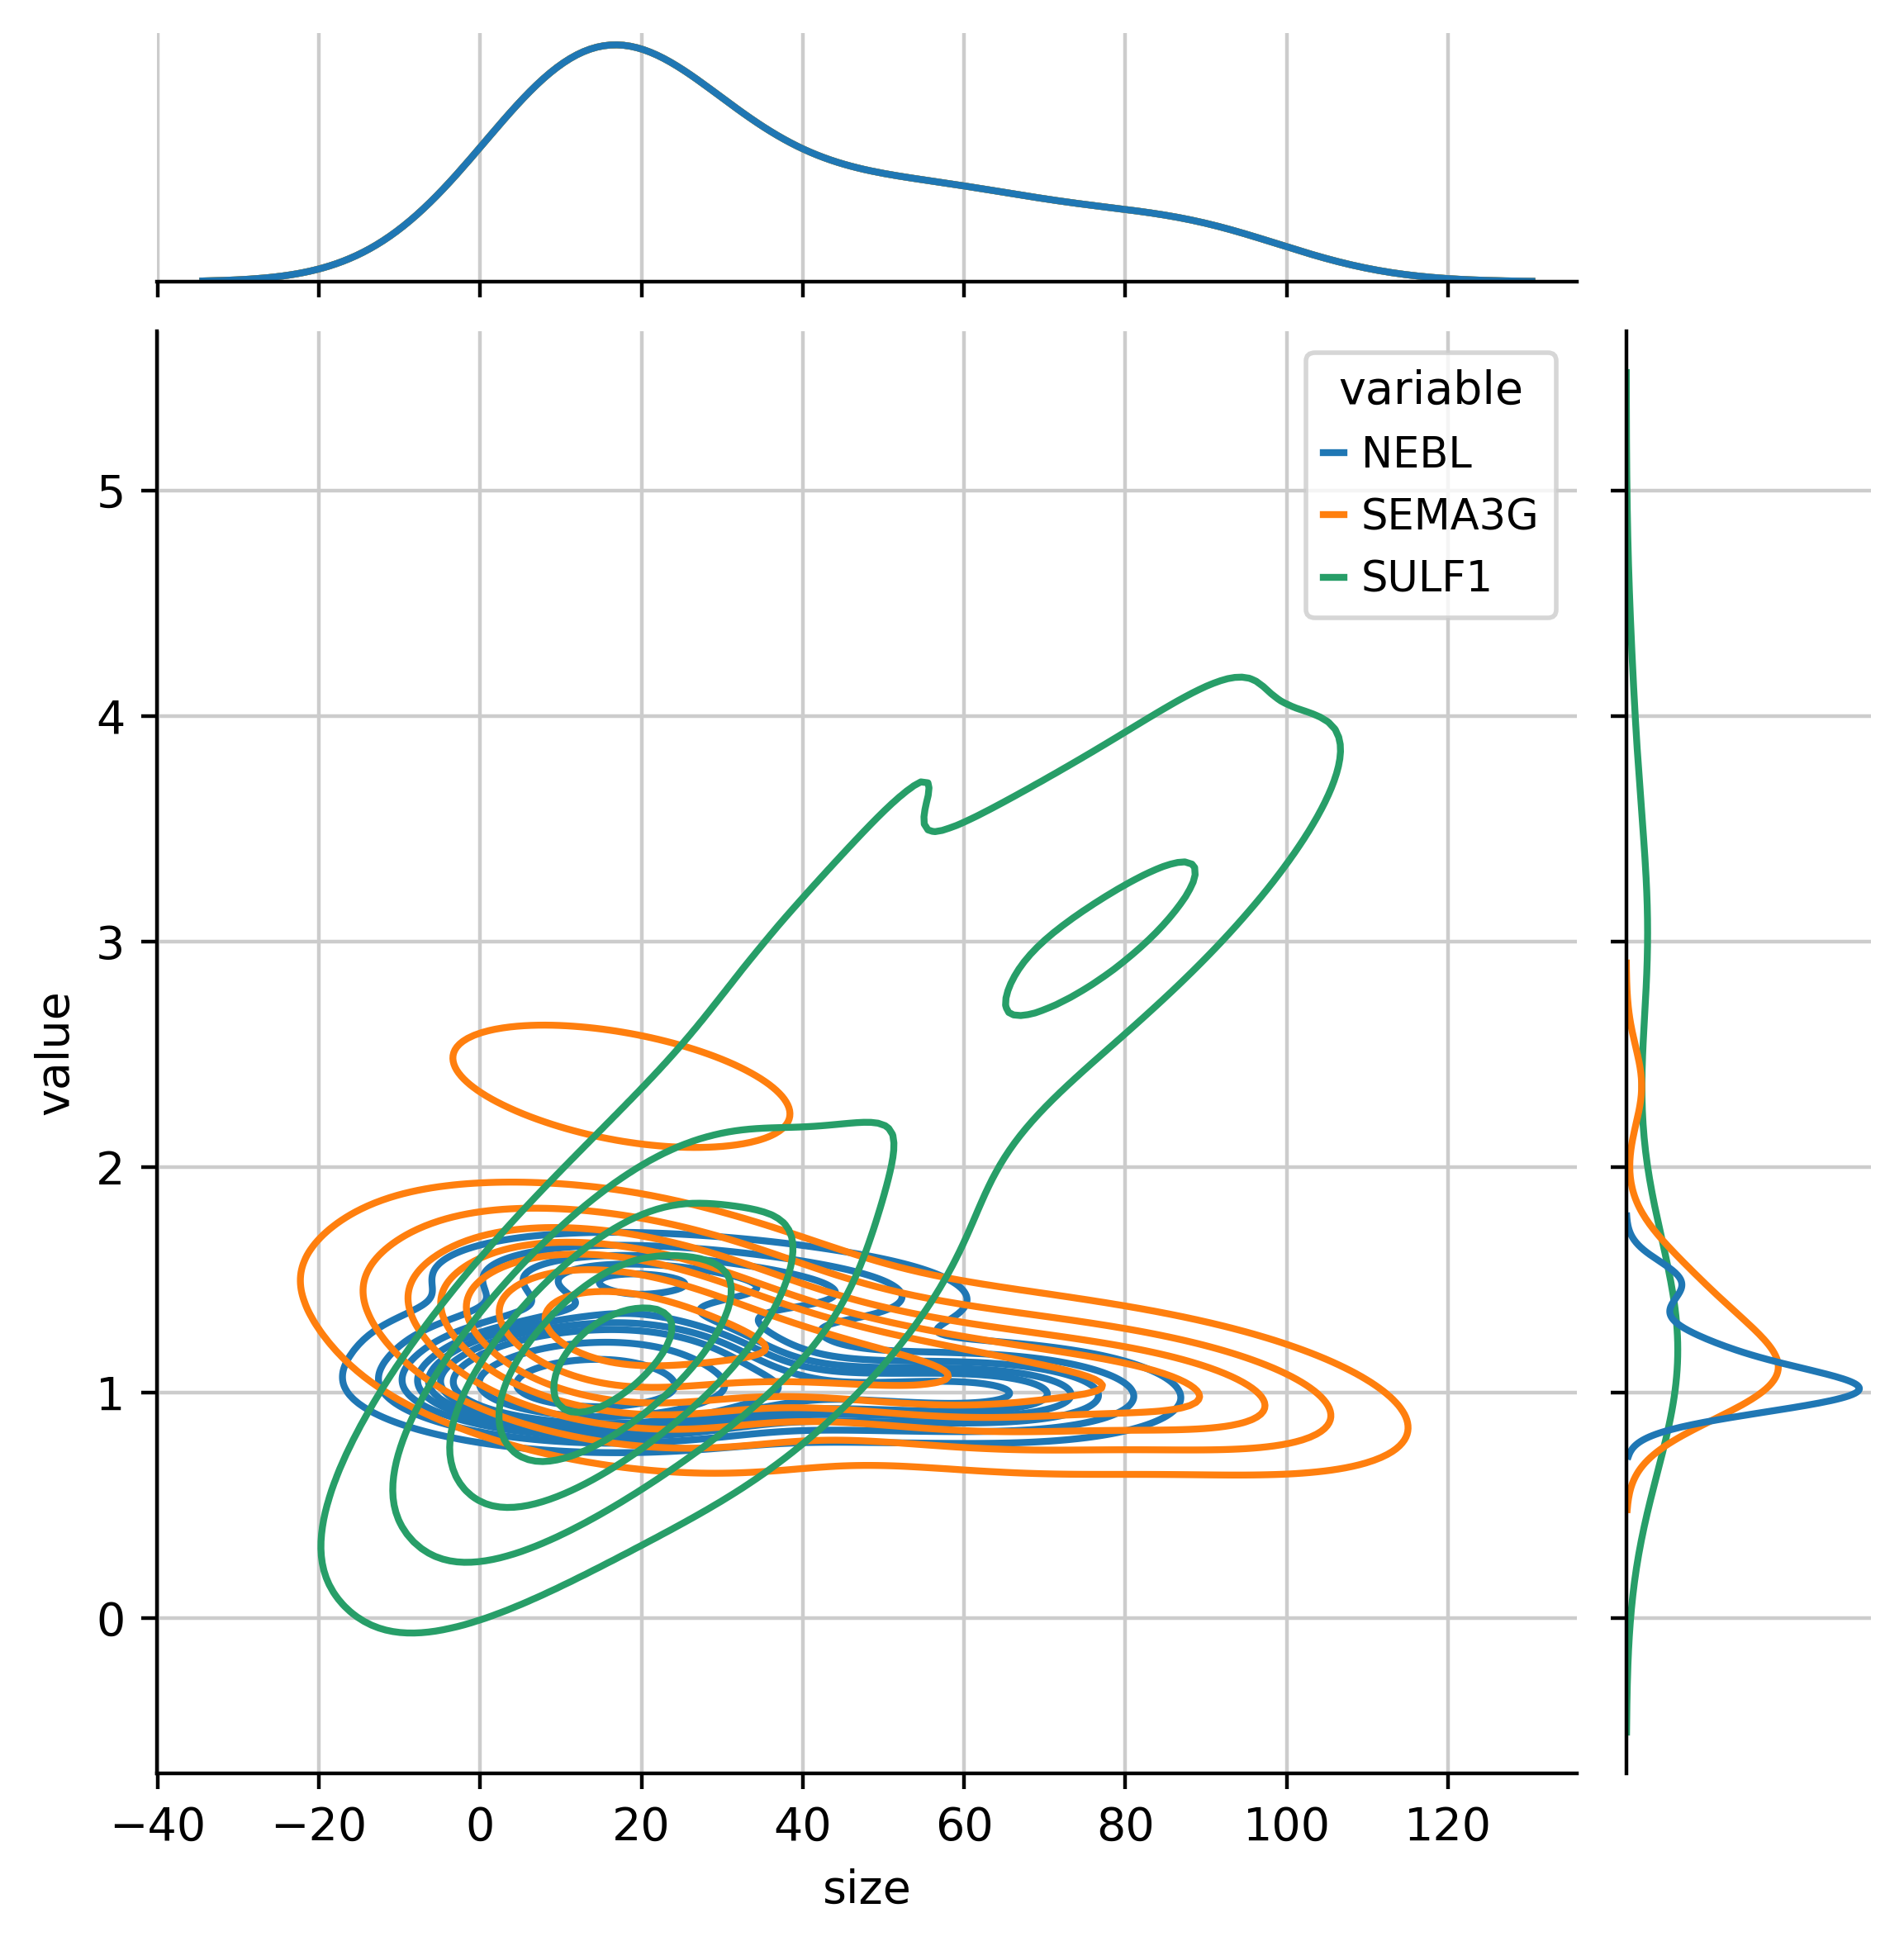

In [130]:
sns.jointplot(data=df4, x="size", y = 'value', hue = 'variable', kind = 'kde')

In [ ]:
sns.histplot(data = df2, x = 'size', label )

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/rds/general/user/snb20/home/anacon

<AxesSubplot:xlabel='size', ylabel='value'>

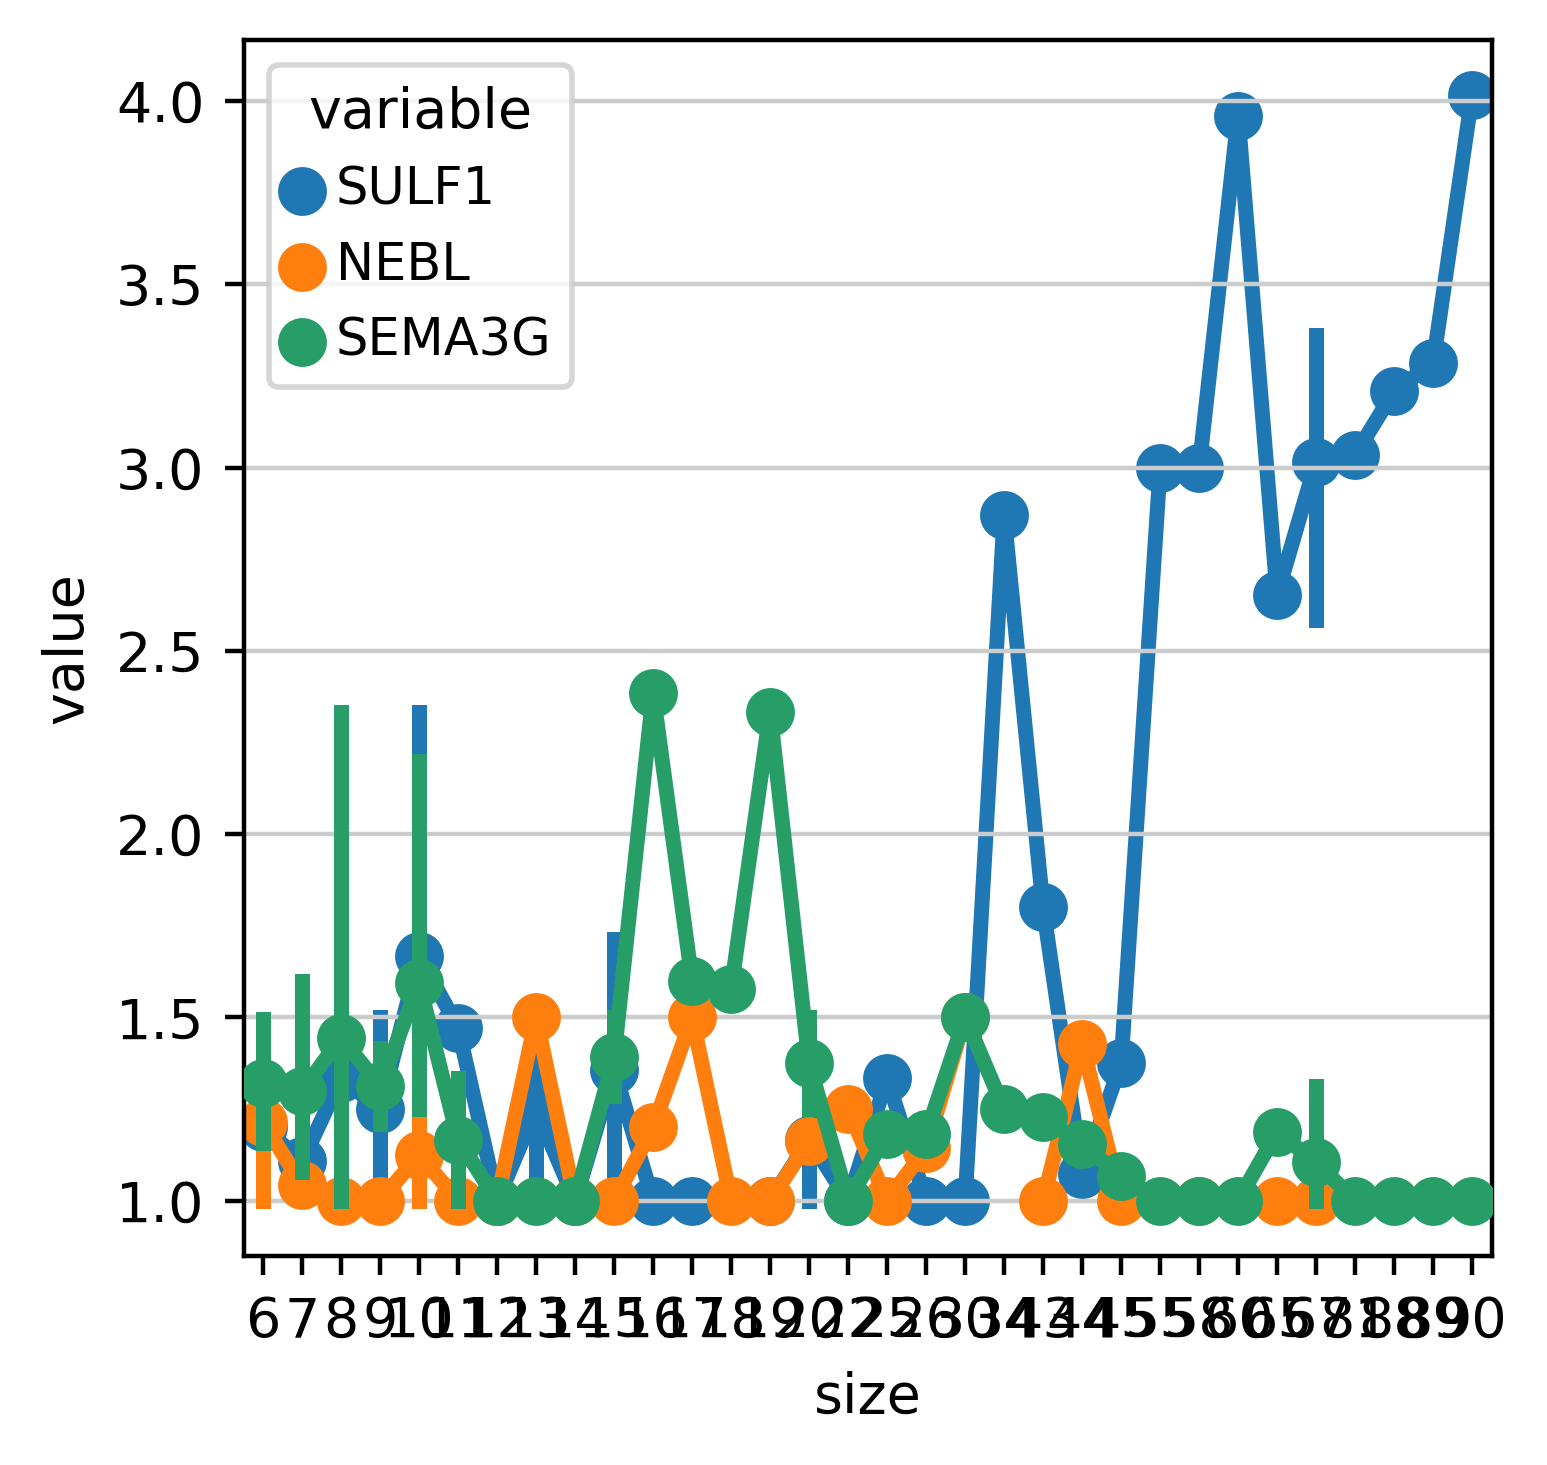

In [71]:
sns.pointplot(data=df2, x="size", y = 'value', hue = 'variable')

In [58]:
df3 = df.melt(id_vars=['size'], value_vars=['SULF1_percent', 'NEBL_percent'])
df3

size       variable     value
0      10  SULF1_percent  0.000000
1      16  SULF1_percent  0.000000
2       7  SULF1_percent  0.000000
3      81  SULF1_percent  0.481481
4       6  SULF1_percent  0.166667
..    ...            ...       ...
175    15   NEBL_percent  0.000000
176    14   NEBL_percent  0.000000
177     7   NEBL_percent  0.000000
178     7   NEBL_percent  0.000000
179    12   NEBL_percent  0.000000

[180 rows x 3 columns]

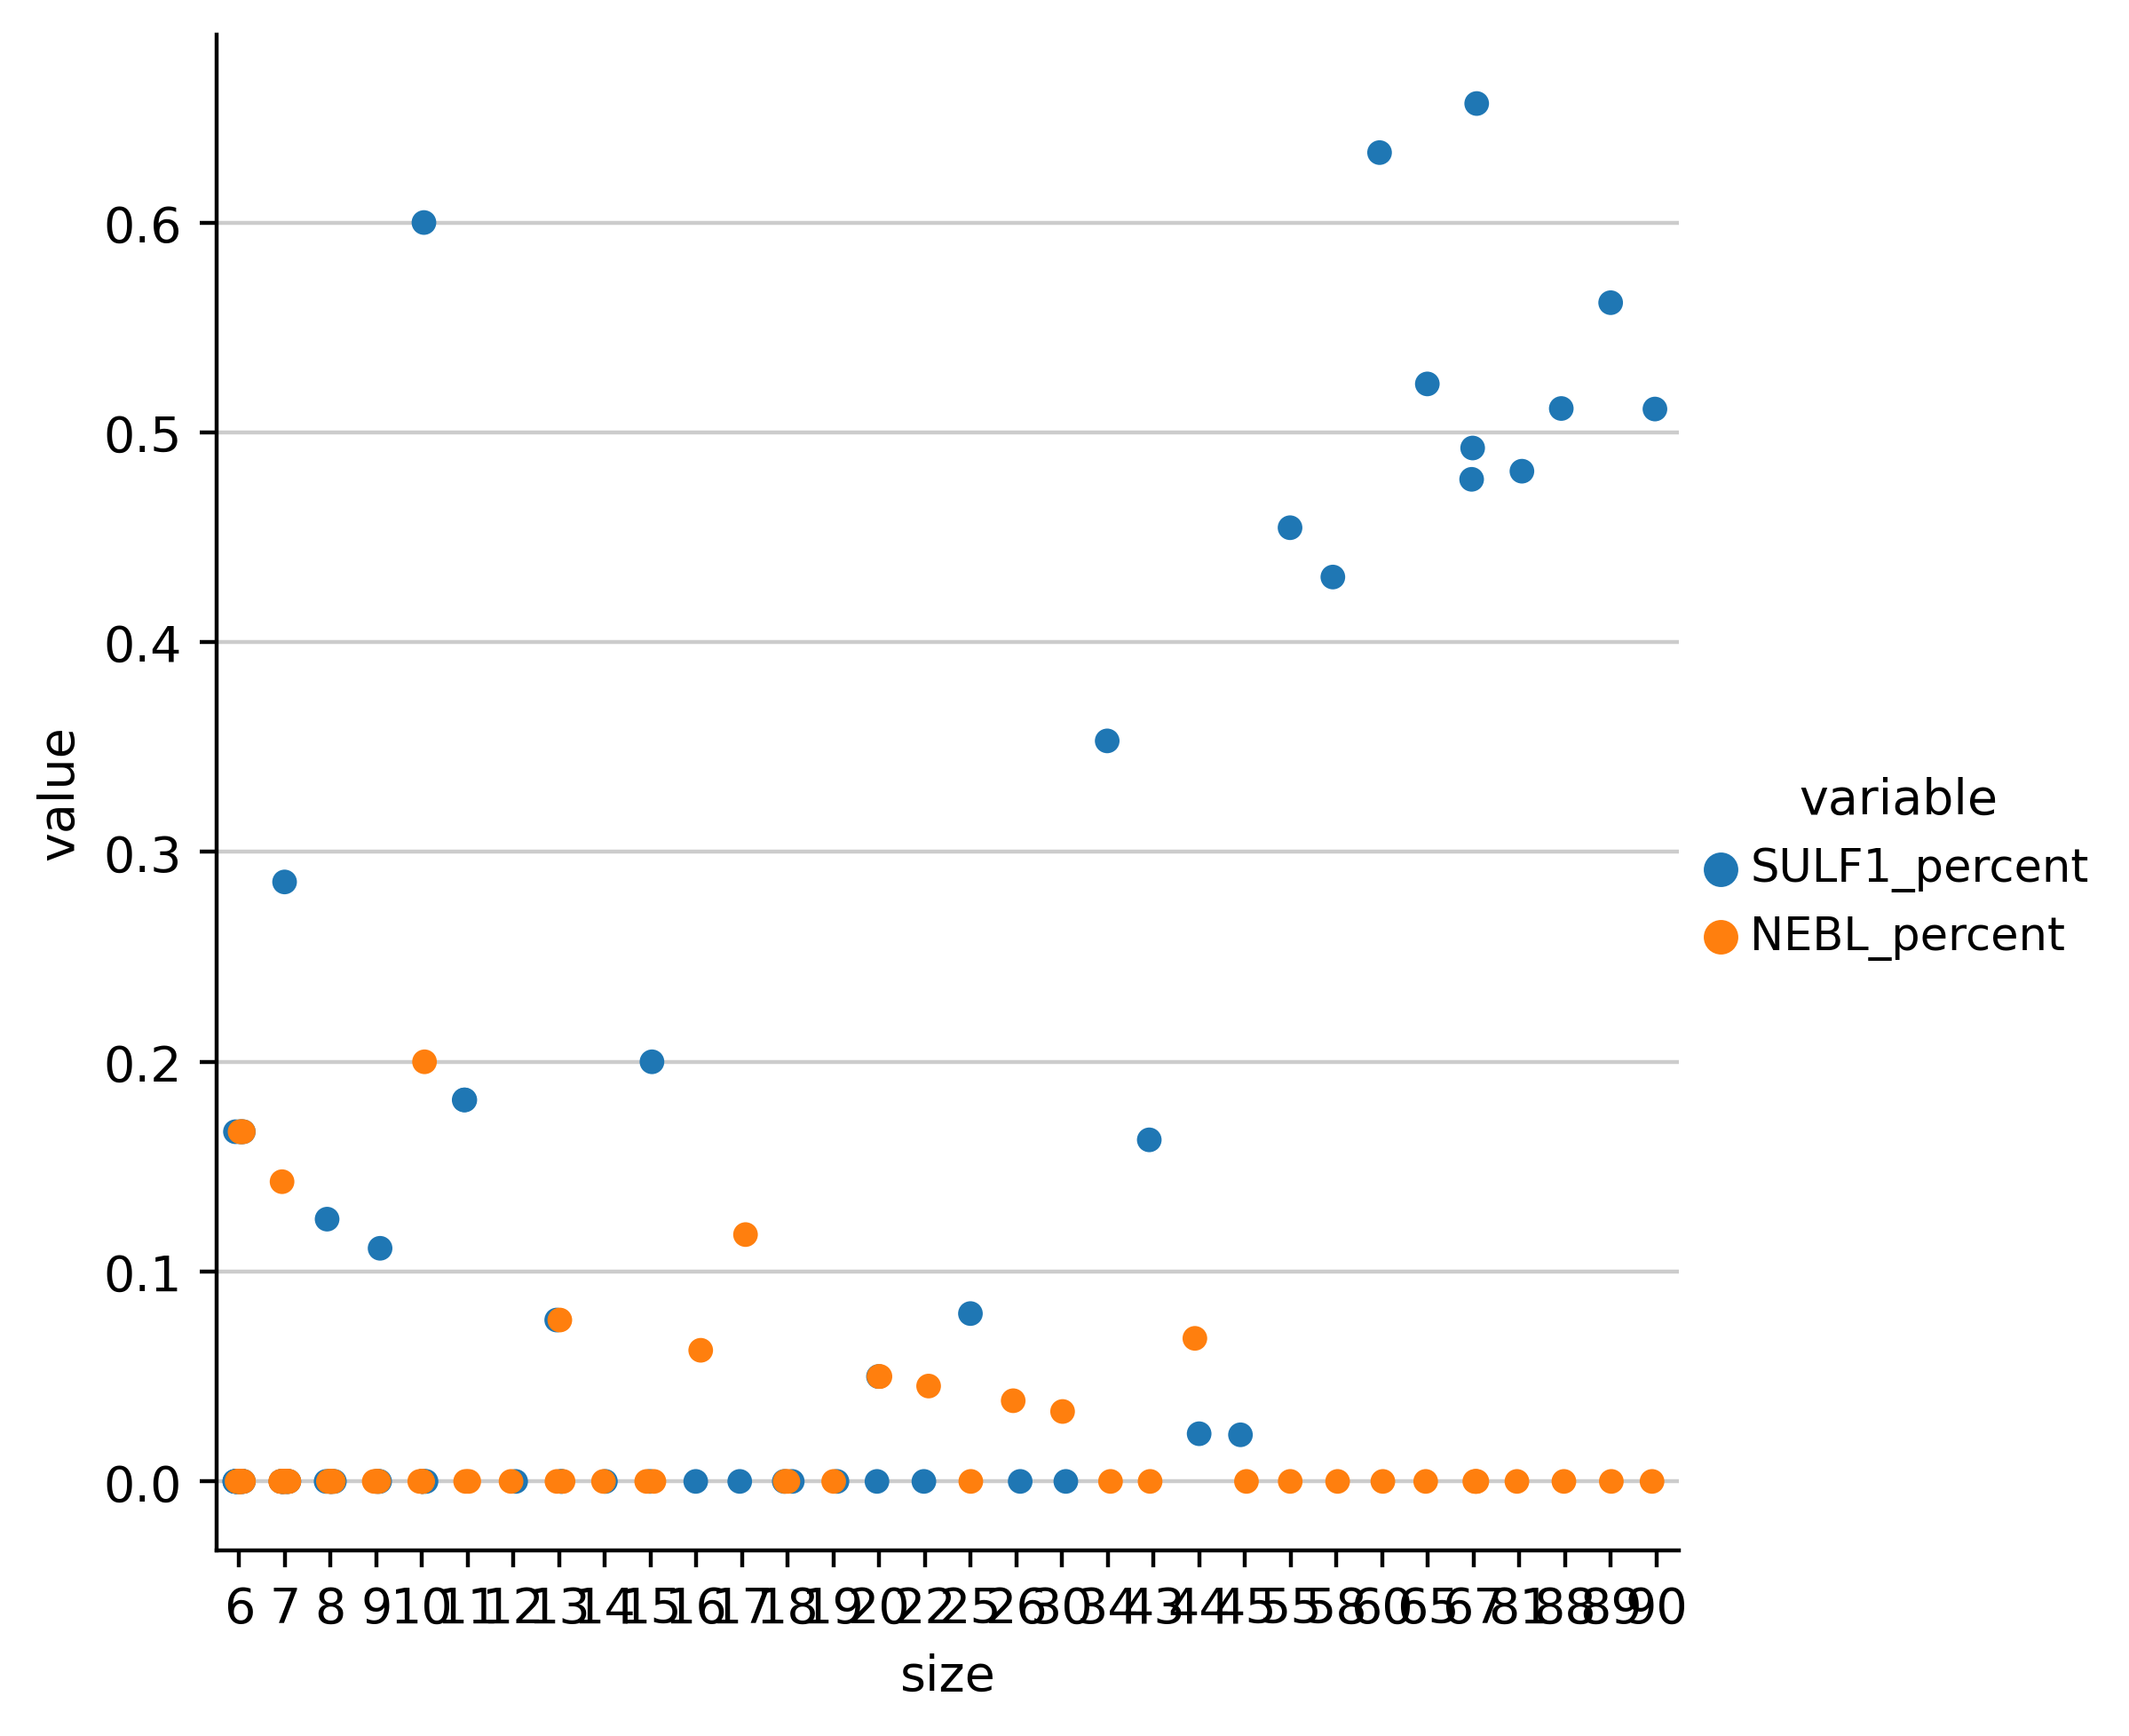

In [69]:
sns.catplot(data=df3, x="size", y = 'value', hue = 'variable')

In [5]:
rcParams.update({'figure.autolayout': True})

In [6]:
vessels = ['Large','Small']
pairs = list(combinations(vessels, r=2))
pairs

[('Large', 'Small')]

In [7]:
sns.set(rc={'figure.figsize':(0.8,2.5)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set(rc={'axes.edgecolor': 'black', 'axes.facecolor' : 'white', 'grid.color': 'whitesmoke', 'xtick.bottom': True, 'ytick.left': True})
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'black',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': 'whitesmoke',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.962e-01 U_stat=1.555e+02


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/statannotations/Annotator.py:548: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.draw()
/var/tmp/pbs.8209870.pbs/ipykernel_2964214/1556973849.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('NEBL_mean_expression.pdf', bbox_inches='tight')
/var/tmp/pbs.8209870.pbs/ipykernel_2964214/1556973849.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('NEBL_mean_expression.pdf', bbox_inches='tight')
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all

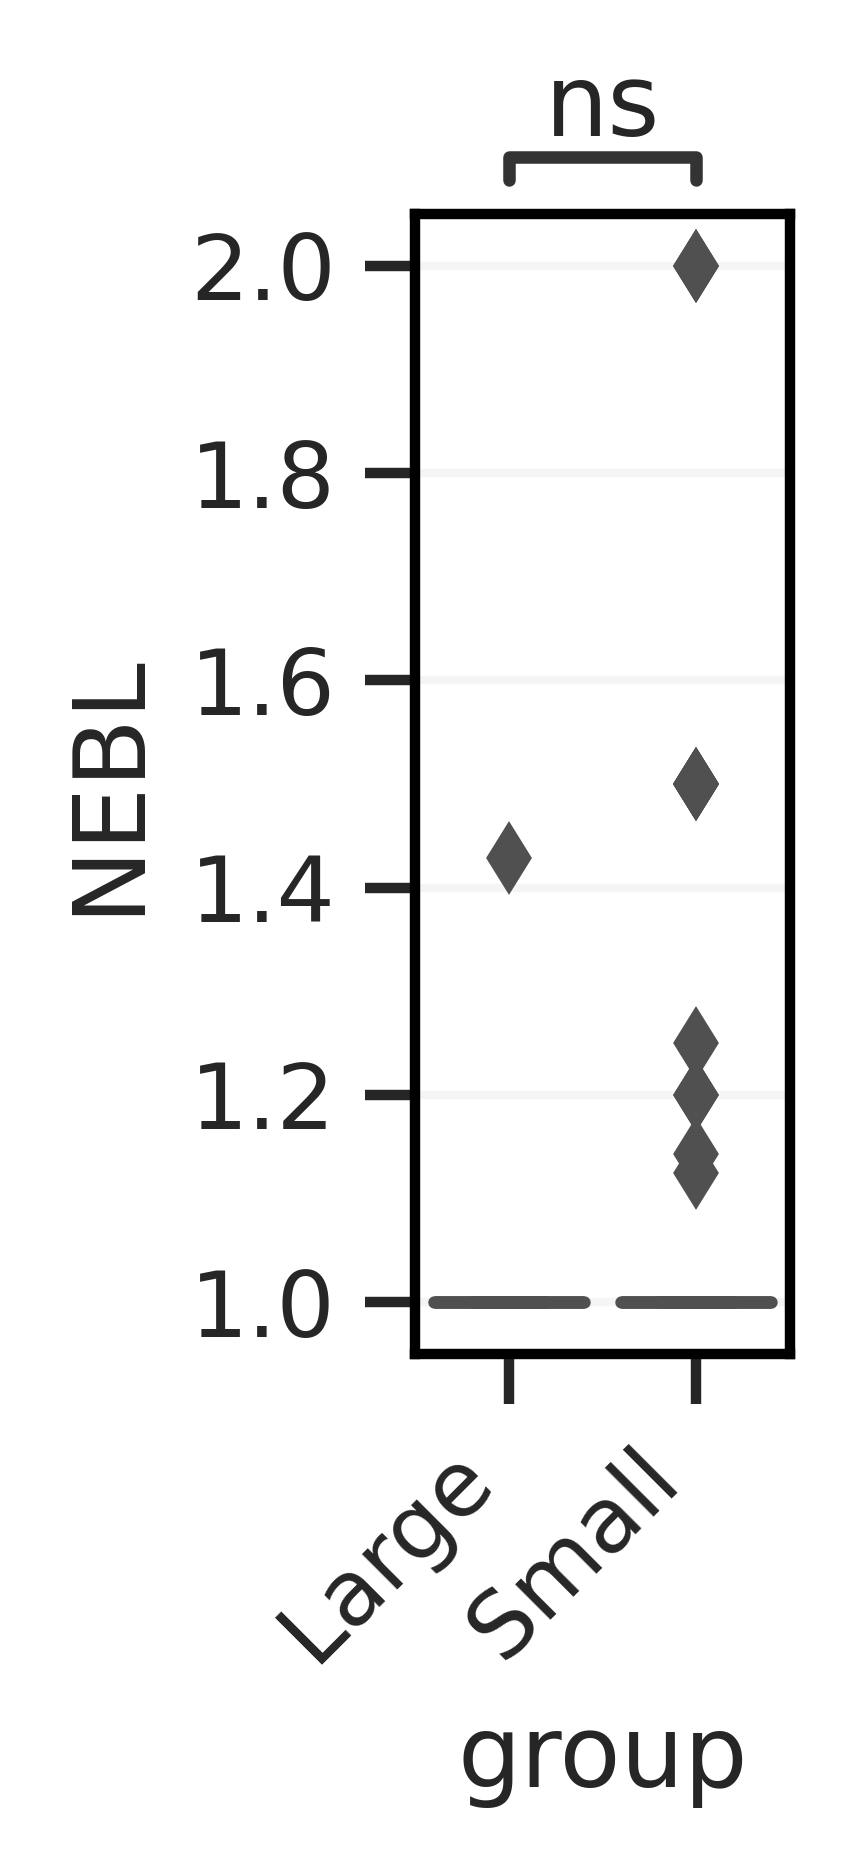

In [8]:
#SEMA3G mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "NEBL", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "NEBL", palette = 'Reds', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
plt.savefig('NEBL_mean_expression.pdf', bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.031e-01 U_stat=5.020e+02


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/statannotations/Annotator.py:548: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.draw()
/var/tmp/pbs.8209870.pbs/ipykernel_2964214/3236032740.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('NEBL_percent_expressing.pdf', bbox_inches='tight')
/var/tmp/pbs.8209870.pbs/ipykernel_2964214/3236032740.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('NEBL_percent_expressing.pdf', bbox_inches='tight')
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommoda

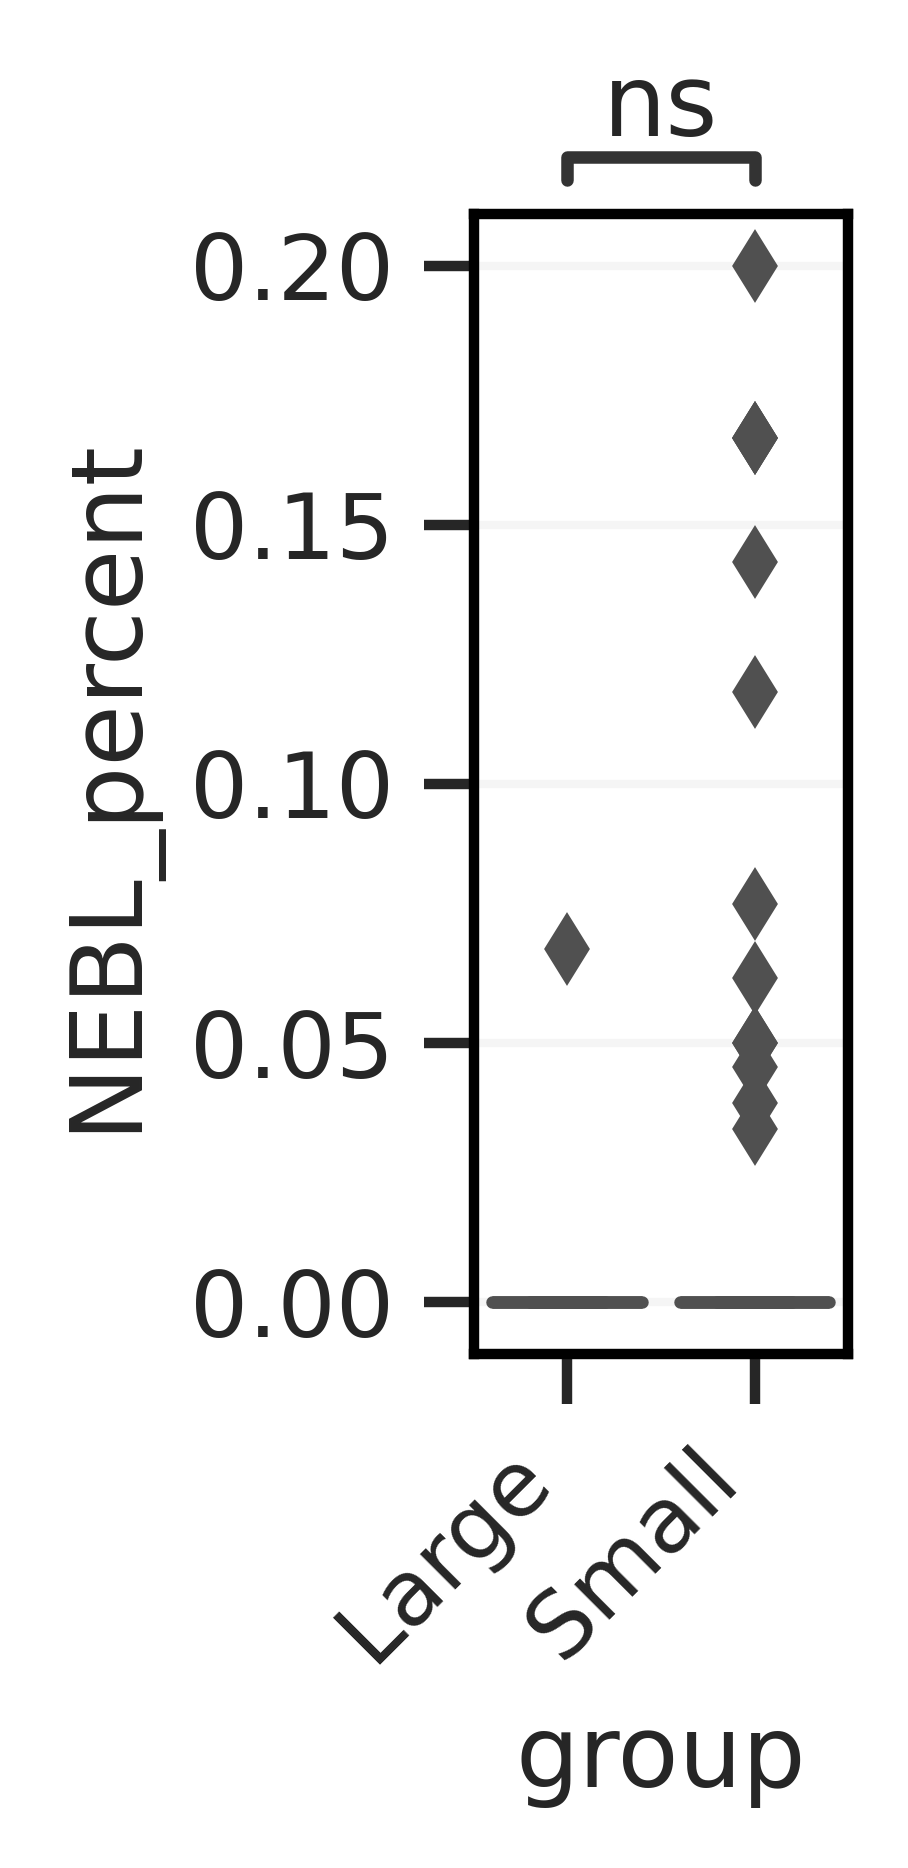

In [9]:
#SEMA3G mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "NEBL_percent", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "NEBL_percent", palette = 'Reds', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
plt.savefig('NEBL_percent_expressing.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#SEMA3G mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "NEBL_log2_mean", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "SEMA3G_log2_mean", palette = 'Reds', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
plt.savefig('SEMA3G_mean_expression.pdf', bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.689e-02 U_stat=3.010e+02


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/statannotations/Annotator.py:548: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.draw()
/var/tmp/pbs.7946745.pbs/ipykernel_1685842/3493544908.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('SEMA3G_mean_expression.pdf', bbox_inches='tight')
/var/tmp/pbs.7946745.pbs/ipykernel_1685842/3493544908.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('SEMA3G_mean_expression.pdf', bbox_inches='tight')
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate

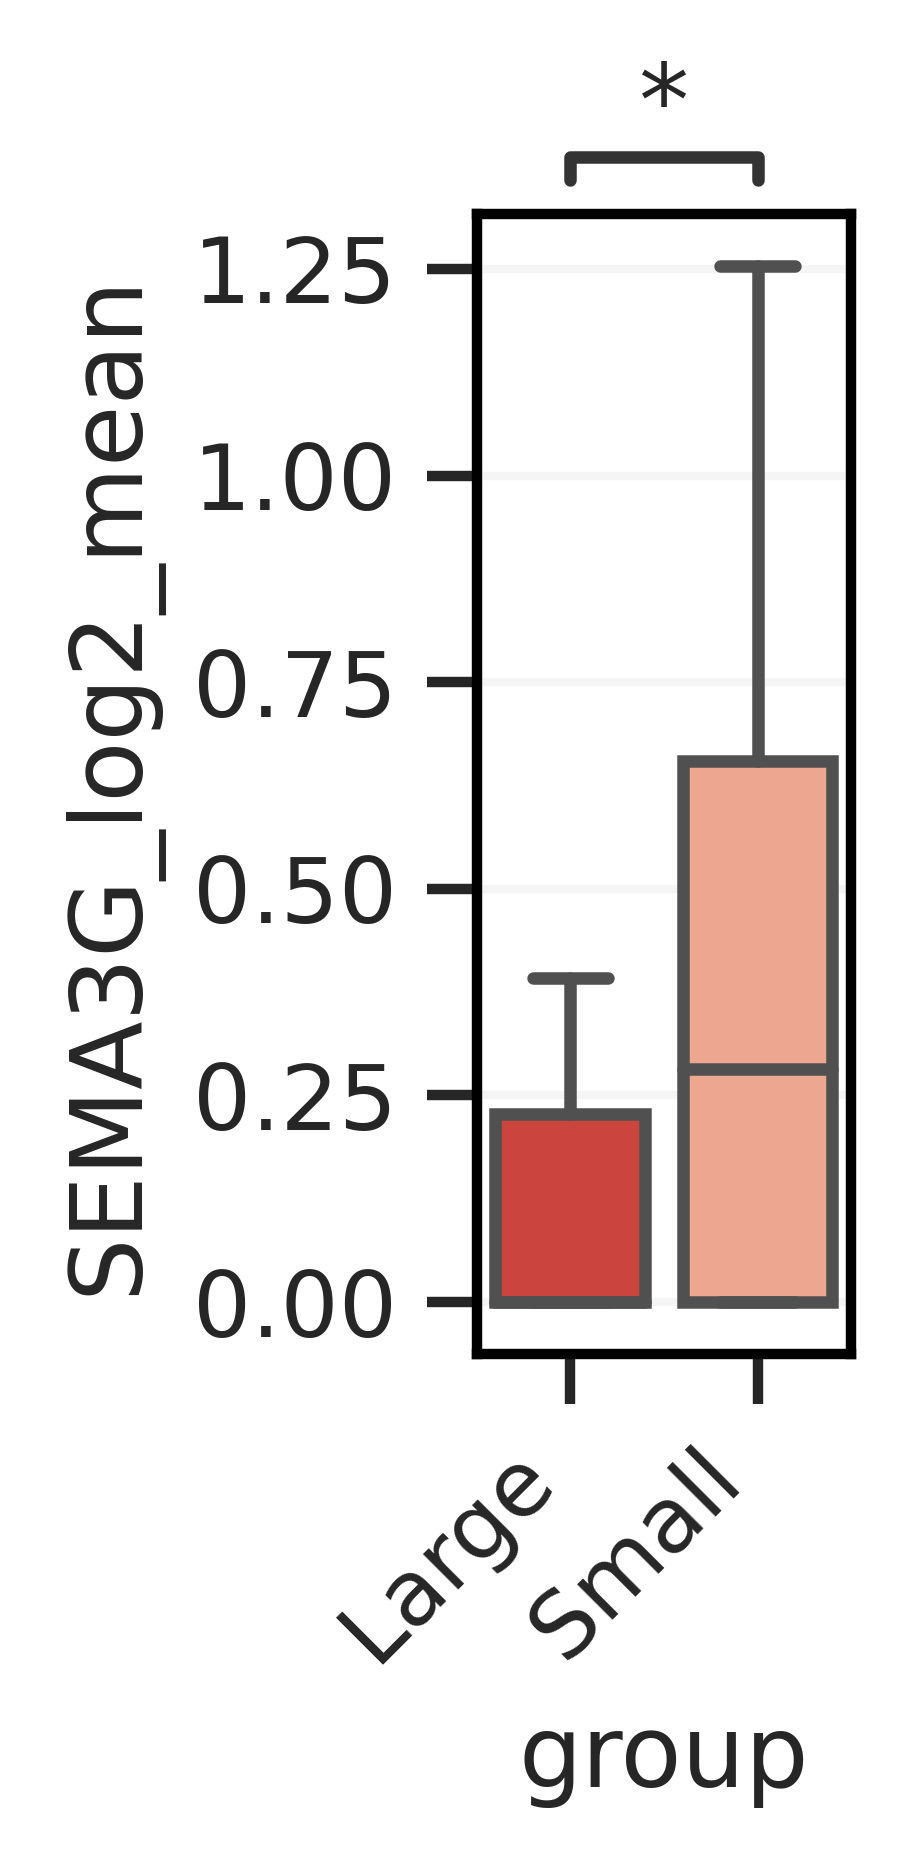

In [22]:
#SEMA3G mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "SEMA3G_log2_mean", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "SEMA3G_log2_mean", palette = 'Reds', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
plt.savefig('SEMA3G_mean_expression.pdf', bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.070e-08 U_stat=5.750e+02


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/statannotations/Annotator.py:548: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.draw()
/var/tmp/pbs.7946745.pbs/ipykernel_1685842/553314065.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('SULF1_mean_expression', bbox_inches='tight')
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


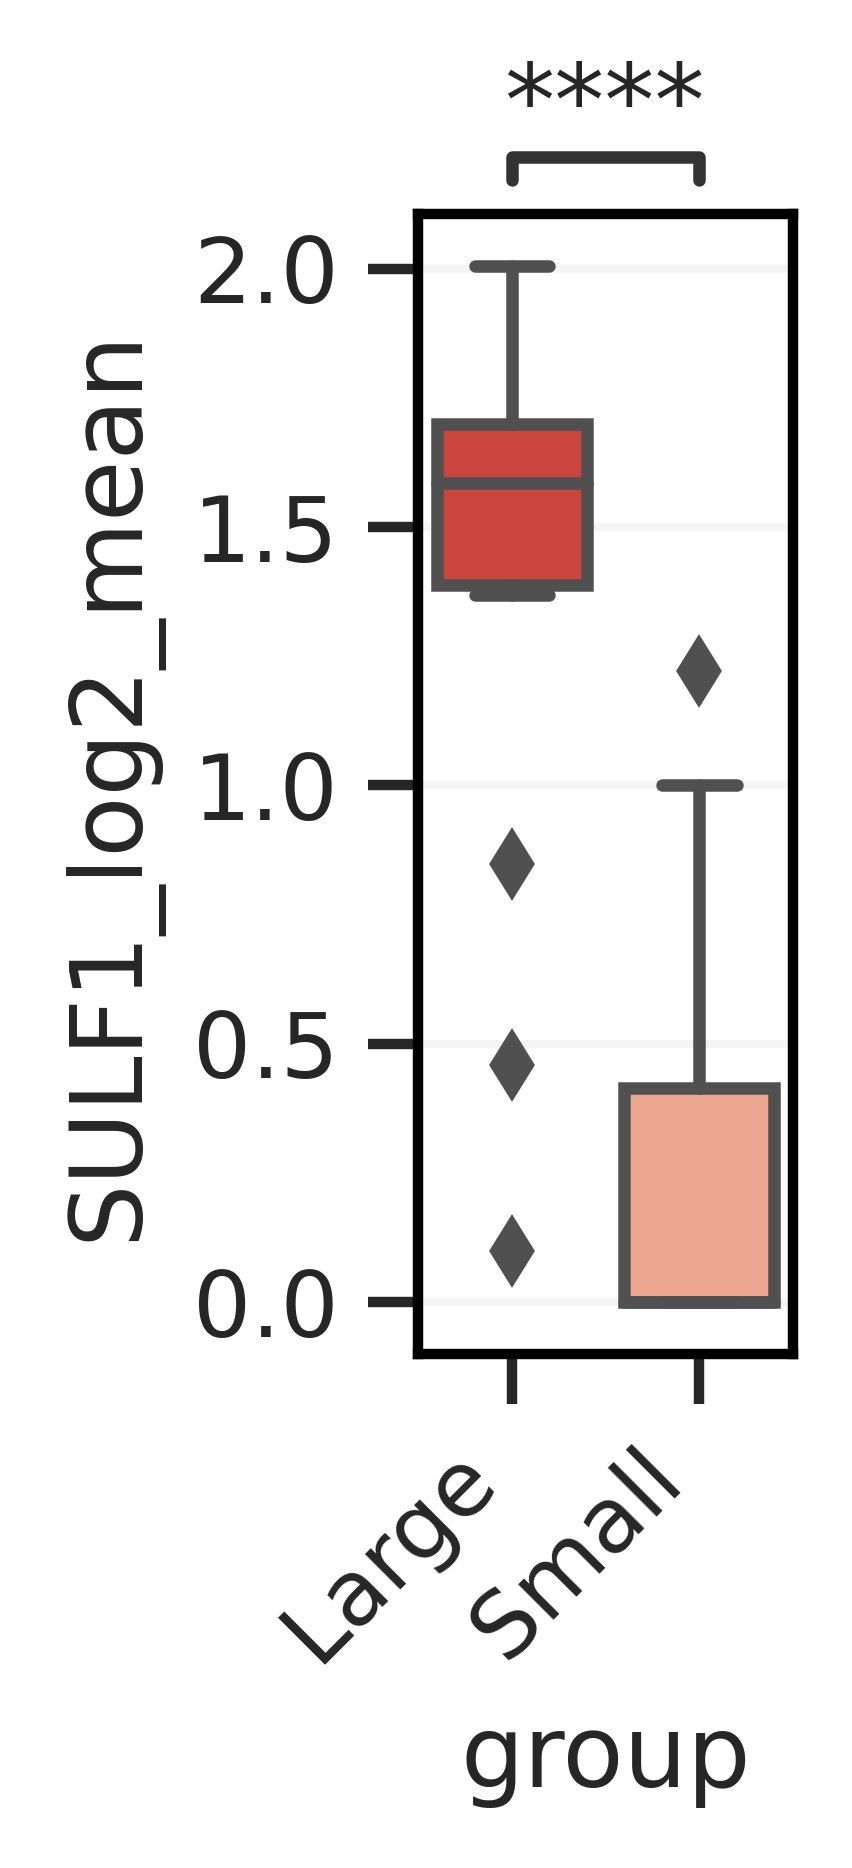

In [20]:
#SULF1 mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "SULF1_log2_mean", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "SULF1", palette = 'Blues', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
plt.savefig('SULF1_mean_expression', bbox_inches='tight')
plt.show()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.070e-08 U_stat=5.750e+02


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/statannotations/Annotator.py:548: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.draw()
/var/tmp/pbs.7946745.pbs/ipykernel_1685842/1537685860.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('SULF1_percent.pdf', bbox_inches='tight')
/var/tmp/pbs.7946745.pbs/ipykernel_1685842/1537685860.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('SULF1_percent.pdf', bbox_inches='tight')
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorati

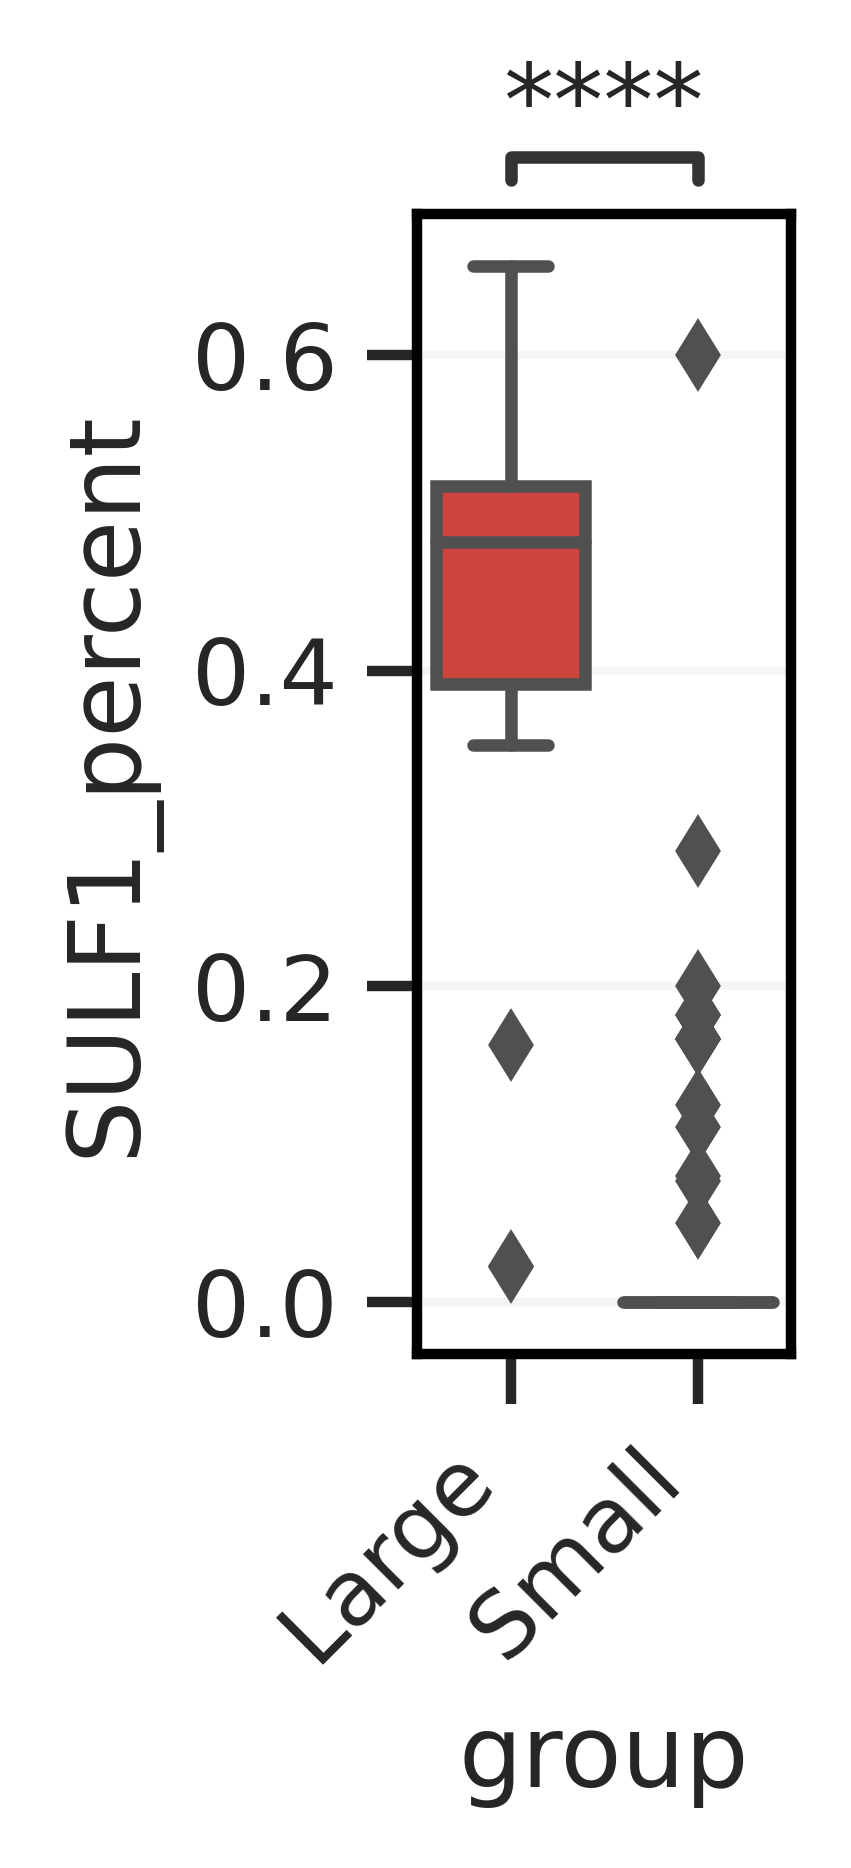

In [24]:
#SULF1 mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "SULF1_percent", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "SULF1", palette = 'Blues', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
plt.savefig('SULF1_percent.pdf', bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.070e-08 U_stat=5.750e+02


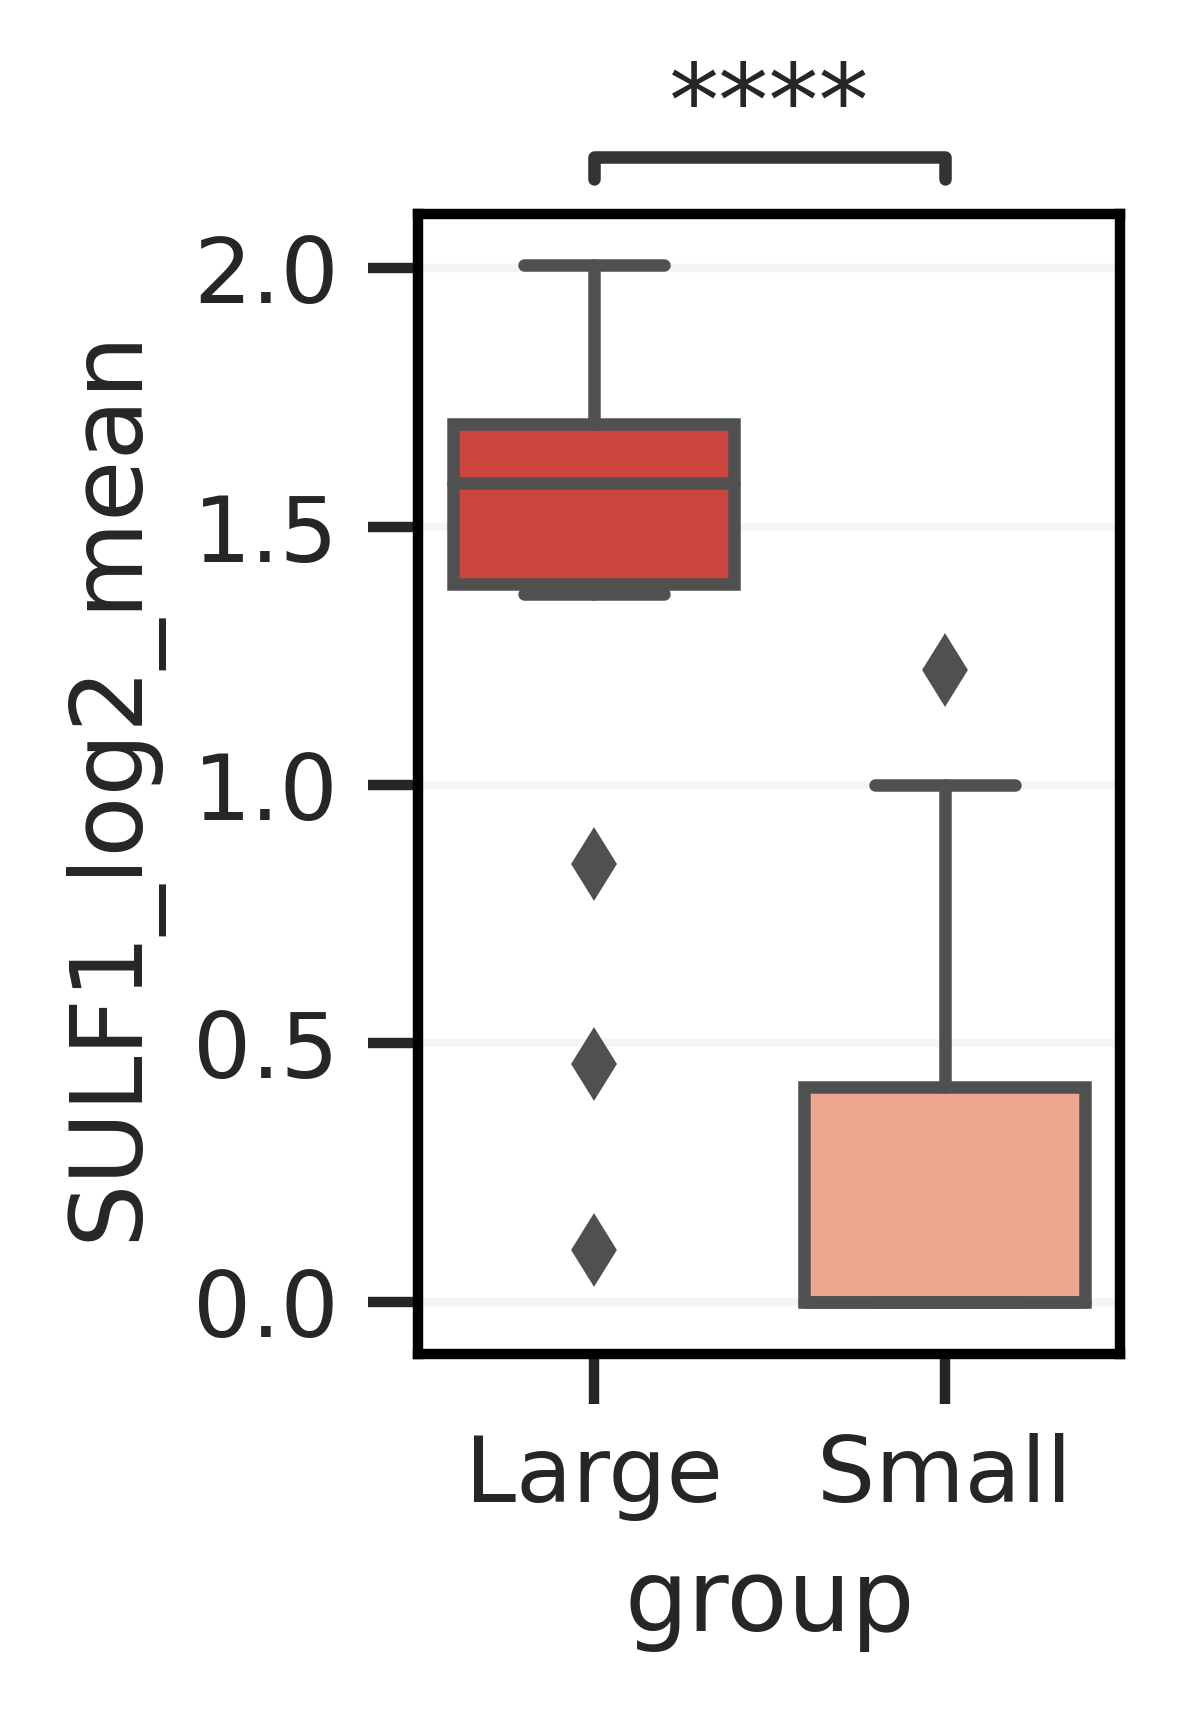

In [30]:
#SULF1 mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "SULF1_log2_mean", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "SULF1_log2_mean", palette = 'Reds_r', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
annotator.apply_and_annotate()
plt.show()

In [20]:
vessels2 = ['Large','Medium','Small']
pairs2 = list(combinations(vessels2, r=2))
pairs2

[('Large', 'Medium'), ('Large', 'Small'), ('Medium', 'Small')]

In [24]:
sns.set(rc={'figure.figsize':(1.5,2.5)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set(rc={'axes.edgecolor': 'black', 'axes.facecolor' : 'white', 'grid.color': 'whitesmoke', 'xtick.bottom': True, 'ytick.left': True})
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'black',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': 'whitesmoke',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Medium: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.440e-06 U_stat=2.450e+02
Medium vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.849e-01 U_stat=1.905e+02
Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.294e-06 U_stat=3.300e+02


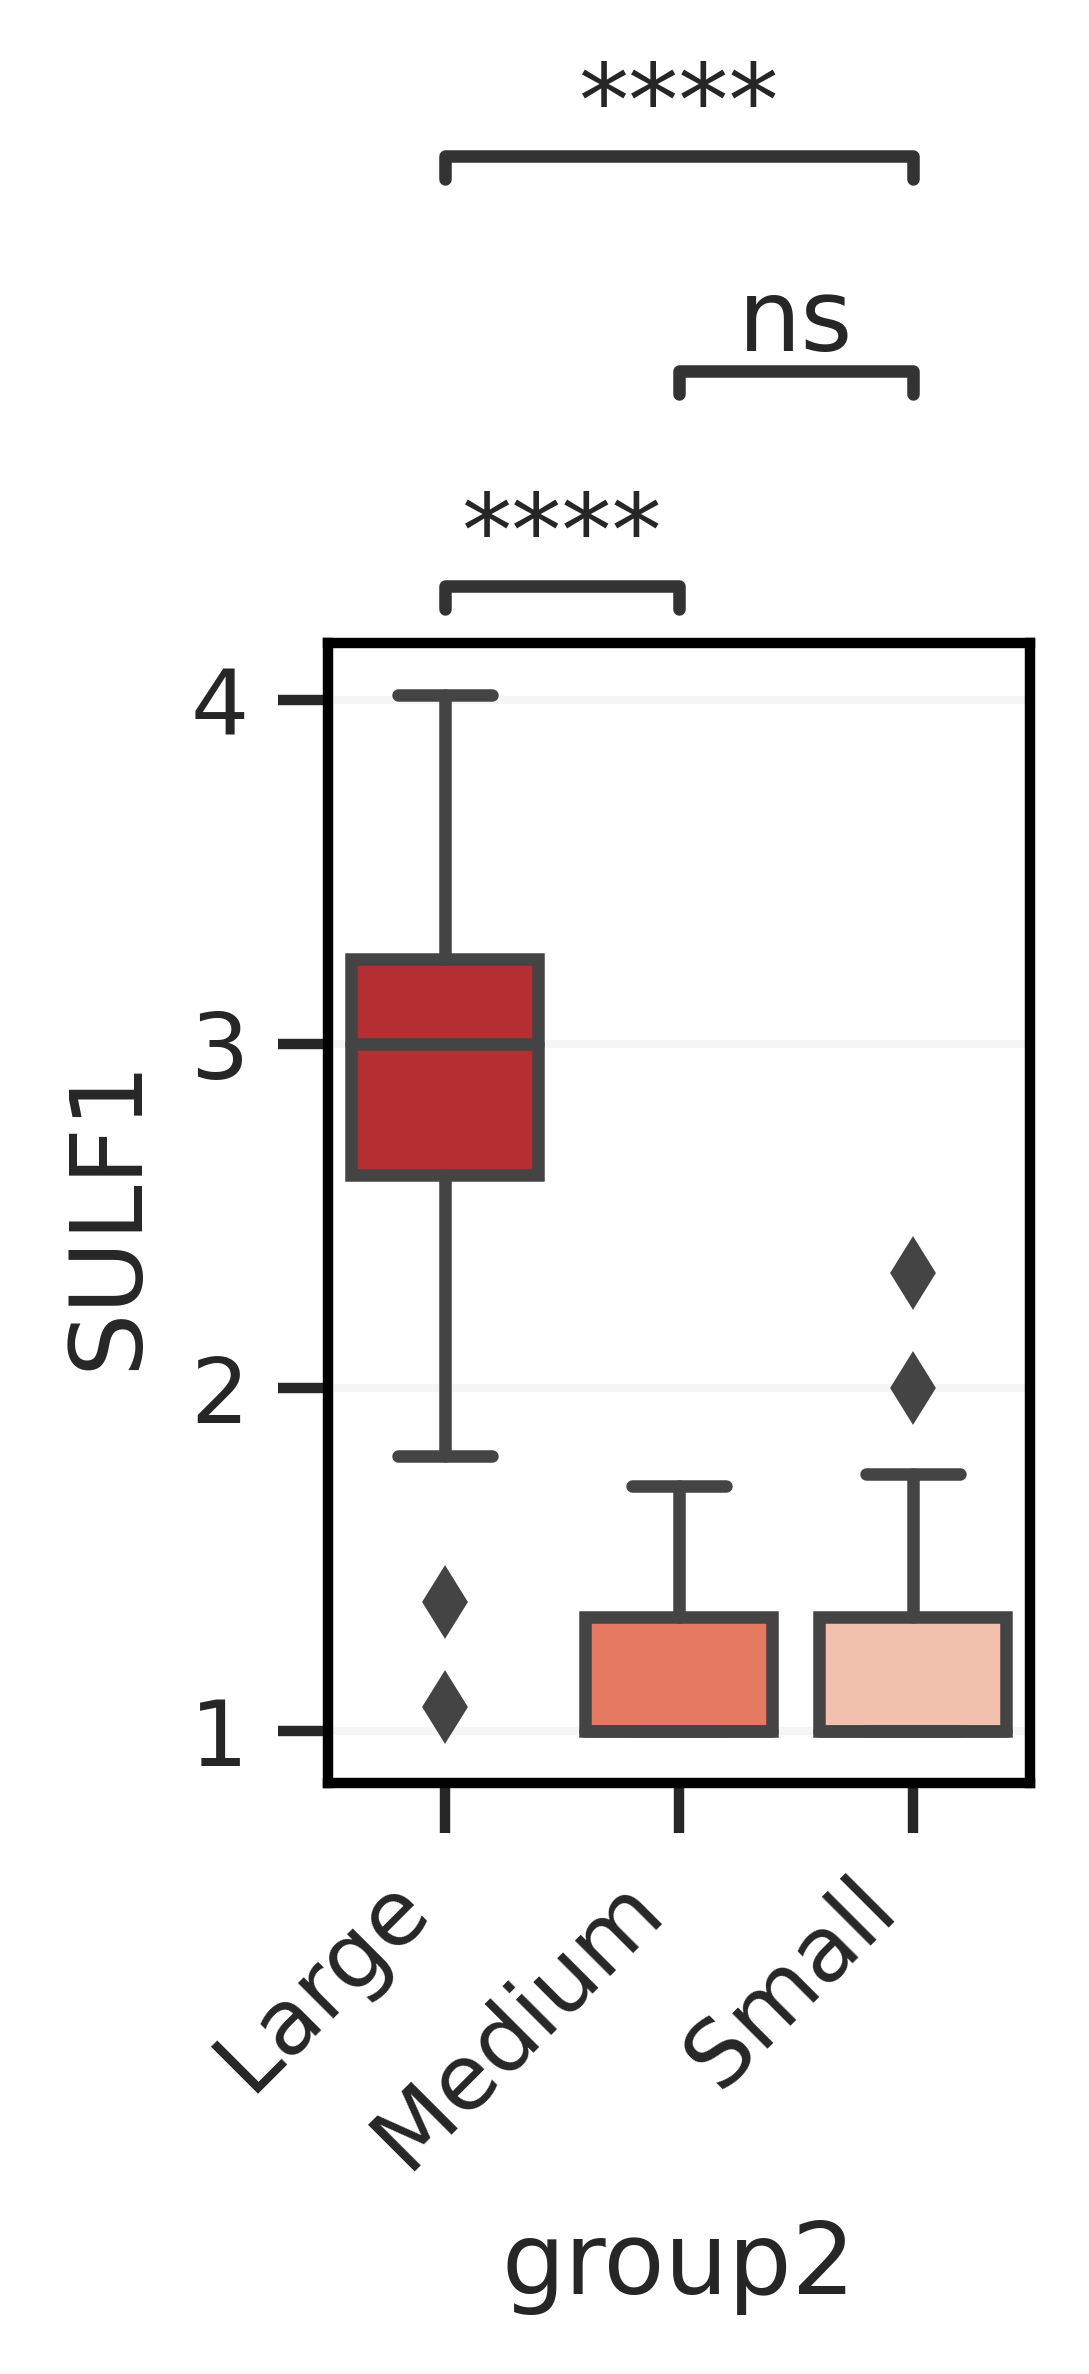

In [22]:
#SULF1 mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group2", y = "SULF1", palette = 'Reds_r', order = ['Large','Medium','Small'])
annotator = Annotator(ax, pairs2, data = df, x = "group2", y = "SULF1", palette = 'Blues', order = ['Large','Medium','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Medium: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.440e-06 U_stat=2.450e+02
Medium vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.849e-01 U_stat=1.905e+02
Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.294e-06 U_stat=3.300e+02


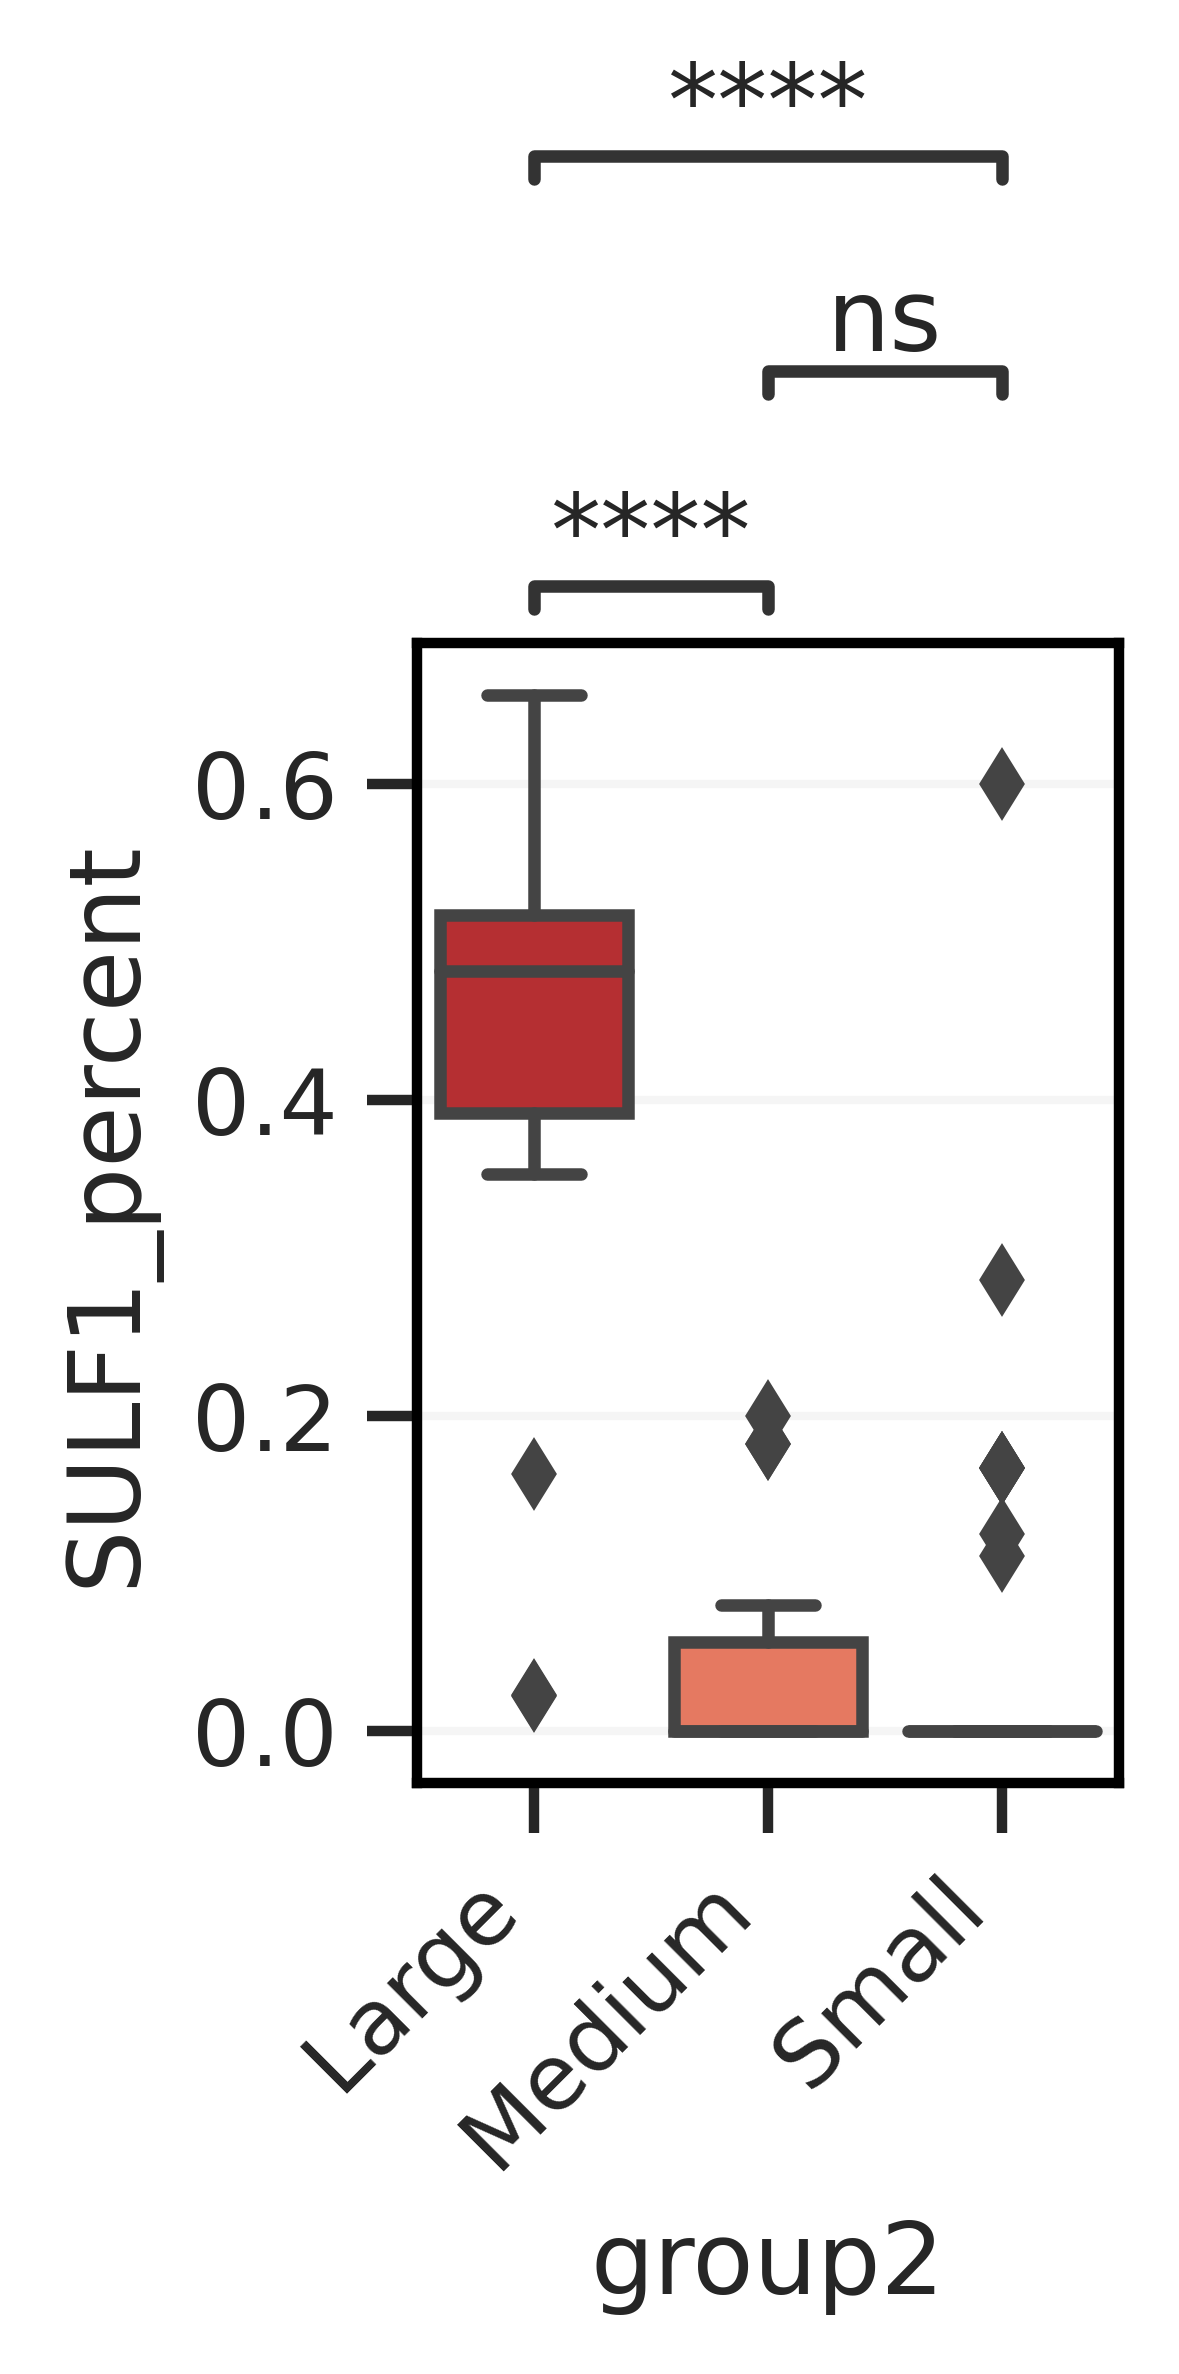

In [25]:
#SULF1 mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group2", y = "SULF1_percent", palette = 'Reds_r', order = ['Large','Medium','Small'])
annotator = Annotator(ax, pairs2, data = df, x = "group2", y = "SULF1", palette = 'Blues', order = ['Large','Medium','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Medium: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.440e-06 U_stat=2.450e+02
Medium vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.849e-01 U_stat=1.905e+02
Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.294e-06 U_stat=3.300e+02


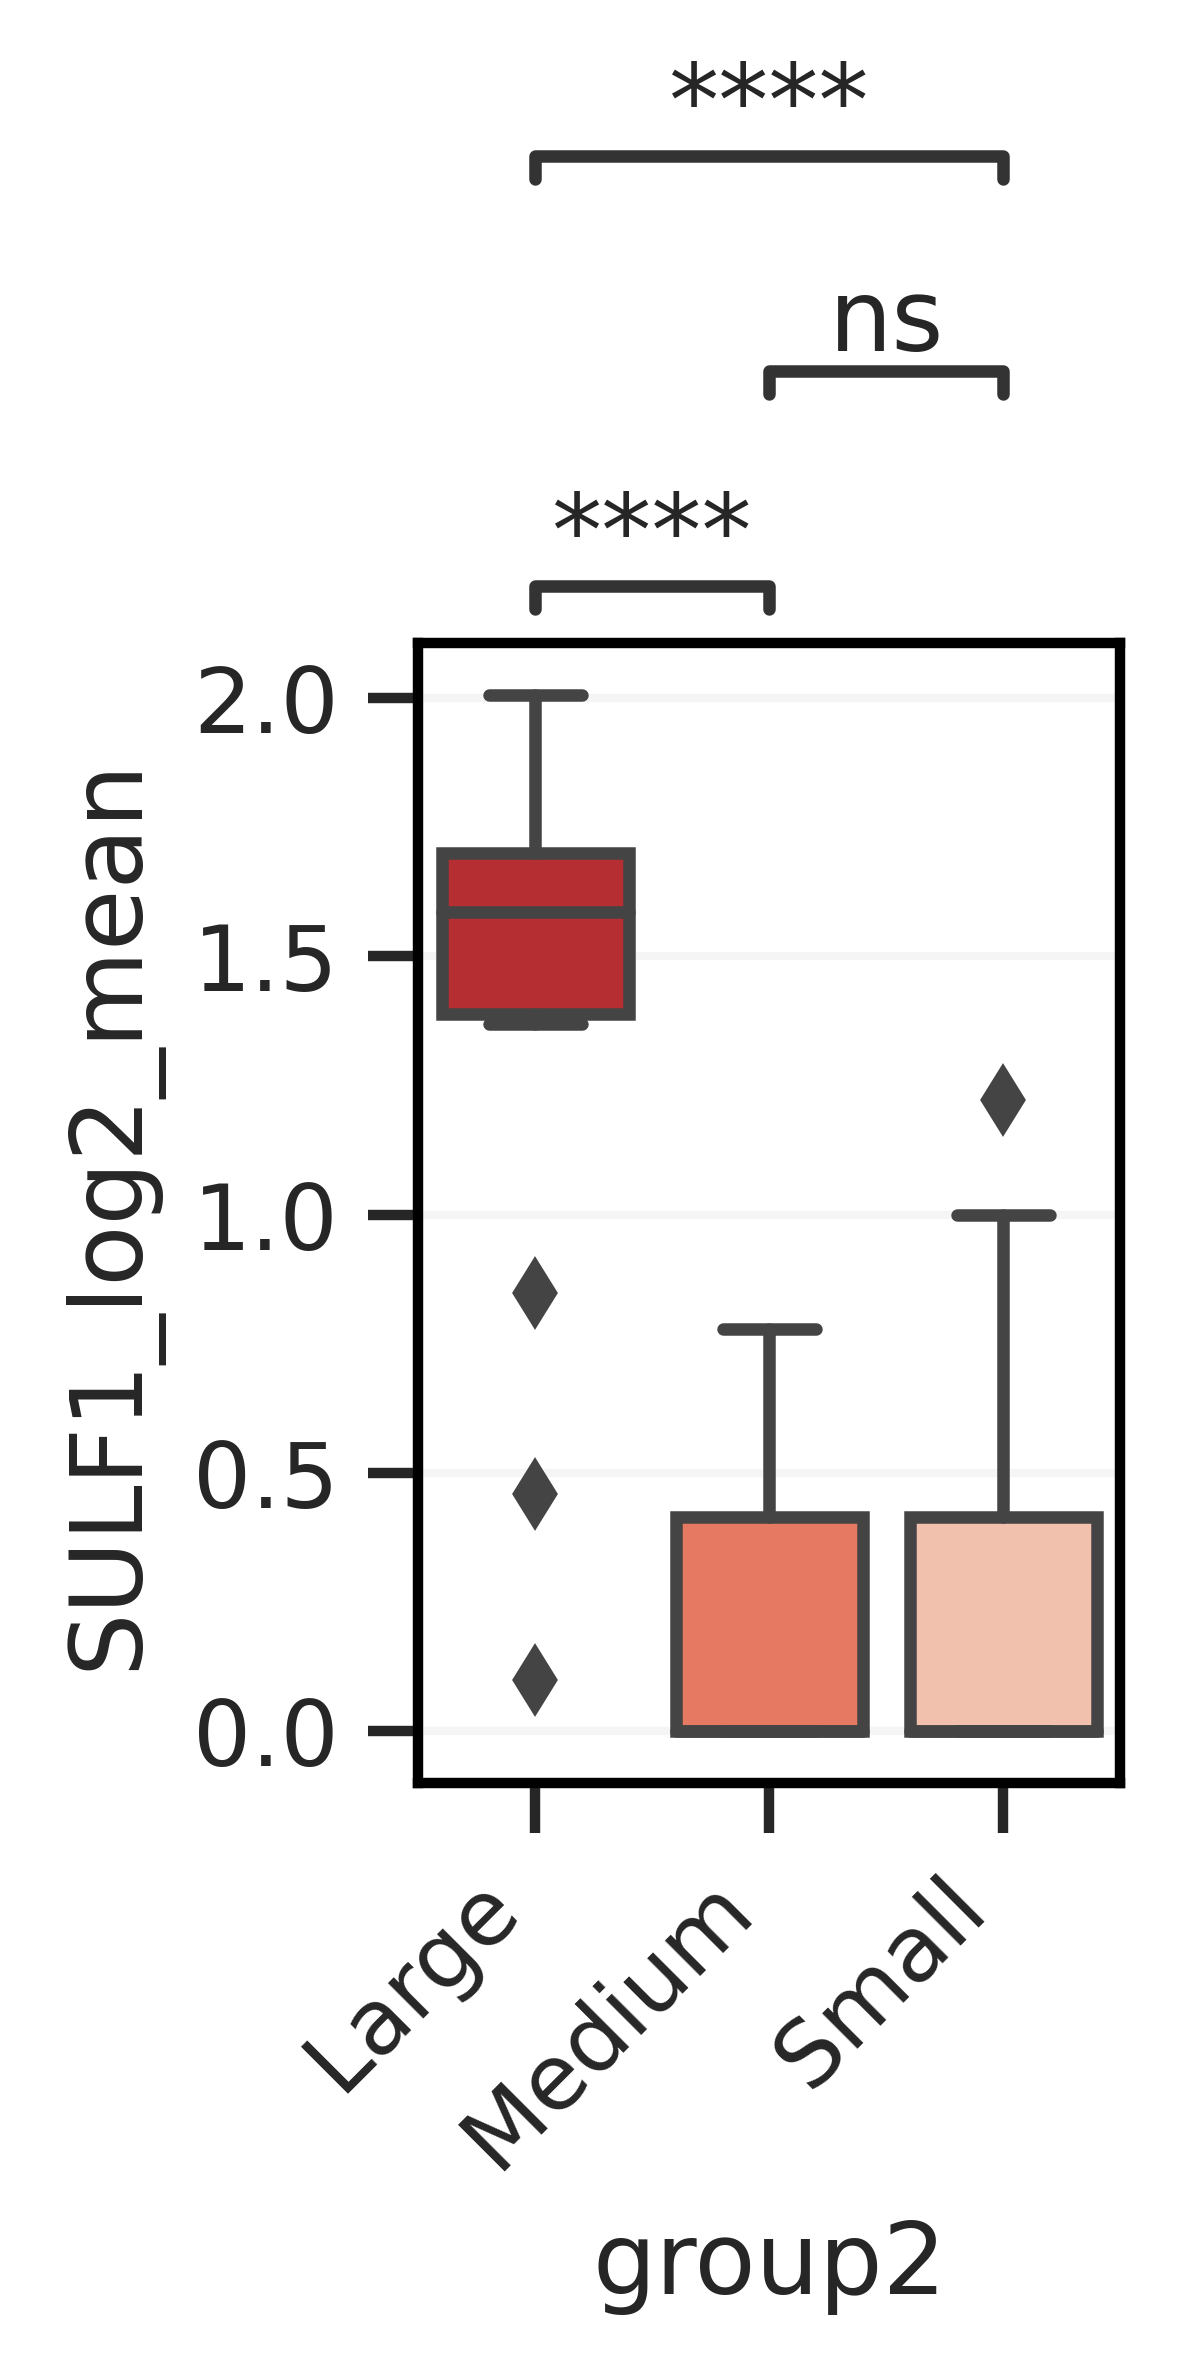

In [26]:
#SULF1 mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group2", y = "SULF1_log2_mean", palette = 'Reds_r', order = ['Large','Medium','Small'])
annotator = Annotator(ax, pairs2, data = df, x = "group2", y = "SULF1_log2_mean", palette = 'Reds_r', order = ['Large','Medium','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')
annotator.apply_and_annotate()
plt.show()

In [10]:
sns.set(rc={'figure.figsize':(3,5)})

[Text(0.5, 1.0, 'SULF1 mean expression')]

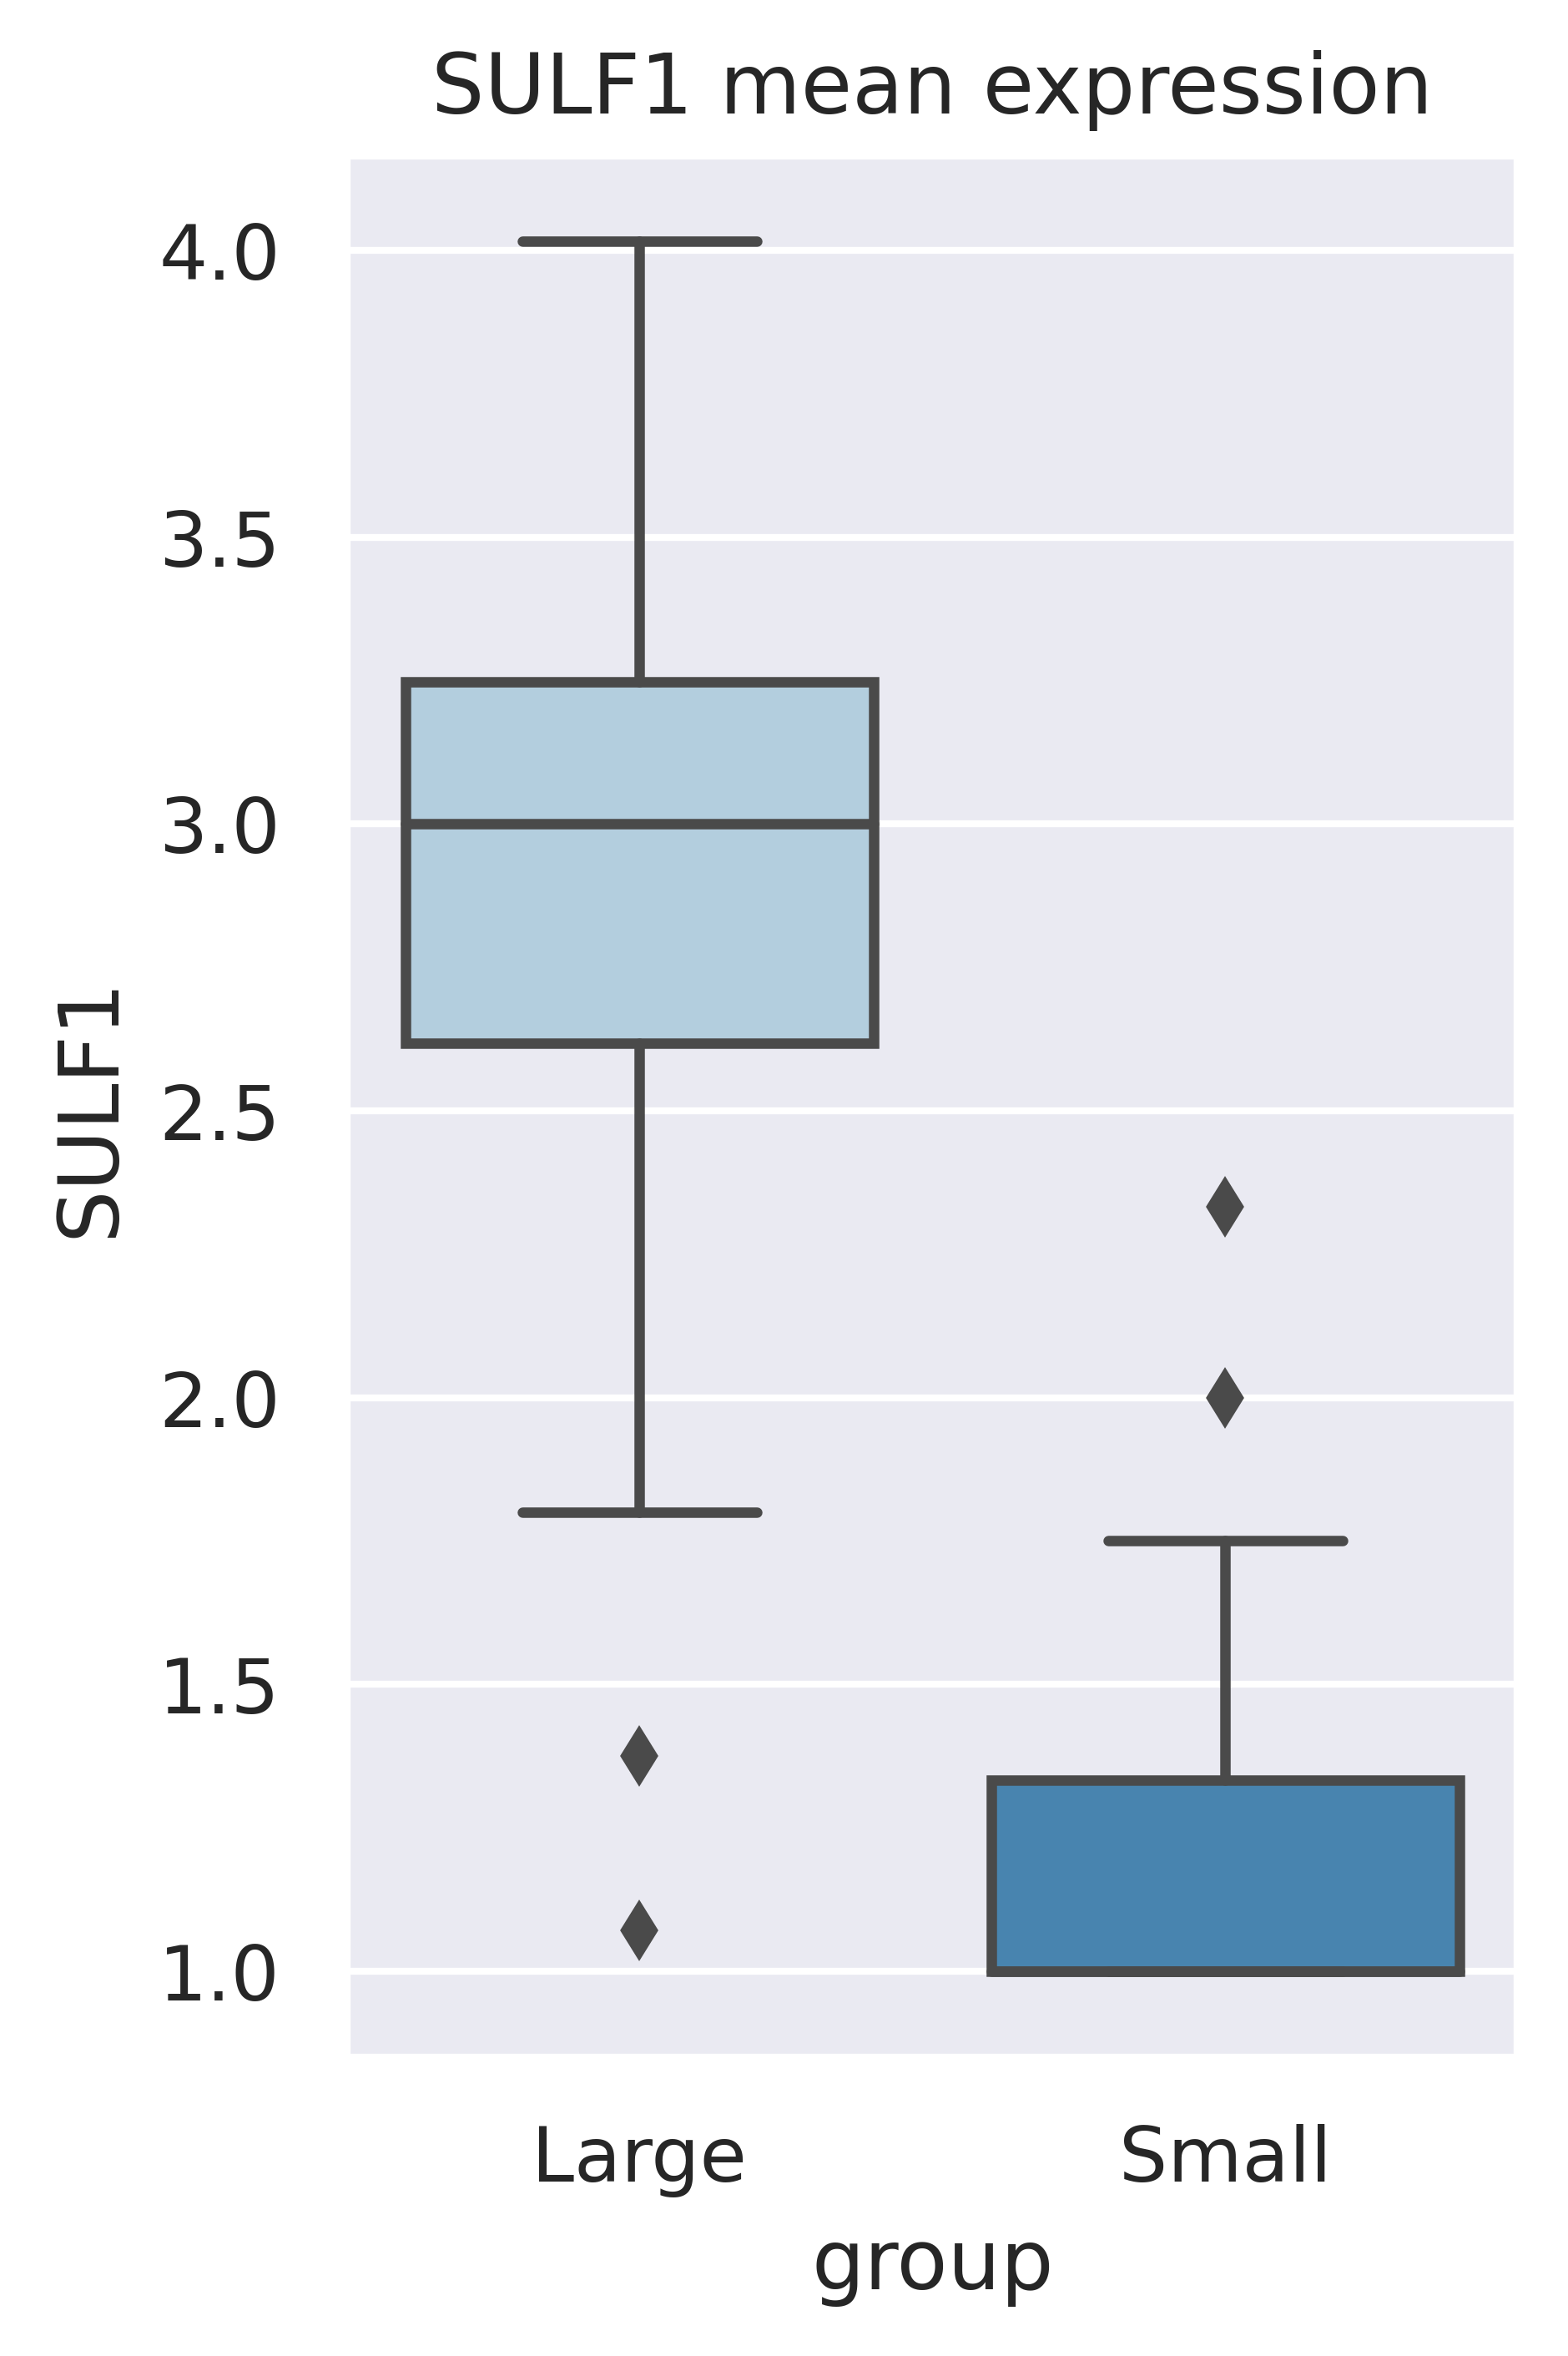

In [11]:
sns.boxplot(data = df, x = "group", y = "SULF1", palette = 'Blues', order = ['Large','Small']).set(title='SULF1 mean expression')

[Text(0.5, 1.0, 'SULF1 mean expression')]

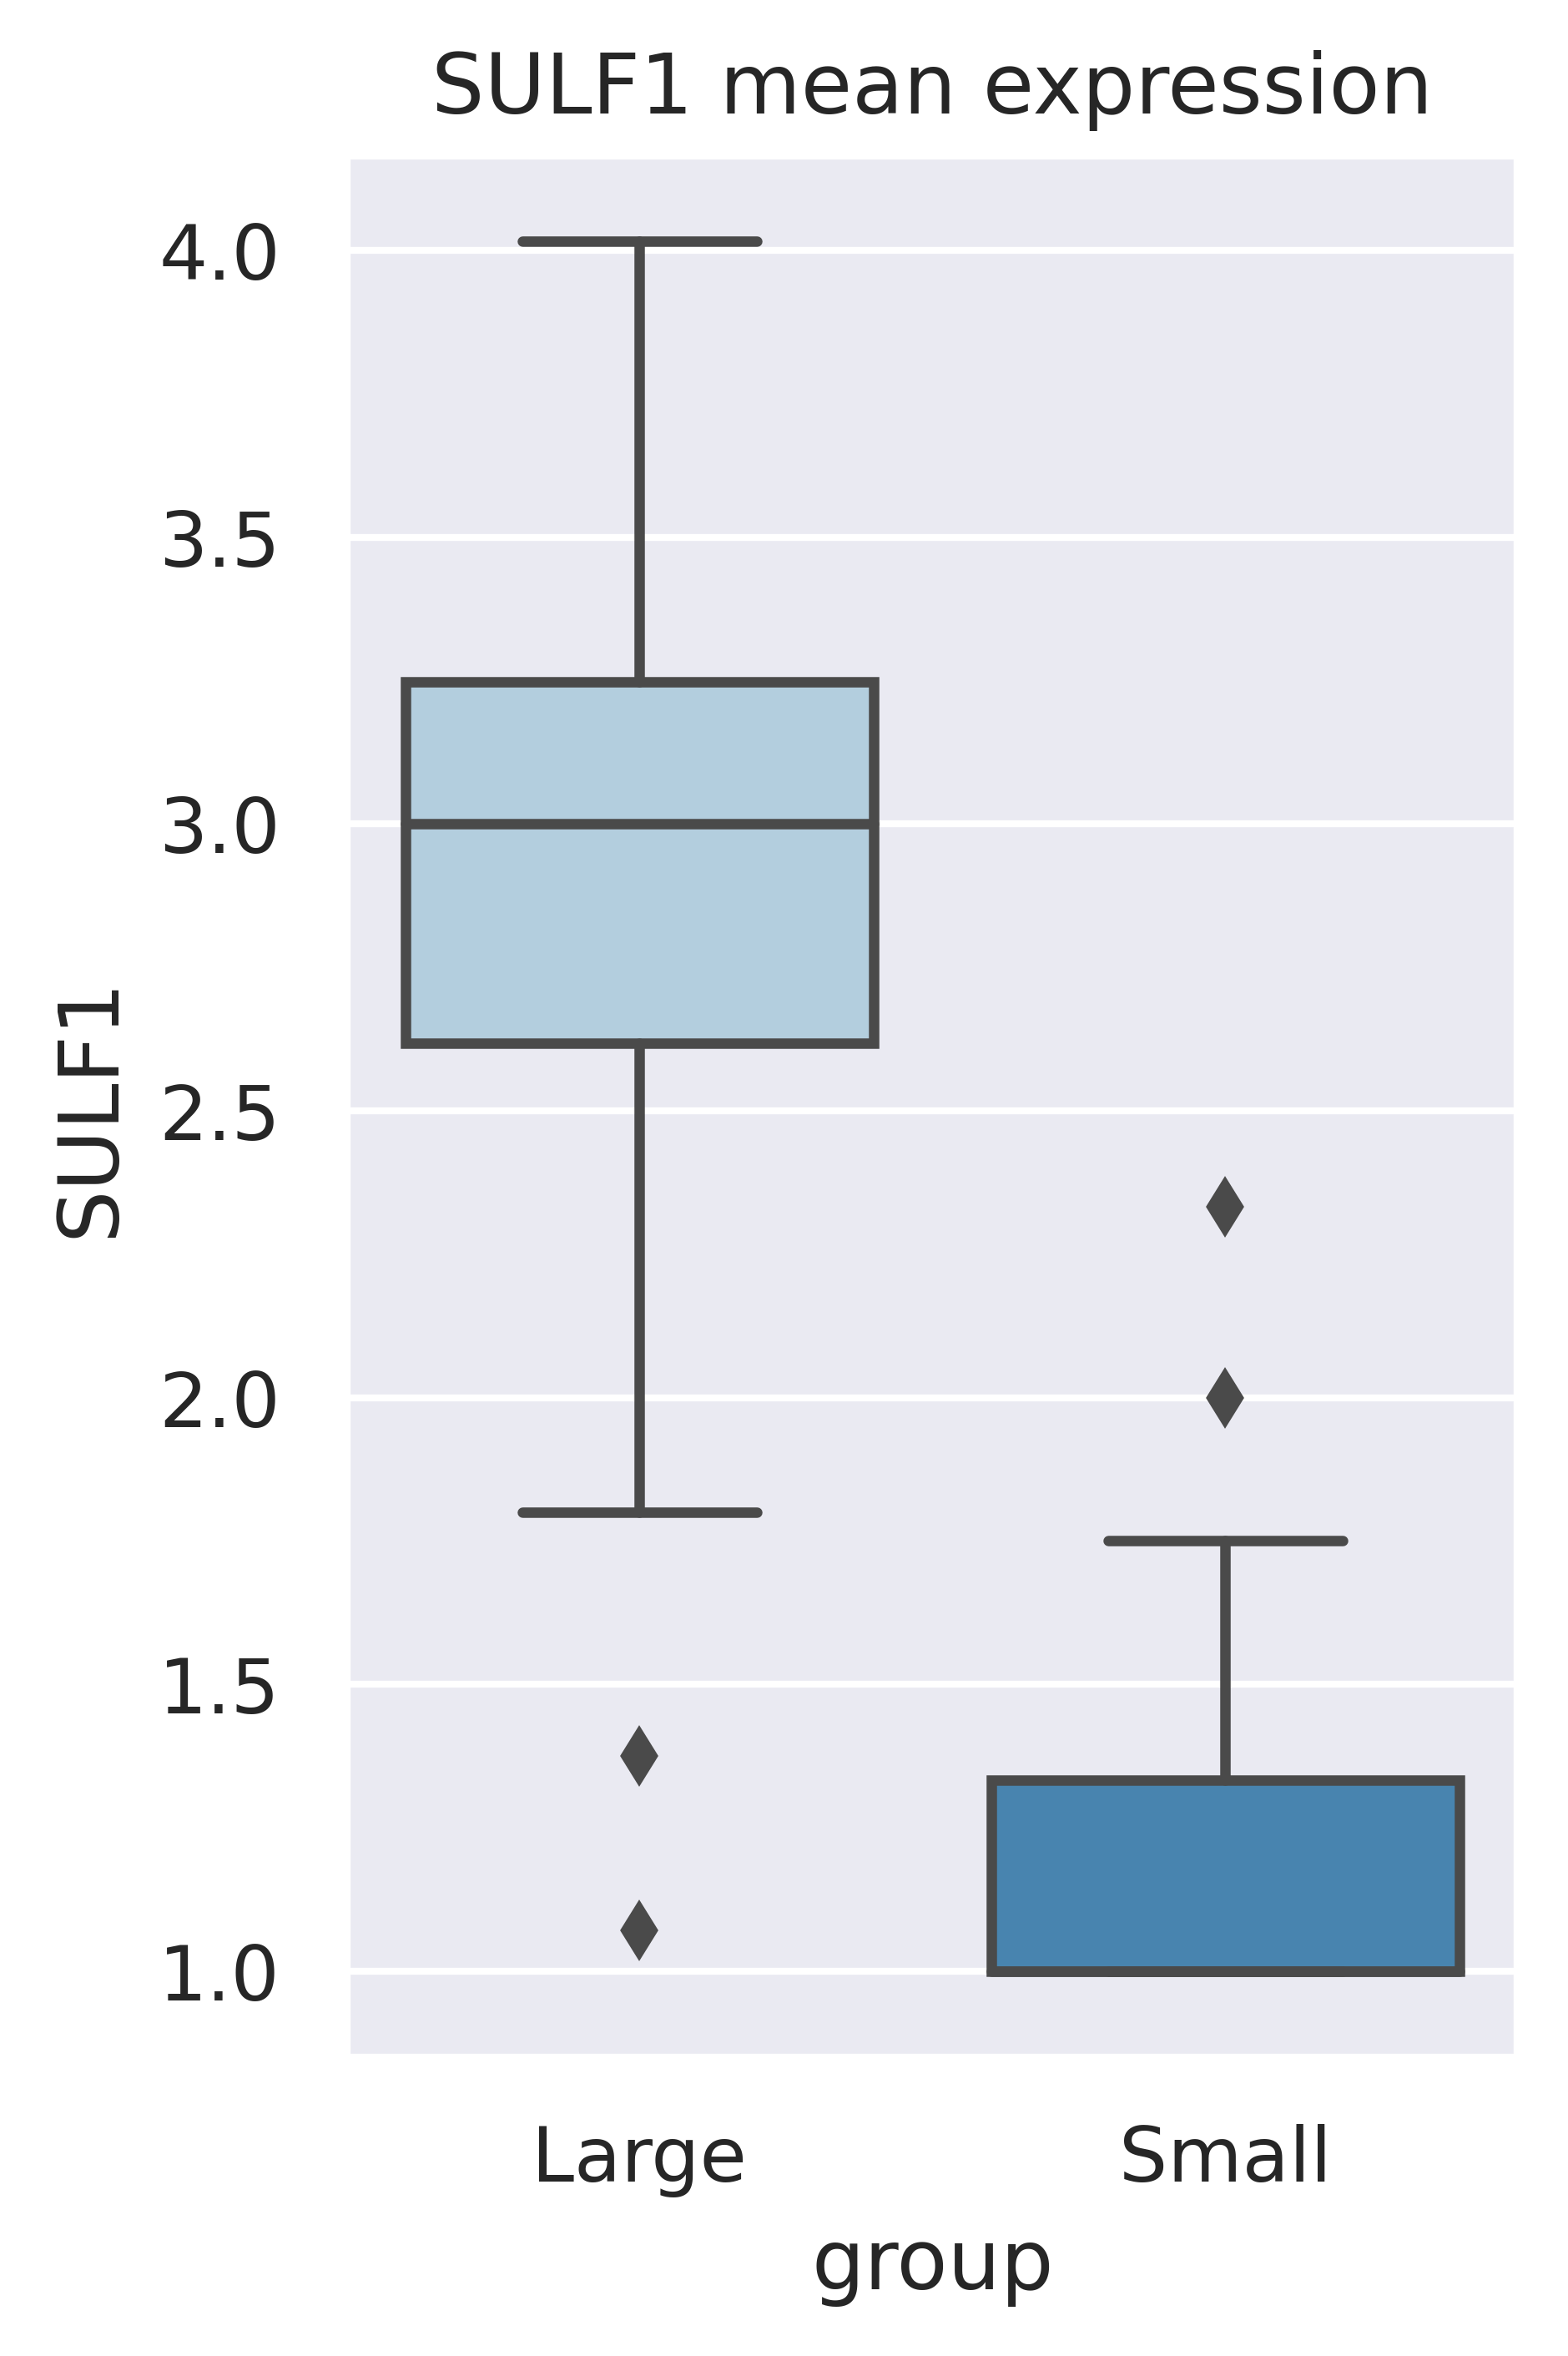

In [12]:
sns.boxplot(data = df, x = "group", y = "SULF1", palette = 'Blues', order = ['Large','Small']).set(title='SULF1 mean expression')

[Text(0.5, 1.0, 'SULF1 percent expressing')]

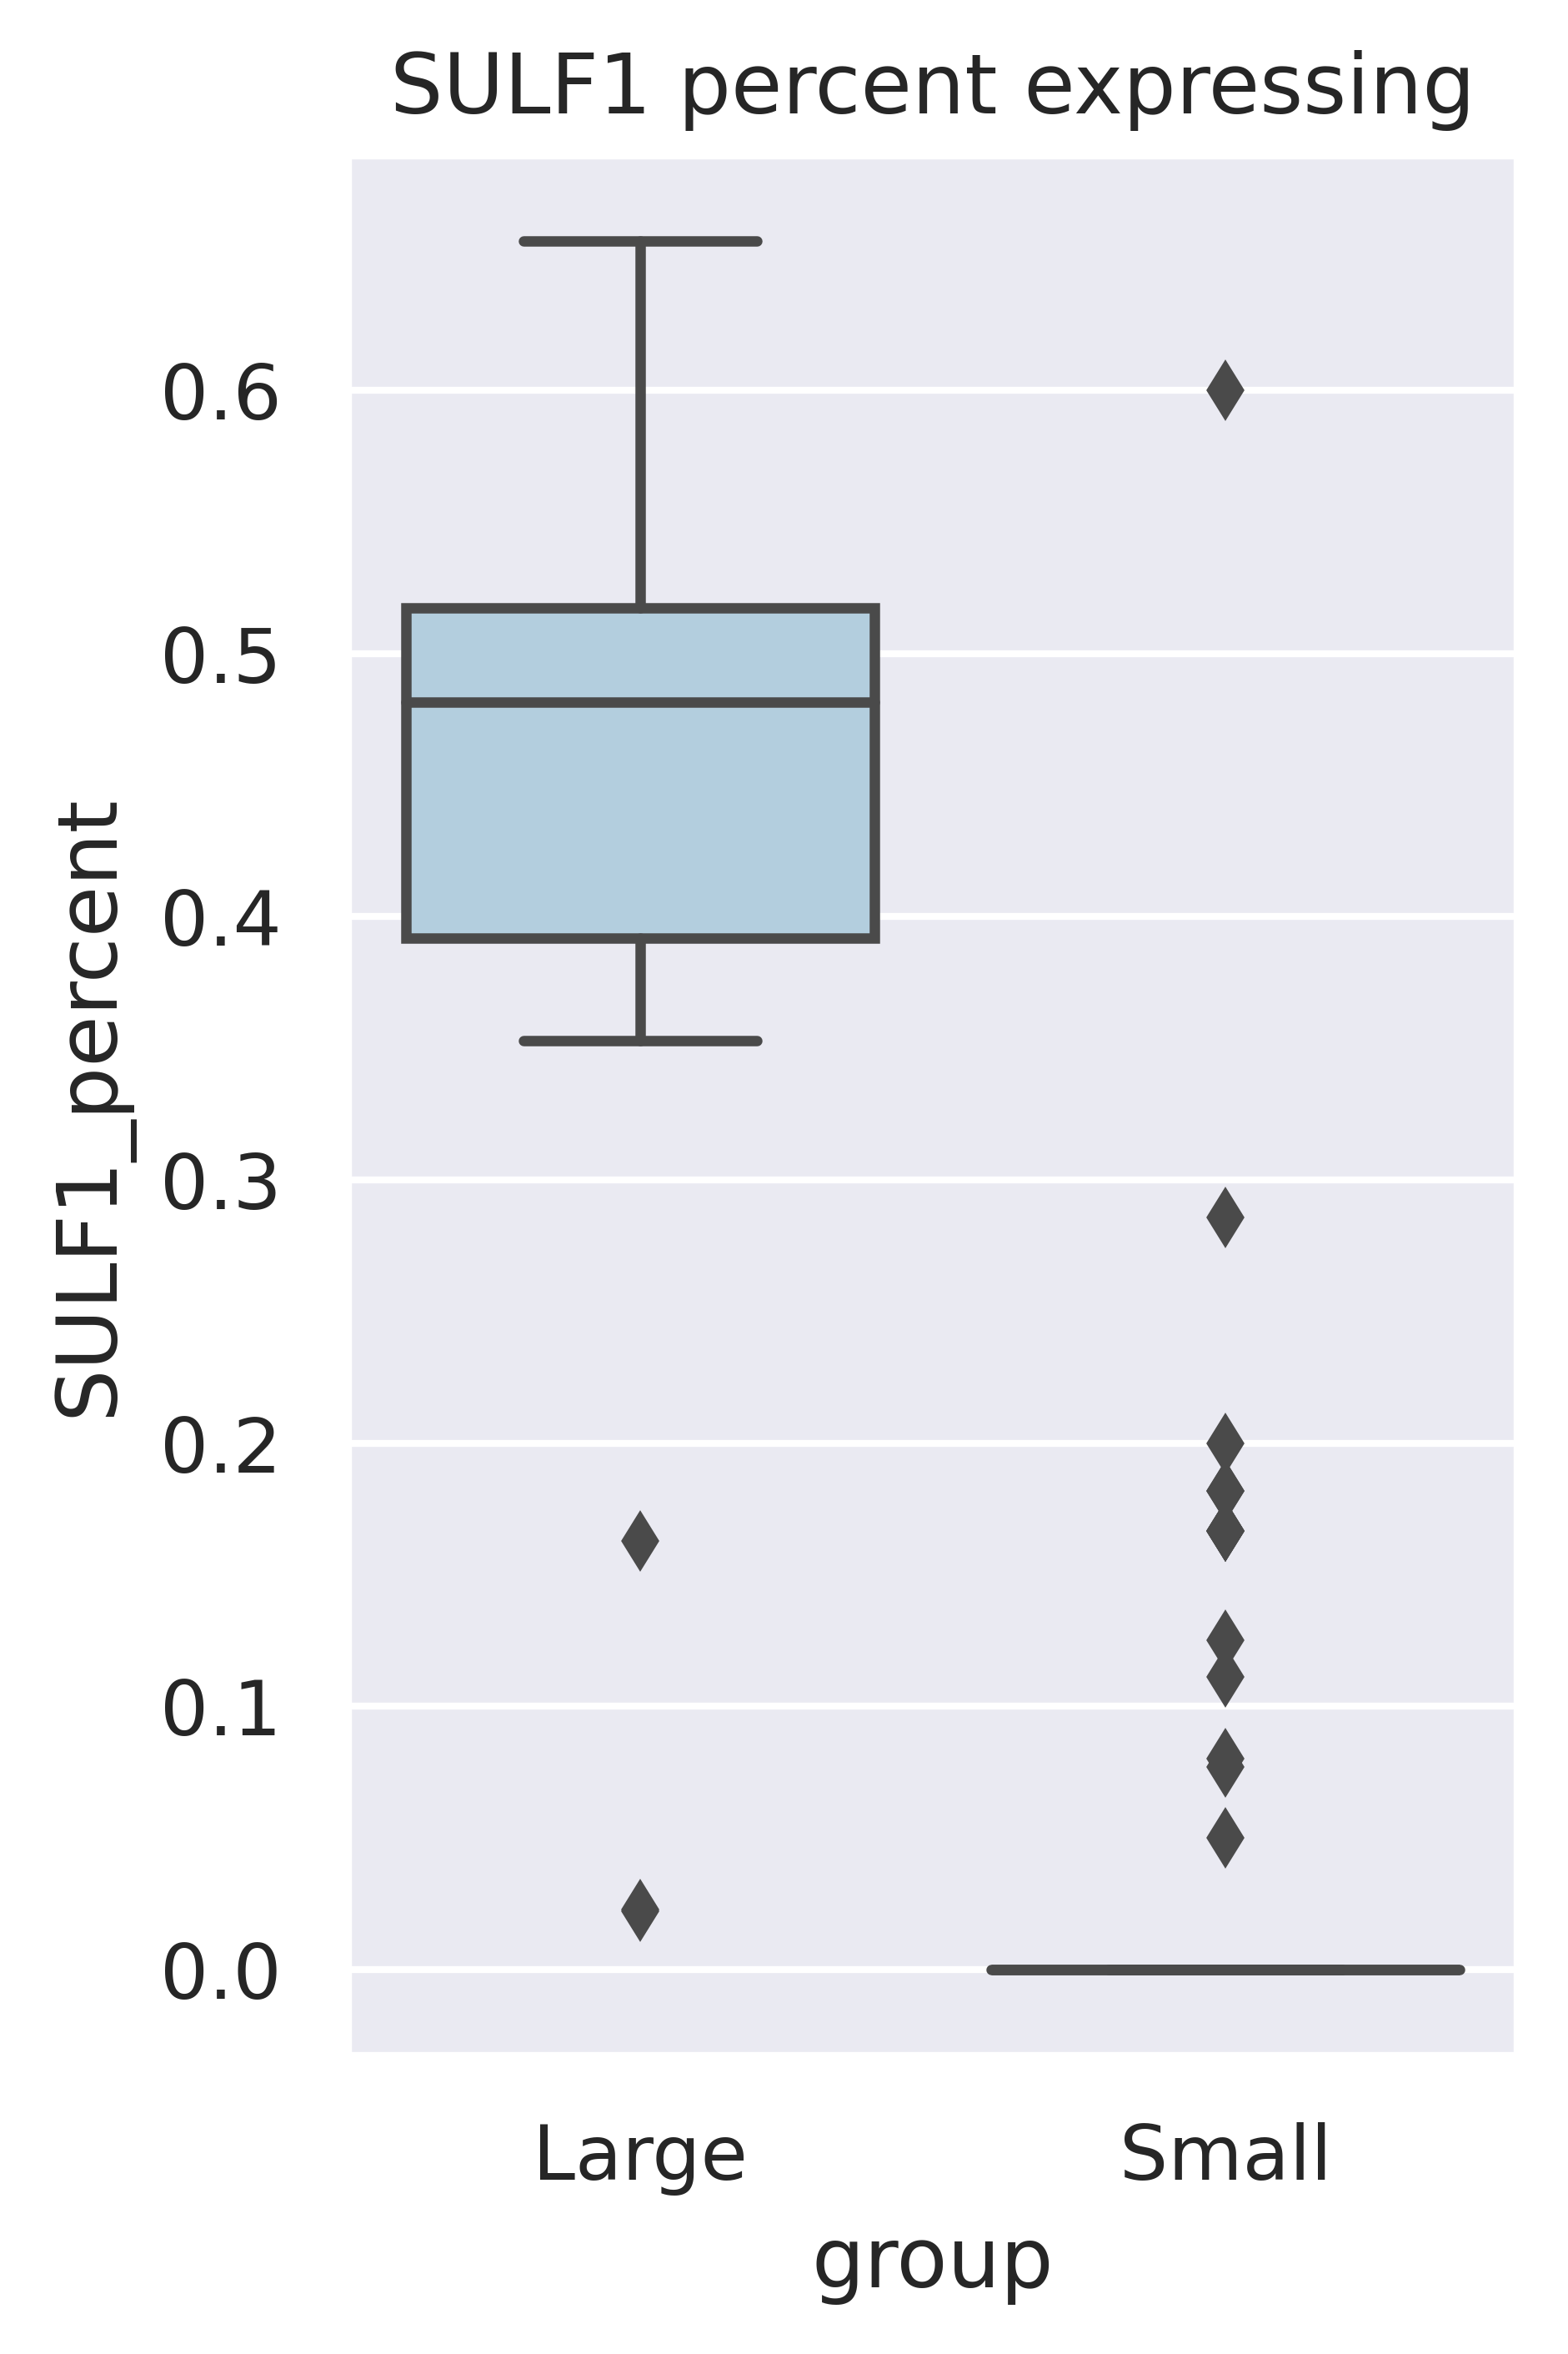

In [13]:
sns.boxplot(data = df, x = "group", y = "SULF1_percent", palette = 'Blues', order = ['Large','Small']).set(title='SULF1 percent expressing')

[Text(0.5, 1.0, 'NEBL mean expression')]

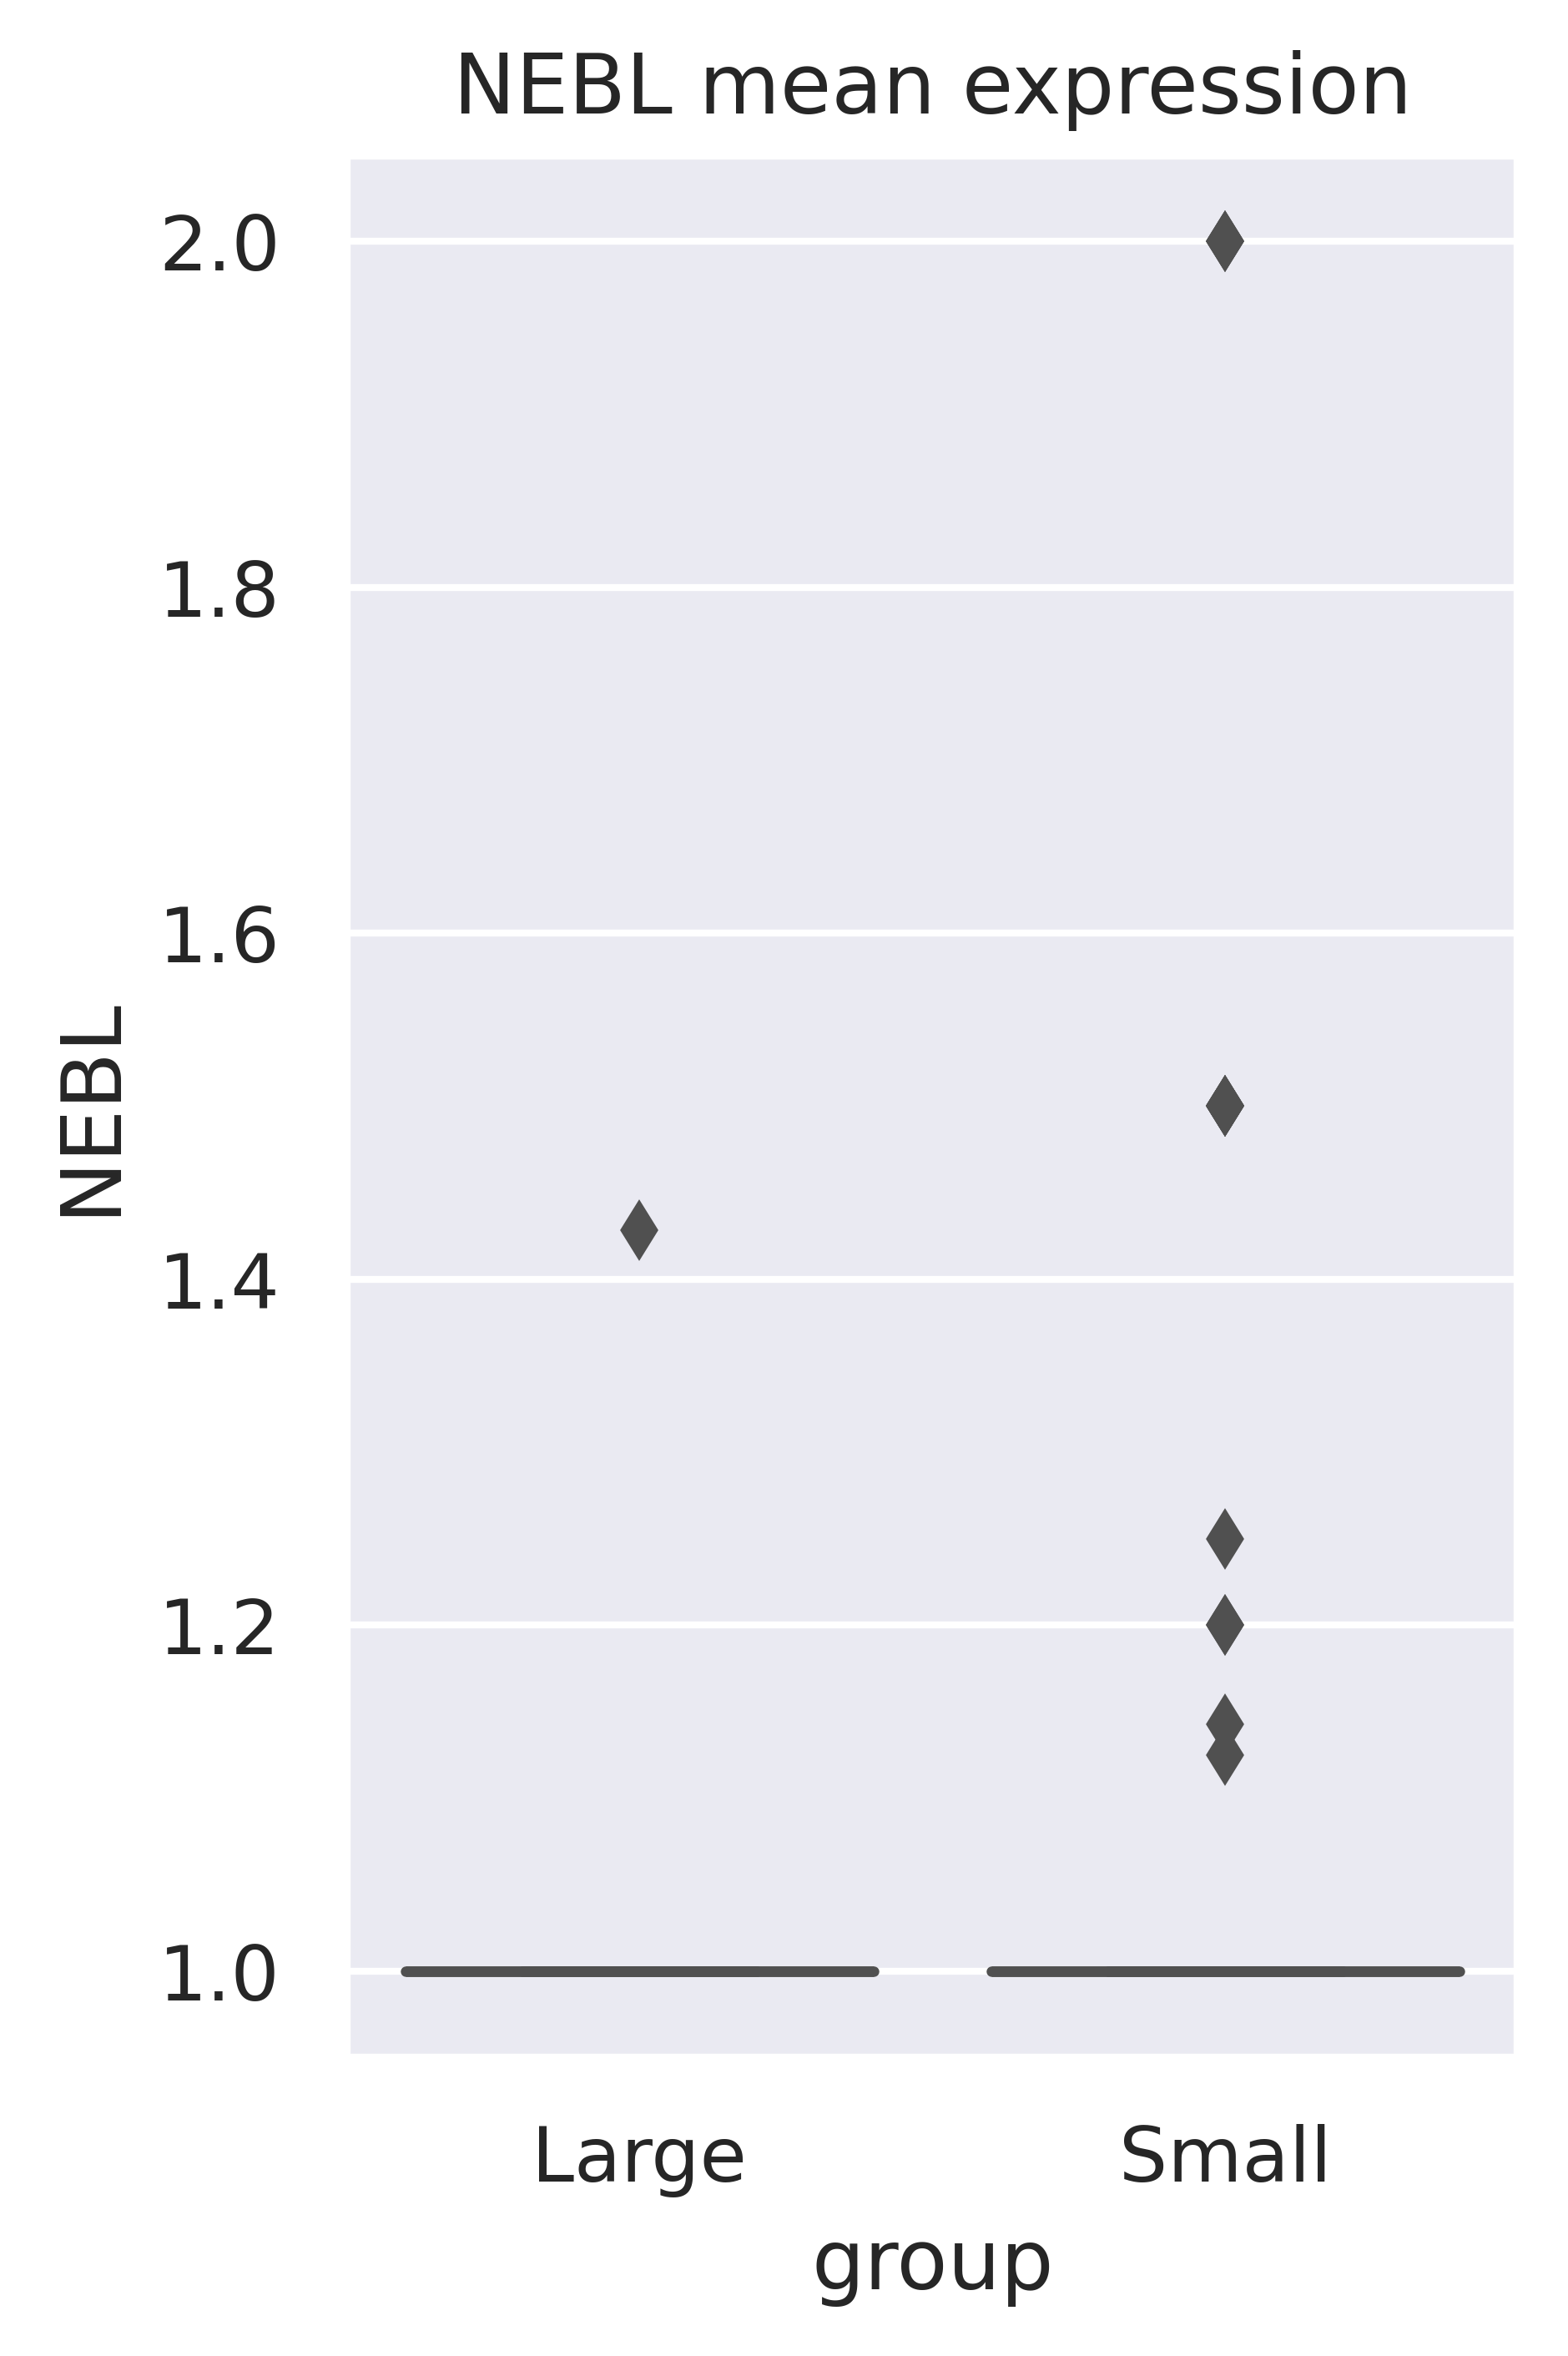

In [14]:
sns.boxplot(data = df, x = "group", y = "NEBL", palette = 'Reds', order = ['Large','Small']).set(title='NEBL mean expression')

[Text(0.5, 1.0, 'NEBL percent expressing')]

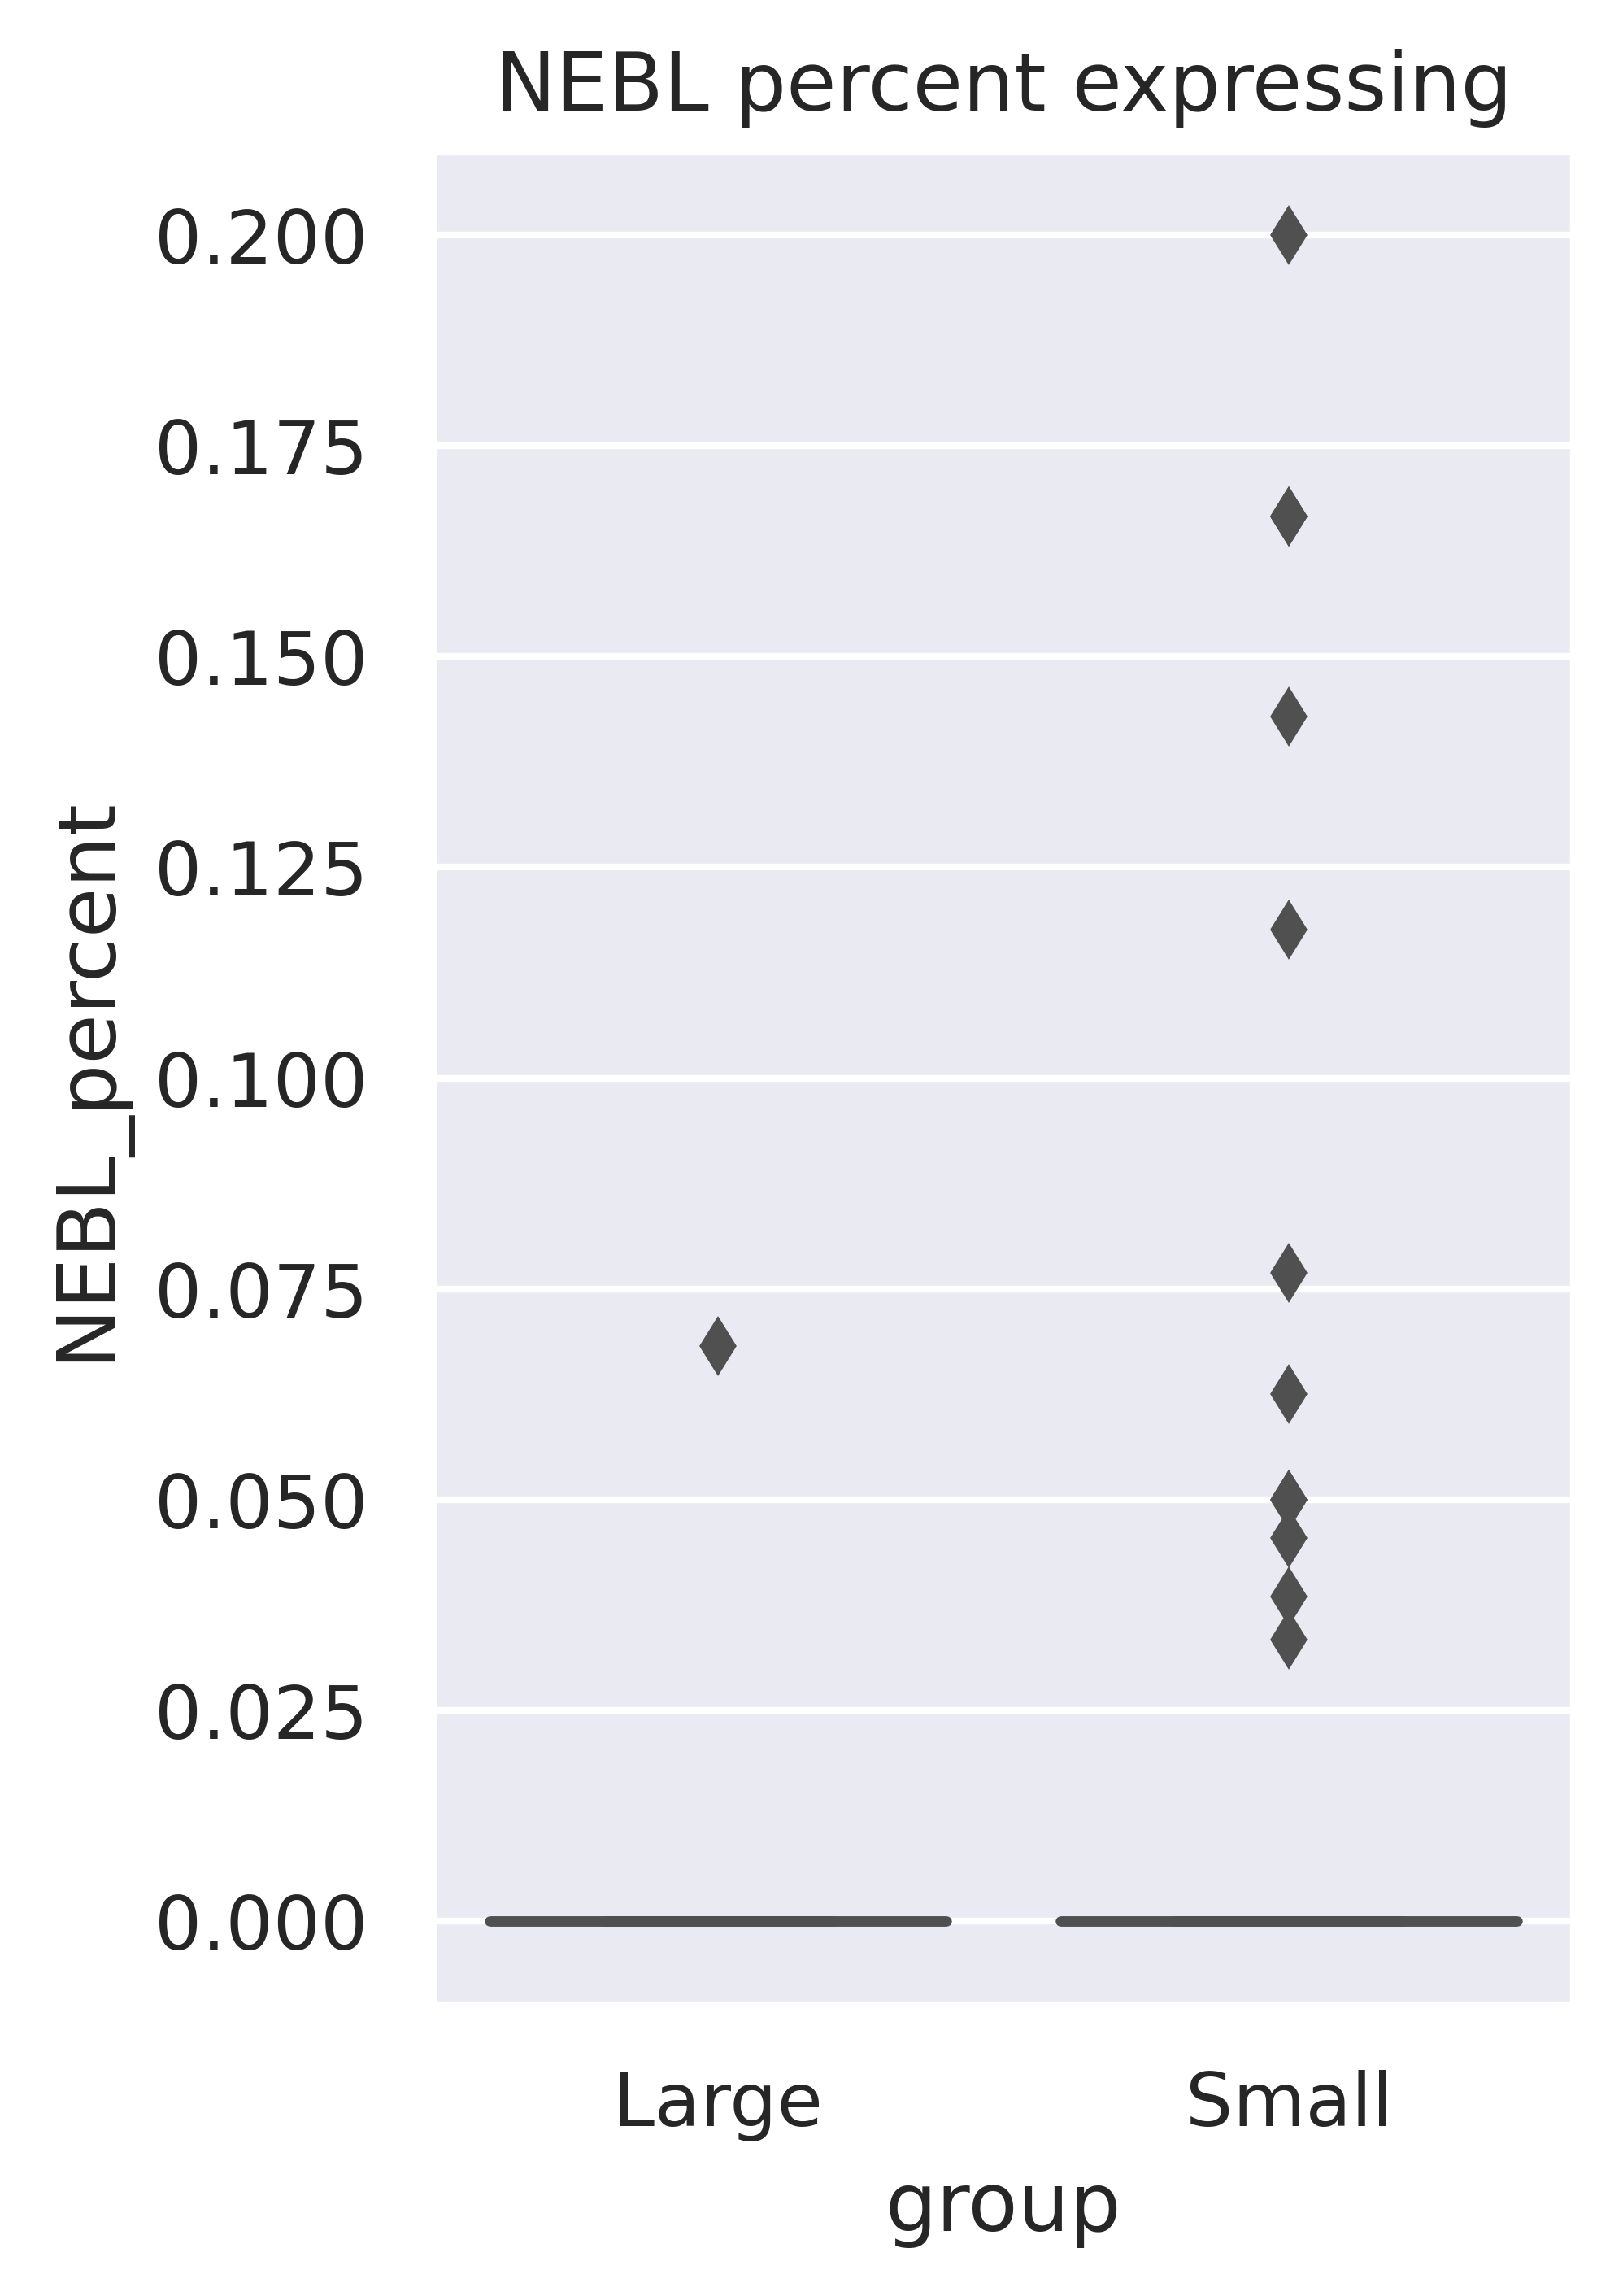

In [15]:
sns.boxplot(data = df, x = "group", y = "NEBL_percent", palette = 'Reds', order = ['Large','Small']).set(title='NEBL percent expressing')

[Text(0.5, 1.0, 'SULF1+NEBL percent expressing')]

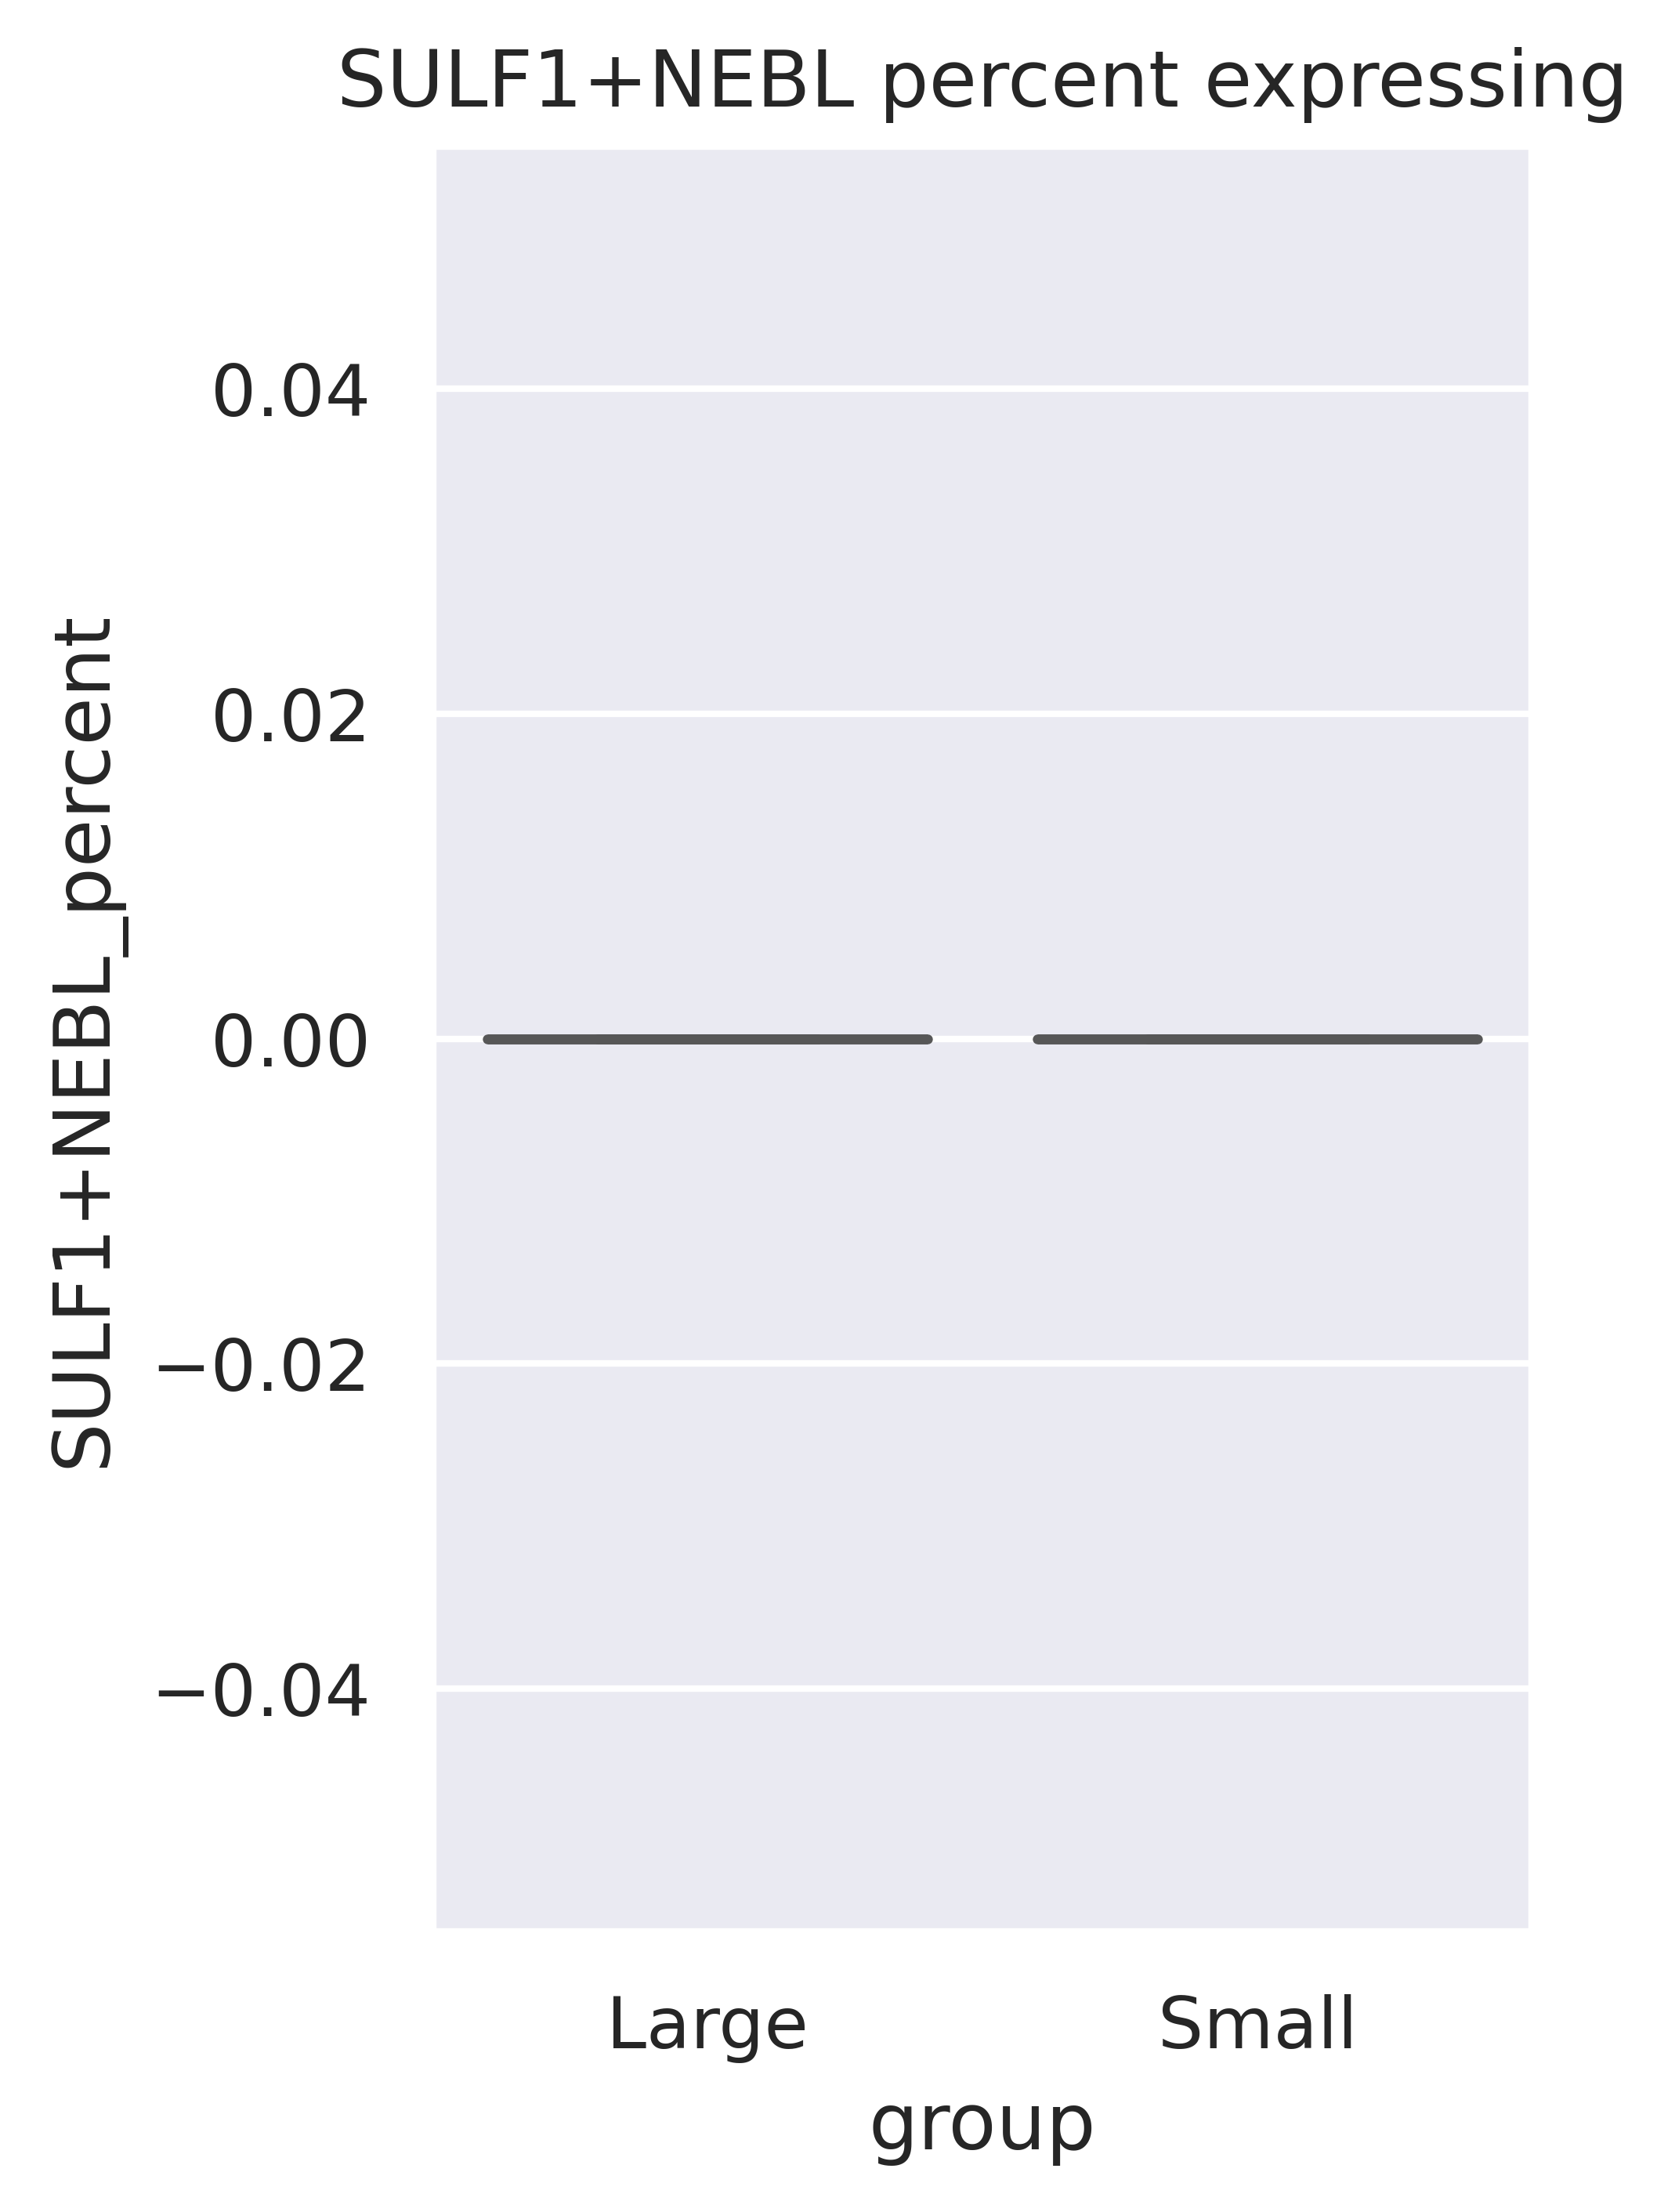

In [16]:
sns.boxplot(data = df, x = "group", y = "SULF1+NEBL_percent", palette = 'Purples', order = ['Large','Small']).set(title='SULF1+NEBL percent expressing')

[Text(0.5, 1.0, 'SEMA3G mean expression')]

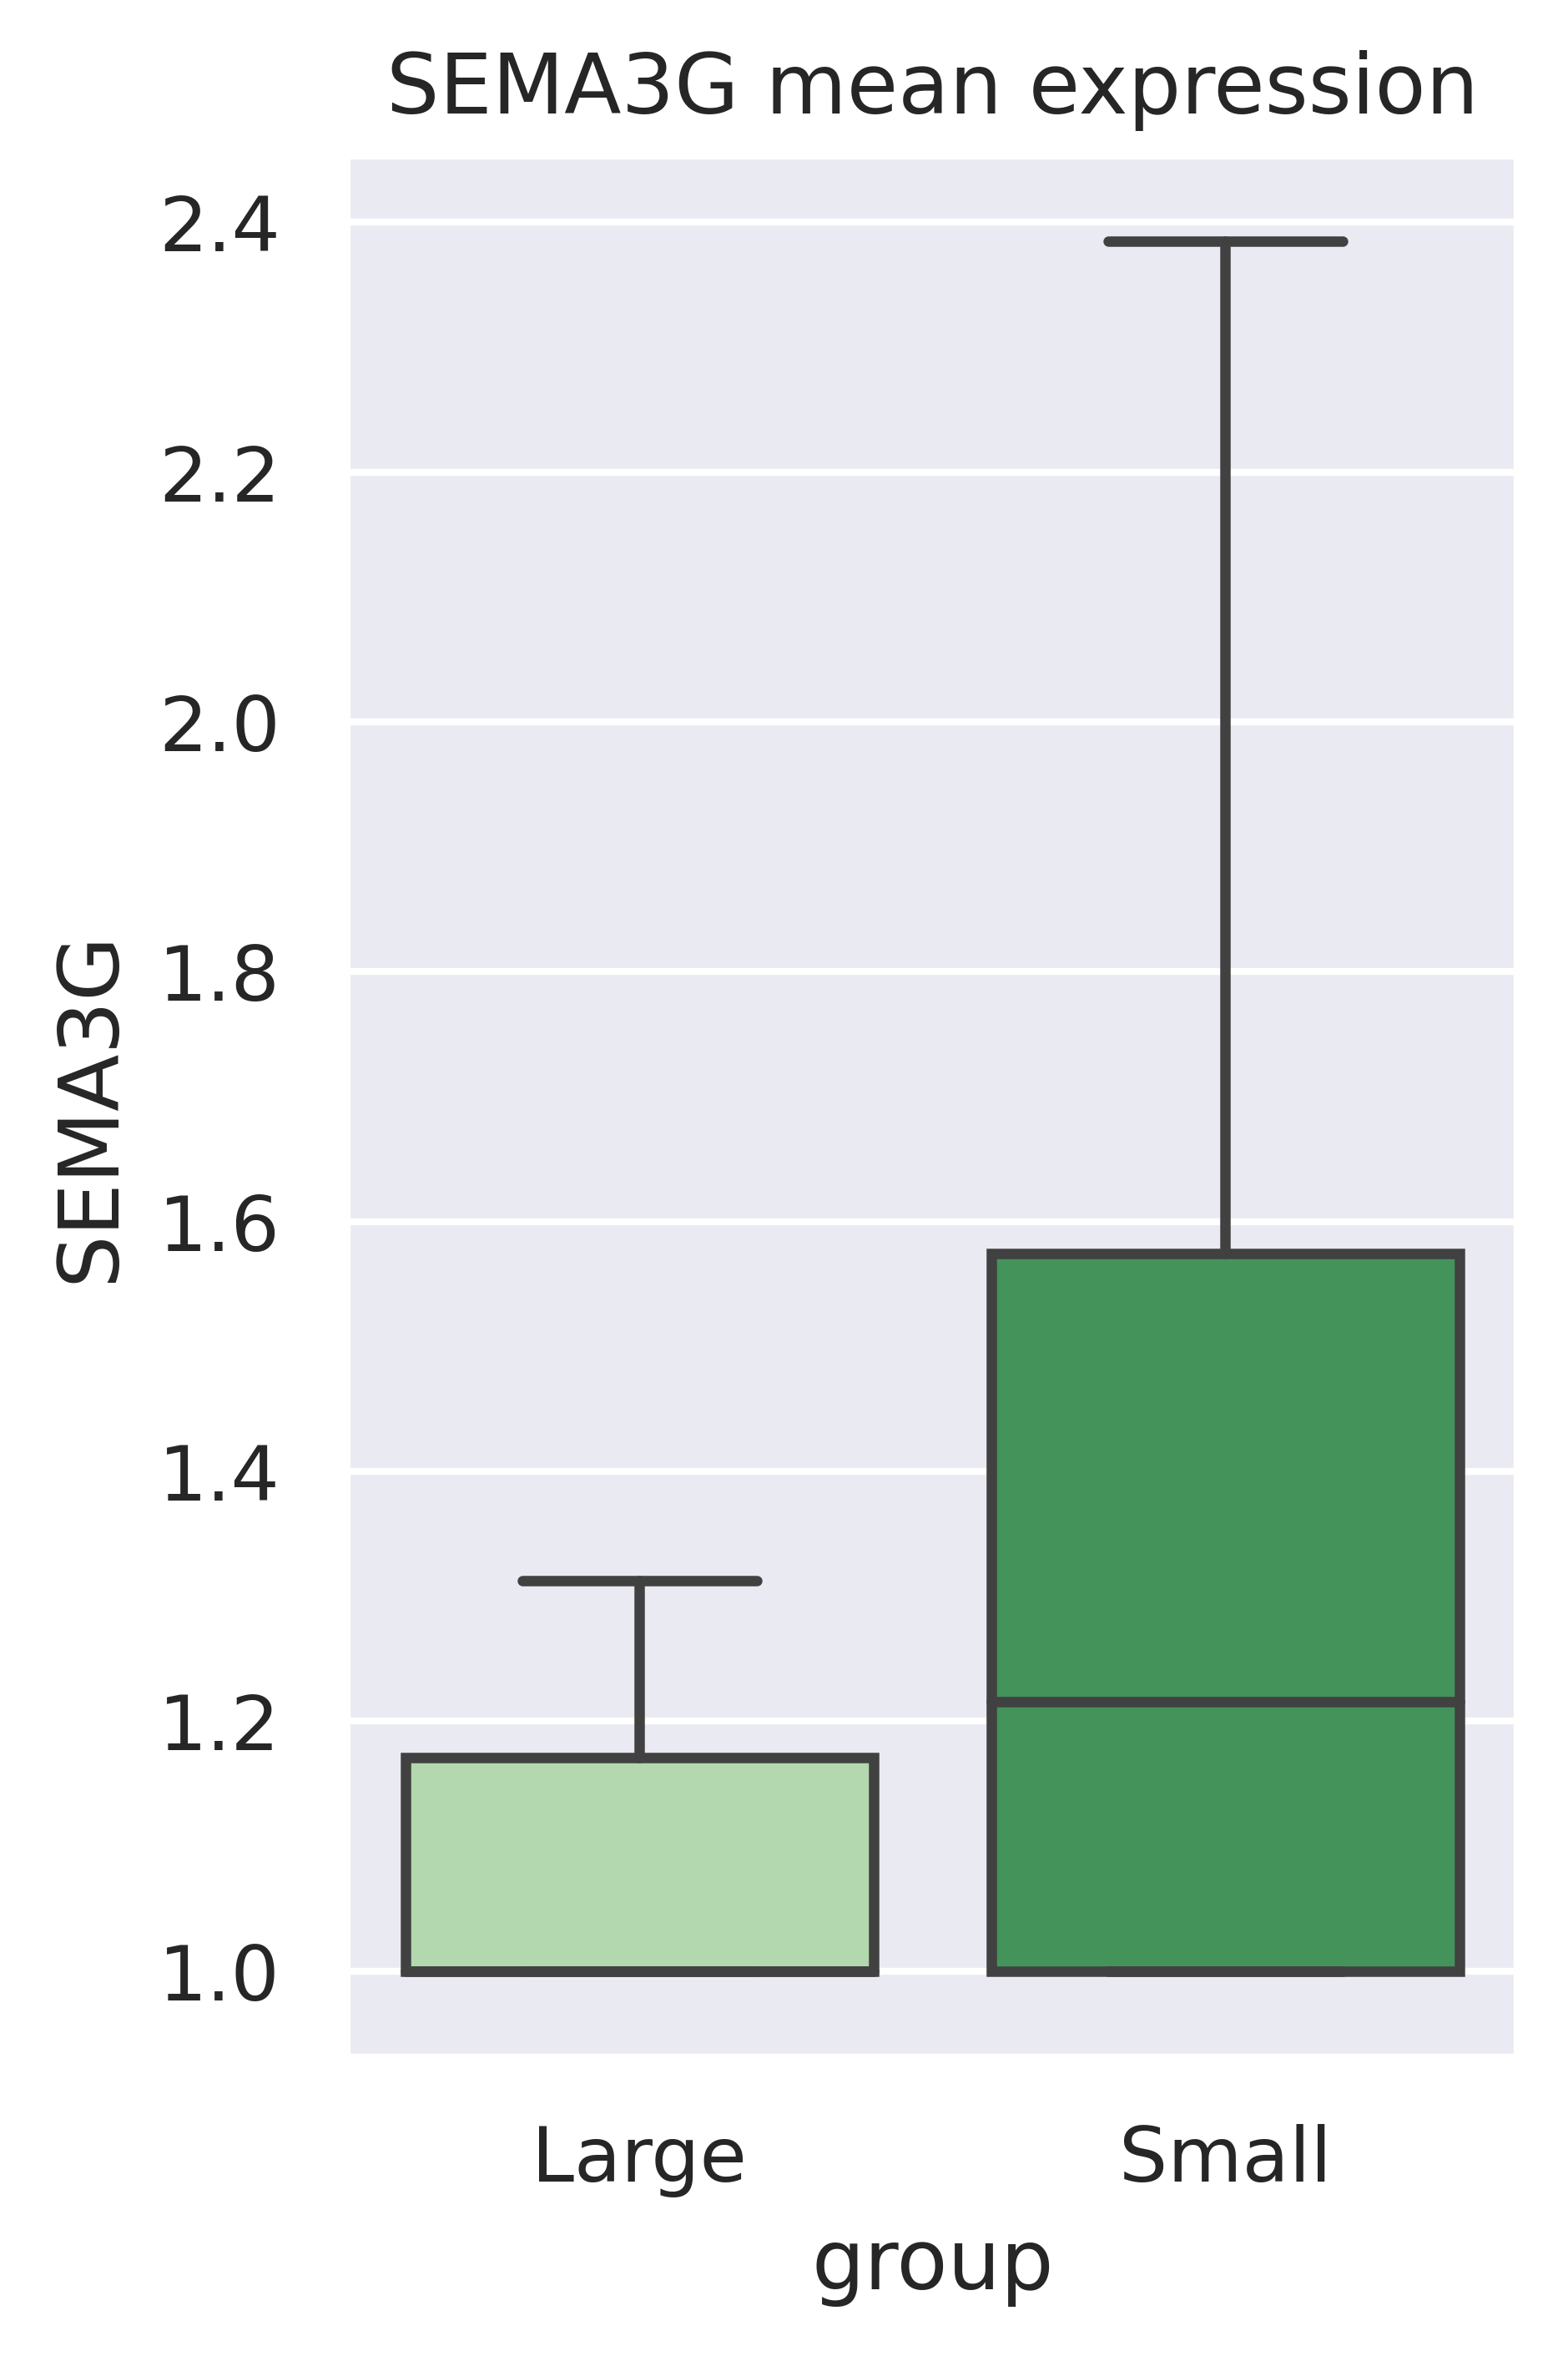

In [17]:
sns.boxplot(data = df, x = "group", y = "SEMA3G", palette = 'Greens', order = ['Large','Small']).set(title='SEMA3G mean expression')

[Text(0.5, 1.0, 'RGCC mean expression')]

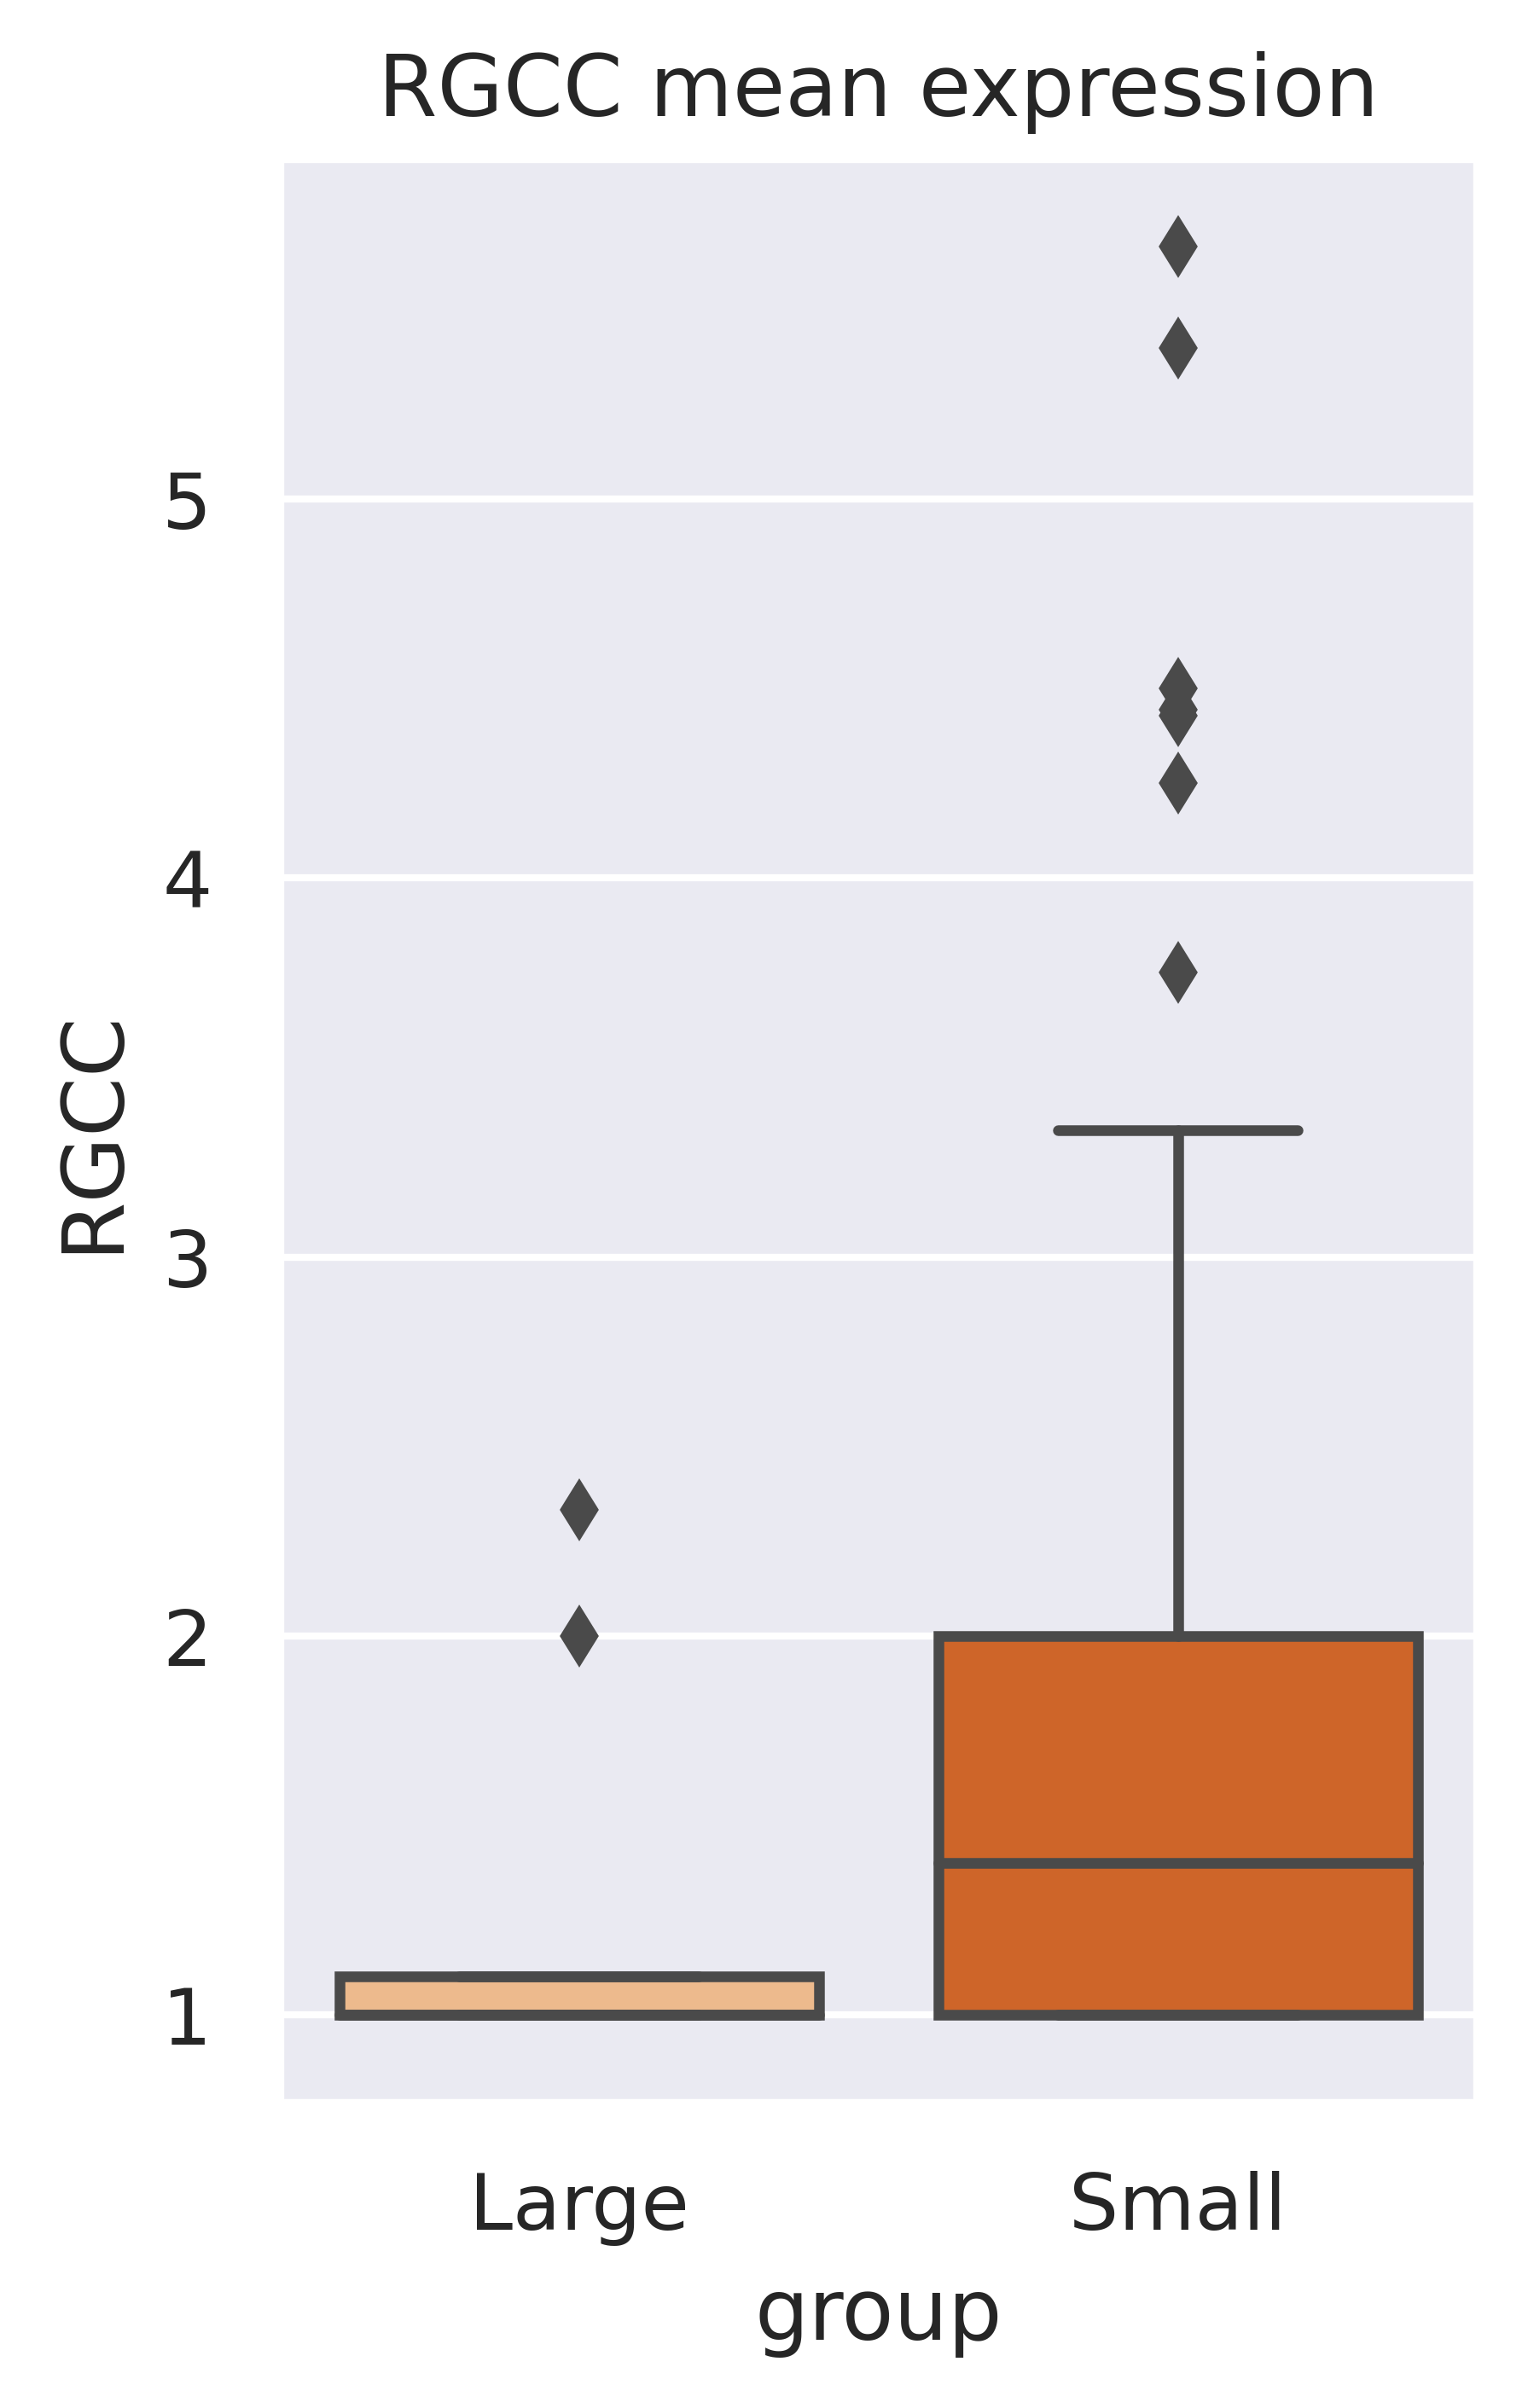

In [18]:
sns.boxplot(data = df, x = "group", y = "RGCC", palette = 'Oranges', order = ['Large','Small']).set(title='RGCC mean expression')

In [41]:
csv_files = glob.glob('*.{}'.format('csv'))
csv_files

['C2-2.csv', 'C2-3.csv', 'D1-1.csv', 'B1-1.csv']

In [55]:
print("C2-2.csv")

C2-2.csv


In [64]:
df_concat = pd.concat([pd.read_csv(f) for f in csv_files ], axis = 0, ignore_index = True)

In [65]:
df_concat

Unnamed: 0  SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  \
0   ROI_C2-2_0                 0.0       0.162791           0.0  1.800000   
1   ROI_C2-2_1                 0.0       0.000000           0.0       NaN   
2  ROI_C2-2_18                 0.0       0.000000           0.0       NaN   
3  ROI_C2-2_24                 0.0       0.000000           0.0       NaN   
4  ROI_C2-2_29                 0.0       0.000000           0.0       NaN   
5   ROI_C2-2_7                 0.0       0.022222           0.0  1.375000   
6   ROI_C2-3_0                 0.0       0.285714           0.0  1.750000   
7   ROI_D1-1_0                 0.0       0.656716           0.0  3.360656   
8   ROI_D1-1_6                 0.0       0.000000           0.0       NaN   
9   ROI_B2-2_0                 0.0       0.633333           0.0  3.958333   

   NEBL    SEMA3G      RGCC  size   ROI  group  
0   1.0  1.227273  1.000000    43  C2-2  Large  
1   1.0  1.000000  1.800000     8  C2-2  Small  
2   1.0  1.000000       NaN     6  C2-2  Small  
3   1.0  1.000000  2.500000     6  C2-2  Small  
4   1.0  2.000000       NaN     6  C2-2  Small  
5   1.0  1.066667  2.333333    45  C2-2  Large  
6   NaN       NaN       NaN     7  C2-3  Small  
7   1.0  1.312500       NaN    67  D1-1  Large  
8   1.0  1.000000  2.500000     7  D1-1  Small  
9   NaN  1.000000       NaN    60  B2-2  Large

In [68]:
del df_concat["index"]

KeyError: 'index'

In [67]:
df_concat

Unnamed: 0  SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  \
0   ROI_C2-2_0                 0.0       0.162791           0.0  1.800000   
1   ROI_C2-2_1                 0.0       0.000000           0.0       NaN   
2  ROI_C2-2_18                 0.0       0.000000           0.0       NaN   
3  ROI_C2-2_24                 0.0       0.000000           0.0       NaN   
4  ROI_C2-2_29                 0.0       0.000000           0.0       NaN   
5   ROI_C2-2_7                 0.0       0.022222           0.0  1.375000   
6   ROI_C2-3_0                 0.0       0.285714           0.0  1.750000   
7   ROI_D1-1_0                 0.0       0.656716           0.0  3.360656   
8   ROI_D1-1_6                 0.0       0.000000           0.0       NaN   
9   ROI_B2-2_0                 0.0       0.633333           0.0  3.958333   

   NEBL    SEMA3G      RGCC  size   ROI  group  
0   1.0  1.227273  1.000000    43  C2-2  Large  
1   1.0  1.000000  1.800000     8  C2-2  Small  
2   1.0  1.000000       NaN     6  C2-2  Small  
3   1.0  1.000000  2.500000     6  C2-2  Small  
4   1.0  2.000000       NaN     6  C2-2  Small  
5   1.0  1.066667  2.333333    45  C2-2  Large  
6   NaN       NaN       NaN     7  C2-3  Small  
7   1.0  1.312500       NaN    67  D1-1  Large  
8   1.0  1.000000  2.500000     7  D1-1  Small  
9   NaN  1.000000       NaN    60  B2-2  Large

In [15]:
df1 = pd.read_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/D1-1.csv", index_col = 0)

In [16]:
df1

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  NEBL  \
ROI_D1-1_0                 0.0       0.656716           0.0  3.360656   1.0   
ROI_D1-1_6                 0.0       0.000000           0.0       NaN   1.0   

            SEMA3G  RGCC  size   ROI  group  
ROI_D1-1_0  1.3125   NaN    67  D1-1  Large  
ROI_D1-1_6  1.0000   2.5     7  D1-1  Small

In [17]:
df2 = pd.read_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/B1-1.csv", index_col = 0)

In [18]:
df2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  NEBL  \
ROI_B2-2_0                 0.0       0.633333           0.0  3.958333   NaN   

            SEMA3G  RGCC  size   ROI  group  
ROI_B2-2_0     1.0   NaN    60  B2-2  Large

In [69]:
df3 = pd.read_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/C2-2.csv", index_col = 0)

In [70]:
df3

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  SULF1  NEBL  \
ROI_C2-2_0                  0.0       0.162791           0.0  1.800   1.0   
ROI_C2-2_1                  0.0       0.000000           0.0    NaN   1.0   
ROI_C2-2_18                 0.0       0.000000           0.0    NaN   1.0   
ROI_C2-2_24                 0.0       0.000000           0.0    NaN   1.0   
ROI_C2-2_29                 0.0       0.000000           0.0    NaN   1.0   
ROI_C2-2_7                  0.0       0.022222           0.0  1.375   1.0   

               SEMA3G      RGCC  size   ROI  group  
ROI_C2-2_0   1.227273  1.000000    43  C2-2  Large  
ROI_C2-2_1   1.000000  1.800000     8  C2-2  Small  
ROI_C2-2_18  1.000000       NaN     6  C2-2  Small  
ROI_C2-2_24  1.000000  2.500000     6  C2-2  Small  
ROI_C2-2_29  2.000000       NaN     6  C2-2  Small  
ROI_C2-2_7   1.066667  2.333333    45  C2-2  Large

In [71]:
df1.index.name = "ROI_cluster"
df2.index.name = "ROI_cluster"
df3.index.name = "ROI_cluster"

In [36]:
df1

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  NEBL  \
ROI_cluster                                                                    
ROI_D1-1_0                  0.0       0.656716           0.0  3.360656   1.0   
ROI_D1-1_6                  0.0       0.000000           0.0       NaN   1.0   

             SEMA3G  RGCC  size   ROI  group  
ROI_cluster                                   
ROI_D1-1_0   1.3125   NaN    67  D1-1  Large  
ROI_D1-1_6   1.0000   2.5     7  D1-1  Small

In [37]:
df2

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  NEBL  \
ROI_cluster                                                                    
ROI_B2-2_0                  0.0       0.633333           0.0  3.958333   NaN   

             SEMA3G  RGCC  size   ROI  group  
ROI_cluster                                   
ROI_B2-2_0      1.0   NaN    60  B2-2  Large

In [72]:
df3

SULF1+NEBL_percent  SULF1_percent  NEBL_percent  SULF1  NEBL  \
ROI_cluster                                                                 
ROI_C2-2_0                  0.0       0.162791           0.0  1.800   1.0   
ROI_C2-2_1                  0.0       0.000000           0.0    NaN   1.0   
ROI_C2-2_18                 0.0       0.000000           0.0    NaN   1.0   
ROI_C2-2_24                 0.0       0.000000           0.0    NaN   1.0   
ROI_C2-2_29                 0.0       0.000000           0.0    NaN   1.0   
ROI_C2-2_7                  0.0       0.022222           0.0  1.375   1.0   

               SEMA3G      RGCC  size   ROI  group  
ROI_cluster                                         
ROI_C2-2_0   1.227273  1.000000    43  C2-2  Large  
ROI_C2-2_1   1.000000  1.800000     8  C2-2  Small  
ROI_C2-2_18  1.000000       NaN     6  C2-2  Small  
ROI_C2-2_24  1.000000  2.500000     6  C2-2  Small  
ROI_C2-2_29  2.000000       NaN     6  C2-2  Small  
ROI_C2-2_7   1.066667  2.333333    45  C2-2  Large

In [73]:
list = ["ROI_cluster","SULF1+NEBL_percent","SULF1_percent","NEBL_percent","SULF1","NEBL","SEMA3G","RGCC","size","ROI","group"]
df_master = df1.merge(df2, on = list, how = 'outer')

In [74]:
df_master

SULF1+NEBL_percent  SULF1_percent  NEBL_percent     SULF1  NEBL  \
ROI_cluster                                                                    
ROI_D1-1_0                  0.0       0.656716           0.0  3.360656   1.0   
ROI_D1-1_6                  0.0       0.000000           0.0       NaN   1.0   
ROI_B2-2_0                  0.0       0.633333           0.0  3.958333   NaN   

             SEMA3G  RGCC  size   ROI  group  
ROI_cluster                                   
ROI_D1-1_0   1.3125   NaN    67  D1-1  Large  
ROI_D1-1_6   1.0000   2.5     7  D1-1  Small  
ROI_B2-2_0   1.0000   NaN    60  B2-2  Large